 # Extended SEITR Network Simulation with Optimal Control,
        
This algorithm simulates the SEITR epidemic model on a network, incorporating an optimal control strategy for treatment (and optionally other interventions). The simulation is designed to compare the effects of different network structures and control profiles, using parameters and control bounds consistent with the ODE-based optimal control formulation.
        
## **Algorithm Overview**
        
**Parameters:**
- `Lambda`: Recruitment rate,
- `beta1`: Transmission rate (S to E),
- `beta2`: Progression rate (E to I),
- `beta3`: Recovery rate (I to R),
- `alpha1`: Treatment rate (I to T),
- `alpha2`: Recovery rate from treatment (T to R),
- `delta_I`: Disease-induced death rate (I),
- `delta_T`: Disease-induced death rate (T),
- `mu`: Natural death rate,
- `u1(t)`: Time-dependent control for treatment (I to T),
- `w1`: Weight for control cost in objective functional,
- `zeta`: Upper bound for control,

**Network Parameters:**
- `network_type`: Type of network (ER, BA, WS, LN, RR),
- `n`: Initial number of nodes,
- `n_par1`, `n_par2`: Network-specific parameters,

**State Variables:**
- `S`: Susceptible,
- `E`: Exposed,
- `I`: Infected,
- `T`: Treatment,
- `R`: Recovered,
- `N`: Total population,

## **Simulation Steps**

1. **Initialization:**
    - Set initial state variables and network structure.,
    - Assign node statuses according to initial conditions.,
    - Load or define the optimal control profile `u1(t)` (from ODE solution or optimization).,

2. **For each experiment (to average over stochasticity):**
    1. Create network `g` with specified parameters.
    2. Assign initial statuses to nodes.
    3. **For each time step `t`:**
        - Update node statuses according to SEITR transitions, incorporating control:
            - Susceptible to Exposed: probability depends on `beta1`, network contacts, and infected neighbors.
            - Exposed to Infected: probability `beta2`.
            - Infected to Treatment: probability `alpha1 + u1(t)` (control applied).
            - Infected to Recovered: probability `beta3`.
            - Treatment to Recovered: probability `alpha2`.
            - Disease-induced and natural deaths: `delta_I`, `delta_T`, `mu`.
        - Add or remove nodes as per recruitment and death rates.
        - Update network metrics (degree distribution, clustering, etc.).
        - Track control cost and objective functional.

4. **Aggregate Results:**
    - Average outcomes over all experiments.
    - Compare time series of state variables and control cost with ODE-based optimal control results.

## **Objective Functional**

Minimize:
- Total number of exposed and infected individuals over time.
- Control cost: weighted sum of squared control values (`w1 * u1(t)^2`).

## **Output**

- Time series of state variables (S, E, I, T, R, N),
- Control profile `u1(t)`,
- Objective functional value,
- Network metrics and visualizations,
- Comparative plots with ODE optimal control results,


In [1]:
# Load required libraries for extended SEITR network simulation with optimal control
library(igraph)      # Network analysis and visualization
library(deSolve)     # Solving differential equations
library(ggplot2)     # Data visualization
library(dplyr)       # Data manipulation
library(tidyr)       # Data reshaping
library(gridExtra)   # Arranging multiple ggplot objects

# Optional
library(RColorBrewer) # Color palettes
library(optimx)       # Optimization routines
library(parallel)
library(optimParallel)

Warning message:
"package 'igraph' was built under R version 4.3.3"

Attaching package: 'igraph'


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union


Warning message:
"package 'deSolve' was built under R version 4.3.3"
Warning message:
"package 'ggplot2' was built under R version 4.3.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:igraph':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'tidyr'


The following object is masked from 'package:igraph':

    crossing


Warning message:
"package 'gridExtra' was built under R version 4.3.3"

Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Warning message:
"package 'RColorBrewer' was built

In [2]:
options(repr.plot.width=10, repr.plot.height=10)

# **Optimal Control Strategy u1**

In [3]:
# Parameters
Lambda <- 0.4
beta1 <- 0.9
beta2 <- 0.059
beta3 <- 0.2
alpha1 <- 0.03
alpha2 <- 0.055
delta_I <- 0.03
delta_T <- 0.03
mu <- 0.02

# Derived quantities
k1 <- beta3 + mu + delta_I + alpha1
k2 <- beta2 + mu
k3 <- mu + delta_T + alpha2
R0 <- (beta1 * beta2) / (k1 * k2)
cat("R0 =", R0, "\n")

# Time setup
h <- 0.01
t <- seq(0, 100, by = h)
L <- length(t)

# Weights and control bounds
w1 <- 0.2
zeta <- 1
delta <- 0.001

# Initial conditions
S <- E <- I <- T <- R <- N <- numeric(L)
S[1] <- 10
E[1] <- 5
I[1] <- 3
T[1] <- 1
R[1] <- 1
N[1] <- S[1] + E[1] + I[1] + T[1] + R[1]

# Control and adjoint initialization
u1 <- rep(0.03, L)
lambda1 <- lambda2 <- lambda3 <- lambda4 <- lambda5 <- numeric(L)
lambda1[L] <- lambda2[L] <- lambda3[L] <- lambda4[L] <- lambda5[L] <- 0

itr <- 0
test <- -1

R0 = 2.400542 


In [4]:
# System dynamics (state equations) using RK4 method

# Define right-hand side functions
f1 <- function(S, I, N)     Lambda - (beta1 * S * I) / N - mu * S
f2 <- function(S, I, N, E)  (beta1 * S * I) / N - (beta2 + mu) * E
f3 <- function(E, I, u1)    beta2 * E - (beta3 + mu + delta_I + u1) * I
f4 <- function(u1, I, T)    u1 * I - (mu + delta_T + alpha2) * T
f5 <- function(I, T, R)     beta3 * I + alpha2 * T - mu * R
f6 <- function(N, I, T)     Lambda - N * mu - delta_I * I - delta_T * T

# Forward integration for state variables (one iteration, as in MATLAB)
for (i in 1:(L-1)) {
  m1 <- f1(S[i], I[i], N[i])
  n1 <- f2(S[i], I[i], N[i], E[i])
  o1 <- f3(E[i], I[i], u1[i])
  p1 <- f4(u1[i], I[i], T[i])
  q1 <- f5(I[i], T[i], R[i])
  r1 <- f6(N[i], I[i], T[i])
  
  m2 <- f1(S[i] + 0.5*h*m1, I[i] + 0.5*h*o1, N[i] + 0.5*h*r1)
  n2 <- f2(S[i] + 0.5*h*m1, I[i] + 0.5*h*o1, N[i] + 0.5*h*r1, E[i] + 0.5*h*n1)
  o2 <- f3(E[i] + 0.5*h*n1, I[i] + 0.5*h*o1, u1[i] + 0.5*h)
  p2 <- f4(u1[i] + 0.5*h, I[i] + 0.5*h*o1, T[i] + 0.5*h*p1)
  q2 <- f5(I[i] + 0.5*h*o1, T[i] + 0.5*h*p1, R[i] + 0.5*h*q1)
  r2 <- f6(N[i] + 0.5*h*r1, I[i] + 0.5*h*o1, T[i] + 0.5*h*p1)
  
  m3 <- f1(S[i] + 0.5*h*m2, I[i] + 0.5*h*o2, N[i] + 0.5*h*r2)
  n3 <- f2(S[i] + 0.5*h*m2, I[i] + 0.5*h*o2, N[i] + 0.5*h*r2, E[i] + 0.5*h*n2)
  o3 <- f3(E[i] + 0.5*h*n2, I[i] + 0.5*h*o2, u1[i] + 0.5*h)
  p3 <- f4(u1[i] + 0.5*h, I[i] + 0.5*h*o2, T[i] + 0.5*h*p2)
  q3 <- f5(I[i] + 0.5*h*o2, T[i] + 0.5*h*p2, R[i] + 0.5*h*q2)
  r3 <- f6(N[i] + 0.5*h*r2, I[i] + 0.5*h*o2, T[i] + 0.5*h*p2)
  
  m4 <- f1(S[i] + h*m3, I[i] + h*o3, N[i] + h*r3)
  n4 <- f2(S[i] + h*m3, I[i] + h*o3, N[i] + h*r3, E[i] + h*n3)
  o4 <- f3(E[i] + h*n3, I[i] + h*o3, u1[i] + h)
  p4 <- f4(u1[i] + h, I[i] + h*o3, T[i] + h*p3)
  q4 <- f5(I[i] + h*o3, T[i] + h*p3, R[i] + h*q3)
  r4 <- f6(N[i] + h*r3, I[i] + h*o3, T[i] + h*p3)
  
  S[i+1] <- S[i] + (h/6)*(m1 + 2*m2 + 2*m3 + m4)
  E[i+1] <- E[i] + (h/6)*(n1 + 2*n2 + 2*n3 + n4)
  I[i+1] <- I[i] + (h/6)*(o1 + 2*o2 + 2*o3 + o4)
  T[i+1] <- T[i] + (h/6)*(p1 + 2*p2 + 2*p3 + p4)
  R[i+1] <- R[i] + (h/6)*(q1 + 2*q2 + 2*q3 + q4)
  N[i+1] <- N[i] + (h/6)*(r1 + 2*r2 + 2*r3 + r4)
}

In [5]:
# Adjoint equations (backward in time)
g1 <- function(lambda1, I, N, lambda2) (beta1 * I * lambda1) / N + mu * lambda1 - (lambda2 * beta1 * I) / N
g2 <- function(lambda2, lambda3) -1 + beta2 * lambda2 + mu * lambda2 - beta2 * lambda3
g3 <- function(lambda1, S, N, lambda2, lambda3, u1, lambda4, lambda5) -1 + (beta1 * S * lambda1) / N - (beta1 * S * lambda2) / N +
    beta3 * lambda3 + mu * lambda3 + delta_I * lambda3 + u1 * lambda3 - lambda4 * u1 - lambda5 * beta3
g4 <- function(lambda4, lambda5) mu * lambda4 + delta_T * lambda4 + alpha2 * lambda4 - alpha2 * lambda5
g5 <- function(lambda5) lambda5 * mu

# Storage for objective functional and iteration count
FV <- numeric()
itrs <- numeric()

# Main optimal control iteration (while loop)
while (test < 0) {
  itr <- itr + 1
  
  # Store old values for convergence check
  oldu1 <- u1
  oldS <- S; oldE <- E; oldI <- I; oldT <- T; oldR <- R
  oldlambda1 <- lambda1; oldlambda2 <- lambda2; oldlambda3 <- lambda3
  oldlambda4 <- lambda4; oldlambda5 <- lambda5
  
  # Forward integration for state variables (RK4)
  for (i in 1:(L-1)) {
    m1 <- f1(S[i], I[i], N[i])
    n1 <- f2(S[i], I[i], N[i], E[i])
    o1 <- f3(E[i], I[i], u1[i])
    p1 <- f4(u1[i], I[i], T[i])
    q1 <- f5(I[i], T[i], R[i])
    r1 <- f6(N[i], I[i], T[i])
    
    m2 <- f1(S[i] + 0.5*h*m1, I[i] + 0.5*h*o1, N[i] + 0.5*h*r1)
    n2 <- f2(S[i] + 0.5*h*m1, I[i] + 0.5*h*o1, N[i] + 0.5*h*r1, E[i] + 0.5*h*n1)
    o2 <- f3(E[i] + 0.5*h*n1, I[i] + 0.5*h*o1, u1[i] + 0.5*h)
    p2 <- f4(u1[i] + 0.5*h, I[i] + 0.5*h*o1, T[i] + 0.5*h*p1)
    q2 <- f5(I[i] + 0.5*h*o1, T[i] + 0.5*h*p1, R[i] + 0.5*h*q1)
    r2 <- f6(N[i] + 0.5*h*r1, I[i] + 0.5*h*o1, T[i] + 0.5*h*p1)
    
    m3 <- f1(S[i] + 0.5*h*m2, I[i] + 0.5*h*o2, N[i] + 0.5*h*r2)
    n3 <- f2(S[i] + 0.5*h*m2, I[i] + 0.5*h*o2, N[i] + 0.5*h*r2, E[i] + 0.5*h*n2)
    o3 <- f3(E[i] + 0.5*h*n2, I[i] + 0.5*h*o2, u1[i] + 0.5*h)
    p3 <- f4(u1[i] + 0.5*h, I[i] + 0.5*h*o2, T[i] + 0.5*h*p2)
    q3 <- f5(I[i] + 0.5*h*o2, T[i] + 0.5*h*p2, R[i] + 0.5*h*q2)
    r3 <- f6(N[i] + 0.5*h*r2, I[i] + 0.5*h*o2, T[i] + 0.5*h*p2)
    
    m4 <- f1(S[i] + h*m3, I[i] + h*o3, N[i] + h*r3)
    n4 <- f2(S[i] + h*m3, I[i] + h*o3, N[i] + h*r3, E[i] + h*n3)
    o4 <- f3(E[i] + h*n3, I[i] + h*o3, u1[i] + h)
    p4 <- f4(u1[i] + h, I[i] + h*o3, T[i] + h*p3)
    q4 <- f5(I[i] + h*o3, T[i] + h*p3, R[i] + h*q3)
    r4 <- f6(N[i] + h*r3, I[i] + h*o3, T[i] + h*p3)
    
    S[i+1] <- S[i] + (h/6)*(m1 + 2*m2 + 2*m3 + m4)
    E[i+1] <- E[i] + (h/6)*(n1 + 2*n2 + 2*n3 + n4)
    I[i+1] <- I[i] + (h/6)*(o1 + 2*o2 + 2*o3 + o4)
    T[i+1] <- T[i] + (h/6)*(p1 + 2*p2 + 2*p3 + p4)
    R[i+1] <- R[i] + (h/6)*(q1 + 2*q2 + 2*q3 + q4)
    N[i+1] <- N[i] + (h/6)*(r1 + 2*r2 + 2*r3 + r4)
  }
  
  # Save initial trajectory for plotting
  if (itr == 1) {
    S1 <- S; E1 <- E; I1 <- I; T1 <- T; R1 <- R; N1 <- N
  }
  
  # Backward integration for adjoint variables (RK4, backward in time)
  for (i in 1:(L-1)) {
    j <- L + 1 - i
    k1 <- g1(lambda1[j], I[j], N[j], lambda2[j])
    l1 <- g2(lambda2[j], lambda3[j])
    c1 <- g3(lambda1[j], S[j], N[j], lambda2[j], lambda3[j], u1[j], lambda4[j], lambda5[j])
    v1 <- g4(lambda4[j], lambda5[j])
    d1 <- g5(lambda5[j])
    
    k2 <- g1(lambda1[j] - 0.5*h*k1, I[j] - 0.5*h, N[j] - 0.5*h, lambda2[j] - 0.5*h*l1)
    l2 <- g2(lambda2[j] - 0.5*h*l1, lambda3[j] - 0.5*h*c1)
    c2 <- g3(lambda1[j] - 0.5*h*k1, S[j] - 0.5*h, N[j] - 0.5*h, lambda2[j] - 0.5*h*l1, lambda3[j] - 0.5*h*c1, u1[j] - 0.5*h, lambda4[j] - 0.5*h*v1, lambda5[j] - 0.5*h*d1)
    v2 <- g4(lambda4[j] - 0.5*h*v1, lambda5[j] - 0.5*h*d1)
    d2 <- g5(lambda5[j] - 0.5*h*d1)
    
    k3 <- g1(lambda1[j] - 0.5*h*k2, I[j] - 0.5*h, N[j] - 0.5*h, lambda2[j] - 0.5*h*l2)
    l3 <- g2(lambda2[j] - 0.5*h*l2, lambda3[j] - 0.5*h*c2)
    c3 <- g3(lambda1[j] - 0.5*h*k2, S[j] - 0.5*h, N[j] - 0.5*h, lambda2[j] - 0.5*h*l2, lambda3[j] - 0.5*h*c2, u1[j] - 0.5*h, lambda4[j] - 0.5*h*v2, lambda5[j] - 0.5*h*d2)
    v3 <- g4(lambda4[j] - 0.5*h*v2, lambda5[j] - 0.5*h*d2)
    d3 <- g5(lambda5[j] - 0.5*h*d2)
    
    k4 <- g1(lambda1[j] - h*k3, I[j] - h, N[j] - h, lambda2[j] - h*l3)
    l4 <- g2(lambda2[j] - h*l3, lambda3[j] - h*c3)
    c4 <- g3(lambda1[j] - h*k3, S[j] - h, N[j] - h, lambda2[j] - h*l3, lambda3[j] - h*c3, u1[j] - h, lambda4[j] - h*v3, lambda5[j] - h*d3)
    v4 <- g4(lambda4[j] - h*v3, lambda5[j] - h*d3)
    d4 <- g5(lambda5[j] - h*d3)
    
    lambda1[j-1] <- lambda1[j] - (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    lambda2[j-1] <- lambda2[j] - (h/6)*(l1 + 2*l2 + 2*l3 + l4)
    lambda3[j-1] <- lambda3[j] - (h/6)*(c1 + 2*c2 + 2*c3 + c4)
    lambda4[j-1] <- lambda4[j] - (h/6)*(v1 + 2*v2 + 2*v3 + v4)
    lambda5[j-1] <- lambda5[j] - (h/6)*(d1 + 2*d2 + 2*d3 + d4)
  }
  
  # Simpson's rule for objective functional
  JE <- E[1] + E[L] + 4*sum(E[seq(2, L-1, by=2)]) + 2*sum(E[seq(3, L-2, by=2)])
  JI <- I[1] + I[L] + 4*sum(I[seq(2, L-1, by=2)]) + 2*sum(I[seq(3, L-2, by=2)])
  JW <- 0.5*w1*(u1[1]^2 + u1[L]^2 + 4*sum(u1[seq(2, L-1, by=2)]^2) + 2*sum(u1[seq(3, L-2, by=2)]^2))
  J <- (h/3)*(JE + JI + JW)
  FV[itr] <- J
  itrs[itr] <- itr
  
  # Control update
  ustar <- pmin(zeta, pmax(0, (I * (lambda3 - lambda4)) / w1))
  u1 <- 0.5 * (ustar + oldu1)
  
  # Convergence check
  temp1 <- delta*sum(abs(u1)) - sum(abs(oldu1-u1))
  temp2 <- delta*sum(abs(S)) - sum(abs(oldS-S))
  temp3 <- delta*sum(abs(E)) - sum(abs(oldE-E))
  temp4 <- delta*sum(abs(I)) - sum(abs(oldI-I))
  temp5 <- delta*sum(abs(T)) - sum(abs(oldT-T))
  temp6 <- delta*sum(abs(R)) - sum(abs(oldR-R))
  temp7 <- delta*sum(abs(lambda1)) - sum(abs(oldlambda1-lambda1))
  temp8 <- delta*sum(abs(lambda2)) - sum(abs(oldlambda2-lambda2))
  temp9 <- delta*sum(abs(lambda3)) - sum(abs(oldlambda3-lambda3))
  temp10 <- delta*sum(abs(lambda4)) - sum(abs(oldlambda4-lambda4))
  temp11 <- delta*sum(abs(lambda5)) - sum(abs(oldlambda5-lambda5))
  
  test <- min(temp1, temp2, temp3, temp4, temp5, temp6, temp7, temp8, temp9, temp10, temp11)
  cat(itr, "   ", test, "\n")
}

1     -226142.6 
2     -91676.36 
3     -43643.32 
4     -14913.71 
5     -6900.203 
6     -2380.515 
7     -1339.583 
8     -433.2841 
9     -243.2764 
10     -15.8611 
11     -3.007226 
12     0 


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


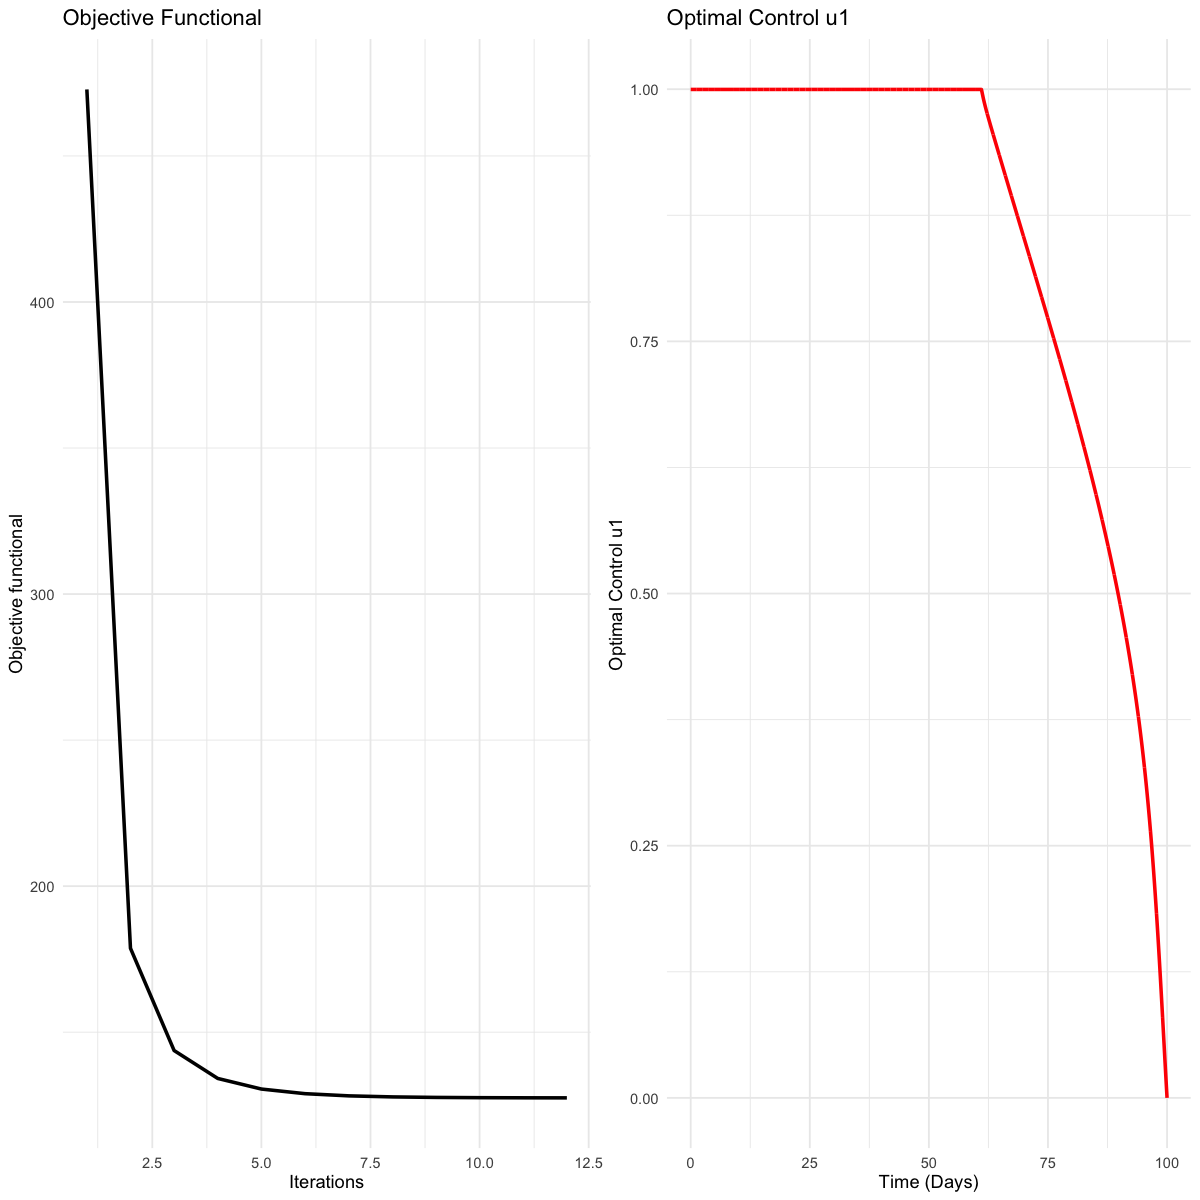

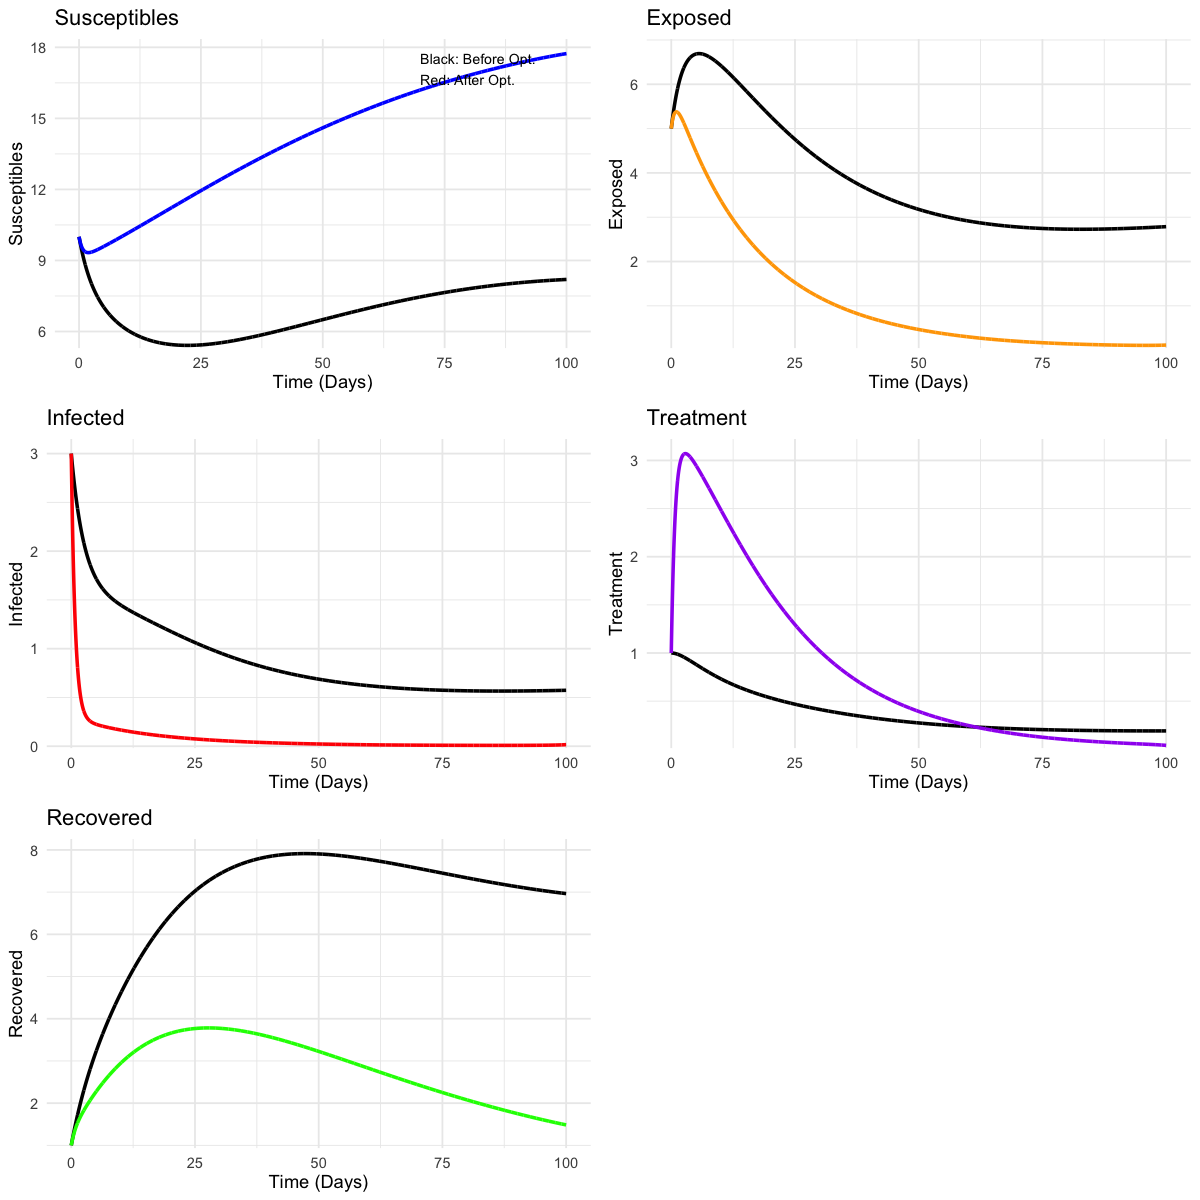

In [6]:
# 1. Objective functional and control profile
df_obj_ode <- data.frame(
  Iteration = itrs,
  Objective = FV
)
df_u1_ode <- data.frame(
  Time = t,
  u1 = u1
)

p_obj_ode <- ggplot(df_obj_ode, aes(x = Iteration, y = Objective)) +
  geom_line(color = "black", size = 1) +
  labs(title = "Objective Functional", x = "Iterations", y = "Objective functional") +
  theme_minimal()

p_u1_ode <- ggplot(df_u1_ode, aes(x = Time, y = u1)) +
  geom_line(color = "red", size = 1) +
  labs(title = "Optimal Control u1", x = "Time (Days)", y = "Optimal Control u1") +
  theme_minimal()

gridExtra::grid.arrange(p_obj_ode, p_u1_ode, ncol = 2)

# 2. State variables before/after optimization (long format for ggplot)
df_states <- data.frame(
  Time = t,
  S_before = S1,
  S_after = S,
  E_before = E1,
  E_after = E,
  I_before = I1,
  I_after = I,
  T_before = T1,
  T_after = T,
  R_before = R1,
  R_after = R
)

# Helper for compartment plot
plot_compartment <- function(df, before, after, title, color) {
  ggplot(df, aes(x = Time)) +
    geom_line(aes(y = !!as.name(before)), color = "black", size = 1, linetype = "solid") +
    geom_line(aes(y = !!as.name(after)), color = color, size = 1, linetype = "solid") +
    labs(title = title, x = "Time (Days)", y = title) +
    theme_minimal() +
    scale_y_continuous(expand = expansion(mult = c(0.01, 0.05))) +
    theme(legend.position = "none")
}

p_S <- plot_compartment(df_states, "S_before", "S_after", "Susceptibles", "blue")
p_E <- plot_compartment(df_states, "E_before", "E_after", "Exposed", "orange")
p_I <- plot_compartment(df_states, "I_before", "I_after", "Infected", "red")
p_T <- plot_compartment(df_states, "T_before", "T_after", "Treatment", "purple")
p_R <- plot_compartment(df_states, "R_before", "R_after", "Recovered", "green")

# Add legend to first plot only
p_S <- p_S +
  annotate("text", x = max(df_states$Time)*0.7, y = max(df_states$S_before, df_states$S_after), 
           label = "Black: Before Opt.\nRed: After Opt.", hjust = 0, vjust = 1, size = 3)

gridExtra::grid.arrange(p_S, p_E, p_I, p_T, p_R, ncol = 2)

## **Functions**

In [7]:
# Network generation function for SEITR simulation
generate_network <- function(network_type = "ER", n = 20, n_par1 = 0.3, n_par2 = 10) {
  if (network_type == "ER") {
    # Erdos-Renyi random graph
    g <- igraph::erdos.renyi.game(n = n, p.or.m = n_par1, type = "gnp", directed = FALSE)
  } else if (network_type == "BA") {
    # Barabasi-Albert preferential attachment
    g <- igraph::sample_pa(n = n, power = 1, m = max(1, round(n_par1 * n)), directed = FALSE)
  } else if (network_type == "WS") {
    # Watts-Strogatz small-world
    g <- igraph::sample_smallworld(dim = 1, size = n, nei = n_par2, p = n_par1)
  } else if (network_type == "LN") {
    # Lattice network
    g <- igraph::make_lattice(length = n, dim = 1, nei = n_par1, directed = FALSE, mutual = TRUE, circular = TRUE)
  } else if (network_type == "RR") {
    # Random regular graph
    g <- igraph::sample_k_regular(no.of.nodes = n, k = n_par1, directed = FALSE)
  } else {
    stop("Unknown network type")
  }
  return(g)
}

In [8]:
# SEITR node status assignment and transition functions
initialize_node_statuses <- function(g, S, E, I, T, R) {
  n <- igraph::vcount(g)
  # Ensure the sum does not exceed n
  stopifnot(S + E + I + T + R <= n)
  idx <- 1:n
  # Randomly sample unique indices for each compartment
  idx_I <- sample(idx, I)
  idx_rest <- setdiff(idx, idx_I)
  idx_E <- sample(idx_rest, E)
  idx_rest <- setdiff(idx_rest, idx_E)
  idx_T <- sample(idx_rest, T)
  idx_rest <- setdiff(idx_rest, idx_T)
  idx_R <- sample(idx_rest, R)
  idx_rest <- setdiff(idx_rest, idx_R)
  idx_S <- idx_rest # Remaining nodes are susceptible

  V(g)$status <- "S"
  V(g)$status[idx_I] <- "I"
  V(g)$status[idx_E] <- "E"
  V(g)$status[idx_T] <- "T"
  V(g)$status[idx_R] <- "R"
  return(g)
}

# Transition function for a single node (to be used in simulation loop)
update_node_status <- function(g, node, beta1, beta2, beta3, alpha1, alpha2, u1, N) {
  status <- V(g)[node]$status
  rand <- runif(1)
  if (status == "S") {
    # Infection probability depends on infected neighbors
    infected_neighbors <- sum(V(g)[neighbors(g, node)]$status == "I")
    if (infected_neighbors > 0 && rand < beta1 * infected_neighbors / N) {
      V(g)[node]$status <- "E"
    }
  } else if (status == "E" && rand < beta2) {
    V(g)[node]$status <- "I"
  } else if (status == "I") {
    rand2 <- runif(1)
    # Treatment probability includes optimal control
    if (rand < beta3) {
      V(g)[node]$status <- "R"
    } else if (rand2 < alpha1 + u1) {
      V(g)[node]$status <- "T"
    }
  } else if (status == "T" && rand < alpha2) {
    V(g)[node]$status <- "R"
  }
  # Death transitions can be handled separately in the main loop
  return(g)
}

In [9]:
# Helper function to connect new nodes according to network type
connect_new_nodes <- function(g, new_ids, network_type, n_par1, n_par2) {
  if (network_type == "ER") {
    # Connect each new node to existing nodes with probability n_par1
    for (new_node in new_ids) {
      existing_nodes <- setdiff(seq_len(igraph::vcount(g)), new_node)
      for (target in existing_nodes) {
        if (runif(1) < n_par1) {
          g <- igraph::add_edges(g, c(new_node, target))
        }
      }
    }
  } else if (network_type == "BA") {
    # Preferential attachment: connect to nodes with probability proportional to degree
    for (new_node in new_ids) {
      degrees <- igraph::degree(g)
      existing_nodes <- setdiff(seq_len(igraph::vcount(g)), new_node)
      prob <- degrees[existing_nodes] / sum(degrees[existing_nodes])
      m <- max(1, round(n_par1 * length(existing_nodes)))
      targets <- sample(existing_nodes, m, prob = prob, replace = FALSE)
      for (target in targets) {
        g <- igraph::add_edges(g, c(new_node, target))
      }
    }
  } else if (network_type == "WS") {
    # Connect to k nearest neighbors and rewire with probability n_par1
    k <- n_par2
    for (new_node in new_ids) {
      existing_nodes <- setdiff(seq_len(igraph::vcount(g)), new_node)
      if (length(existing_nodes) >= k) {
        neighbors <- sample(existing_nodes, k)
        for (neighbor in neighbors) {
          g <- igraph::add_edges(g, c(new_node, neighbor))
        }
        # Rewire edges with probability n_par1
        for (neighbor in neighbors) {
          if (runif(1) < n_par1) {
            possible_nodes <- setdiff(existing_nodes, neighbor)
            if (length(possible_nodes) > 0) {
              new_neighbor <- sample(possible_nodes, 1)
              g <- igraph::delete_edges(g, igraph::get.edge.ids(g, c(new_node, neighbor)))
              g <- igraph::add_edges(g, c(new_node, new_neighbor))
            }
          }
        }
      }
    }
  } else if (network_type == "LN") {
    # Connect to n_par1 nearest neighbors in a ring
    for (new_node in new_ids) {
      existing_nodes <- setdiff(seq_len(igraph::vcount(g)), new_node)
      k <- n_par1
      if (length(existing_nodes) >= k) {
        neighbors <- sample(existing_nodes, k)
        for (neighbor in neighbors) {
          g <- igraph::add_edges(g, c(new_node, neighbor))
        }
      }
    }
  } else if (network_type == "RR") {
    # Connect each new node to n_par1 random existing nodes
    for (new_node in new_ids) {
      existing_nodes <- setdiff(seq_len(igraph::vcount(g)), new_node)
      if (length(existing_nodes) >= n_par1) {
        targets <- sample(existing_nodes, n_par1)
        for (target in targets) {
          g <- igraph::add_edges(g, c(new_node, target))
        }
      }
    }
  }
  return(g)
}

In [10]:
# Main SEITR network simulation function with optimal control and network-based node connection
run_seitr_network_simulation <- function(
  network_type, n, n_par1, n_par2,
  Lambda, beta1, beta2, beta3, alpha1, alpha2, delta_I, delta_T, mu,
  init_S, init_E, init_I, init_T, init_R, t_max, u1_profile, num_exp = 20, verbose = FALSE
) {
  times <- seq(0, t_max, by = 1)
  results_list <- vector("list", num_exp)
  
  for (exp in 1:num_exp) {
    g <- generate_network(network_type, n, n_par1, n_par2)
    g <- initialize_node_statuses(g, init_S, init_E, init_I, init_T, init_R)
    
    S_count <- numeric(length(times) + 1)
    E_count <- numeric(length(times) + 1)
    I_count <- numeric(length(times) + 1)
    T_count <- numeric(length(times) + 1)
    R_count <- numeric(length(times) + 1)
    N_count <- numeric(length(times) + 1)
    control_cost <- numeric(length(times) + 1)

    # Record initial counts at time 0 (before any transitions)
    S_count[1] <- sum(V(g)$status == "S")
    E_count[1] <- sum(V(g)$status == "E")
    I_count[1] <- sum(V(g)$status == "I")
    T_count[1] <- sum(V(g)$status == "T")
    R_count[1] <- sum(V(g)$status == "R")
    N_count[1] <- igraph::vcount(g)
    control_cost[1] <- w1 * u1_profile[1]^2
    
    for (t in seq_along(times)) {
      N <- igraph::vcount(g)
      u1 <- u1_profile[t]
      
      # Update node statuses
      for (node in seq_len(N)) {
        g <- update_node_status(g, node, beta1, beta2, beta3, alpha1, alpha2, u1, N)
      }
      
      # Disease-induced and natural deaths
      infected_nodes <- which(V(g)$status == "I")
      num_remove_I <- rbinom(1, length(infected_nodes), delta_I)
      if (num_remove_I > 0 && length(infected_nodes) > 0) {
        remove_I <- sample(infected_nodes, num_remove_I)
        g <- igraph::delete_vertices(g, remove_I)
      }
      treated_nodes <- which(V(g)$status == "T")
      num_remove_T <- rbinom(1, length(treated_nodes), delta_T)
      if (num_remove_T > 0 && length(treated_nodes) > 0) {
        remove_T <- sample(treated_nodes, num_remove_T)
        g <- igraph::delete_vertices(g, remove_T)
      }
      all_nodes <- seq_len(igraph::vcount(g))
      num_remove_mu <- rbinom(1, length(all_nodes), mu)
      if (num_remove_mu > 0 && length(all_nodes) > 0) {
        remove_mu <- sample(all_nodes, num_remove_mu)
        g <- igraph::delete_vertices(g, remove_mu)
      }
      
      # Recruitment: add new susceptible nodes (Lambda) and connect them according to network type
      num_add <- rpois(1, Lambda)
      if (num_add > 0) {
        g <- igraph::add_vertices(g, num_add)
        new_ids <- (igraph::vcount(g) - num_add + 1):igraph::vcount(g)
        V(g)[new_ids]$status <- "S"
        g <- connect_new_nodes(g, new_ids, network_type, n_par1, n_par2)
      }
      
      # Record counts
      S_count[t + 1] <- sum(V(g)$status == "S")
      E_count[t + 1] <- sum(V(g)$status == "E")
      I_count[t + 1] <- sum(V(g)$status == "I")
      T_count[t + 1] <- sum(V(g)$status == "T")
      R_count[t + 1] <- sum(V(g)$status == "R")
      N_count[t + 1] <- igraph::vcount(g)
      control_cost[t + 1] <- w1 * u1^2
    }
    
    results_list[[exp]] <- data.frame(
      time = c(0, times),
      S = S_count,
      E = E_count,
      I = I_count,
      T = T_count,
      R = R_count,
      N = N_count,
      control_cost = control_cost
    )
  }
  

  # Calculate mean, min, max for each compartment at each time step
  results_array <- array(NA, dim = c(length(c(0, times)), 8, num_exp))
  for (i in 1:num_exp) {
    results_array[,,i] <- as.matrix(results_list[[i]])
  }
  avg_df <- as.data.frame(apply(results_array, c(1,2), mean))
  colnames(avg_df) <- colnames(results_list[[1]])
  avg_df$time <- results_list[[1]]$time

  min_df <- as.data.frame(apply(results_array, c(1,2), min))
  colnames(min_df) <- colnames(results_list[[1]])
  min_df$time <- results_list[[1]]$time

  max_df <- as.data.frame(apply(results_array, c(1,2), max))
  colnames(max_df) <- colnames(results_list[[1]])
  max_df$time <- results_list[[1]]$time

  return(list(
    avg = avg_df,
    min = min_df,
    max = max_df,
    all = results_list
  ))
}

In [11]:
# Objective functional calculation for SEITR network simulation results
calculate_objective_functional <- function(results_df) {
  # Simpson's rule for numerical integration over time
  n <- nrow(results_df)
  if (n %% 2 == 0) n <- n - 1  # Simpson's rule requires odd number of intervals
  times <- results_df$time[1:n]
  E <- results_df$E[1:n]
  I <- results_df$I[1:n]
  control_cost <- results_df$control_cost[1:n]

  # Simpson's rule weights
  weights <- rep(2, n)
  weights[1] <- weights[n] <- 1
  weights[seq(2, n-1, by=2)] <- 4

  h <- mean(diff(times))
  J_E <- (h/3) * sum(weights * E)
  J_I <- (h/3) * sum(weights * I)
  J_W <- (h/3) * sum(weights * control_cost)

  J_total <- J_E + J_I + J_W
  return(list(J_E = J_E, J_I = J_I, J_W = J_W, J_total = J_total))
}

In [12]:
network_objective <- function(u1_profile) {
  # Ensure u1_profile is within bounds
  u1_profile <- pmin(zeta, pmax(0, u1_profile))
  # Run simulation
  results <- run_seitr_network_simulation(
    network_type = network_type, n = n, n_par1 = n_par1, n_par2 = n_par2,
    Lambda = Lambda, beta1 = beta1, beta2 = beta2, beta3 = beta3, alpha1 = alpha1, alpha2 = alpha2,
    delta_I = delta_I, delta_T = delta_T, mu = mu,
    init_S = init_S, init_E = init_E, init_I = init_I, init_T = init_T, init_R = init_R,
    t_max = t_max, u1_profile = u1_profile, num_exp = 10
  )
  J <- calculate_objective_functional(results$avg)$J_total
  return(J)
}

## **Initial Experiment**

Experiment parameters are the same used in ODE

In [13]:
# Define model parameters and initial conditions
Lambda    <- 0.4         # Recruitment rate
beta1     <- 0.9         # Transmission rate (S to E)
beta2     <- 0.059       # Progression rate (E to I)
beta3     <- 0.2         # Recovery rate (I to R)
alpha1    <- 0.03        # Treatment rate (I to T)
alpha2    <- 0.055       # Recovery rate from treatment (T to R)
delta_I   <- 0.03        # Disease-induced death rate (I)
delta_T   <- 0.03        # Disease-induced death rate (T)
mu        <- 0.02        # Natural death rate

# Control parameters
w1        <- 0.2         # Weight for control cost
zeta      <- 1           # Upper bound for control
# Simulation time setup
t_max     <- 100
dt        <- 1           # Time step for network simulation
times     <- seq(0, t_max, by = dt)
# Initial conditions
init_S    <- 10
init_E    <- 5
init_I    <- 3
init_T    <- 1
init_R    <- 1
init_N    <- init_S + init_E + init_I + init_T + init_R

# Network parameters
network_type <- "ER"     # Network type: ER, BA, WS, LN, RR
n            <- 20       # Initial number of nodes
n_par1       <- 0.3      # Network-specific parameter 1
n_par2       <- 10       # Network-specific parameter 2

# Interpolate ODE optimal control to network simulation time grid for initial experiment
# u1_profile <- approx(x = t, y = u1, xout = seq(0, t_max+1, by = dt), rule = 2)$y

Calculate u1_profile on network simulations

In [14]:
# Set up parallel backend
n_cores <- detectCores() - 3
cl <- makeCluster(n_cores)
setDefaultCluster(cl)
clusterEvalQ(cl, library(igraph))

# Make RNG streams consistent across calls
RNGkind("L'Ecuyer-CMRG")

# Parameterization
K <- 12
total_steps <- length(seq(0, t_max, by = dt))
interval_length <- ceiling(total_steps / K)

expand_u1 <- function(params_seg, total_length, interval_length) {
  prof <- rep(params_seg, each = interval_length)[1:total_length]
  prof  # unbounded profile (no [0, zeta] clipping)
}

# Objective: use CRN and heavier averaging during optimization
objective_wrapper <- function(params_seg) {
  set.seed(12345)  # CRN for fair comparisons across parameter sets
  u1_profile <- rep(params_seg, each = interval_length)[1:total_steps]
  results <- run_seitr_network_simulation(
    network_type = network_type, n = n, n_par1 = n_par1, n_par2 = n_par2,
    Lambda = Lambda, beta1 = beta1, beta2 = beta2, beta3 = beta3, alpha1 = alpha1, alpha2 = alpha2,
    delta_I = delta_I, delta_T = delta_T, mu = mu,
    init_S = init_S, init_E = init_E, init_I = init_I, init_T = init_T, init_R = init_R,
    t_max = t_max, u1_profile = u1_profile, num_exp = 40, verbose = FALSE
  )
  calculate_objective_functional(results$avg)$J_total
}

# Initialize at 0.03 for all segments
init_seg <- rep(0.03, K)

# Export everything used by workers
clusterExport(cl, varlist = c(
  "objective_wrapper",
  "K", "interval_length", "total_steps",
  "run_seitr_network_simulation", "calculate_objective_functional",
  "generate_network", "initialize_node_statuses", "update_node_status", "connect_new_nodes",
  "network_type", "n", "n_par1", "n_par2",
  "Lambda", "beta1", "beta2", "beta3", "alpha1", "alpha2",
  "delta_I", "delta_T", "mu", "init_S", "init_E", "init_I", "init_T", "init_R", "t_max", "dt", "w1"
))

# Bounded L-BFGS-B over [0, zeta]^K
result <- optimParallel(
  par = init_seg,
  fn = objective_wrapper,
  method = "L-BFGS-B",
  lower = 0,
  upper = zeta,
  control = list(trace = 1, maxit = 2000, pgtol = 1e-6),
  cl = cl
)

# Build optimized profile back on the simulation grid
u1_opt_seg     <- as.numeric(result$par)
u1_profile_opt <- rep(u1_opt_seg, each = interval_length)[1:total_steps]

stopCluster(cl)

[[1]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[3]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[4]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[5]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[6]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[7]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[8]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"

final  value 137.849250 
converged


Run the experiments

In [15]:
# Run the SEITR network simulation with the optimal control profile

results_df <- run_seitr_network_simulation(
  network_type = network_type, n = n, n_par1 = n_par1, n_par2 = n_par2,
  Lambda = Lambda, beta1 = beta1, beta2 = beta2, beta3 = beta3, alpha1 = alpha1, alpha2 = alpha2,
  delta_I = delta_I, delta_T = delta_T, mu = mu,
  init_S = init_S, init_E = init_E, init_I = init_I, init_T = init_T, init_R = init_R,
  t_max = t_max, u1_profile = u1_profile_opt, num_exp = 20
)

J <- calculate_objective_functional(results_df$avg)

Warning message:
"`erdos.renyi.game()` was deprecated in igraph 0.8.0.
i Please use `sample_gnp()` instead."


In [16]:
# Run the SEITR network simulation with the optimal control profile
# but no control (u1 = 0) for comparison
u1_profile_no_control <- rep(0, total_steps)

results_df_no_control <- run_seitr_network_simulation(
  network_type = network_type, n = n, n_par1 = n_par1, n_par2 = n_par2,
  Lambda = Lambda, beta1 = beta1, beta2 = beta2, beta3 = beta3, alpha1 = alpha1, alpha2 = alpha2,
  delta_I = delta_I, delta_T = delta_T, mu = mu,
  init_S = init_S, init_E = init_E, init_I = init_I, init_T = init_T, init_R = init_R,
  t_max = t_max, u1_profile = u1_profile_no_control, num_exp = 20
)

J <- calculate_objective_functional(results_df_no_control$avg)

Network simulation results

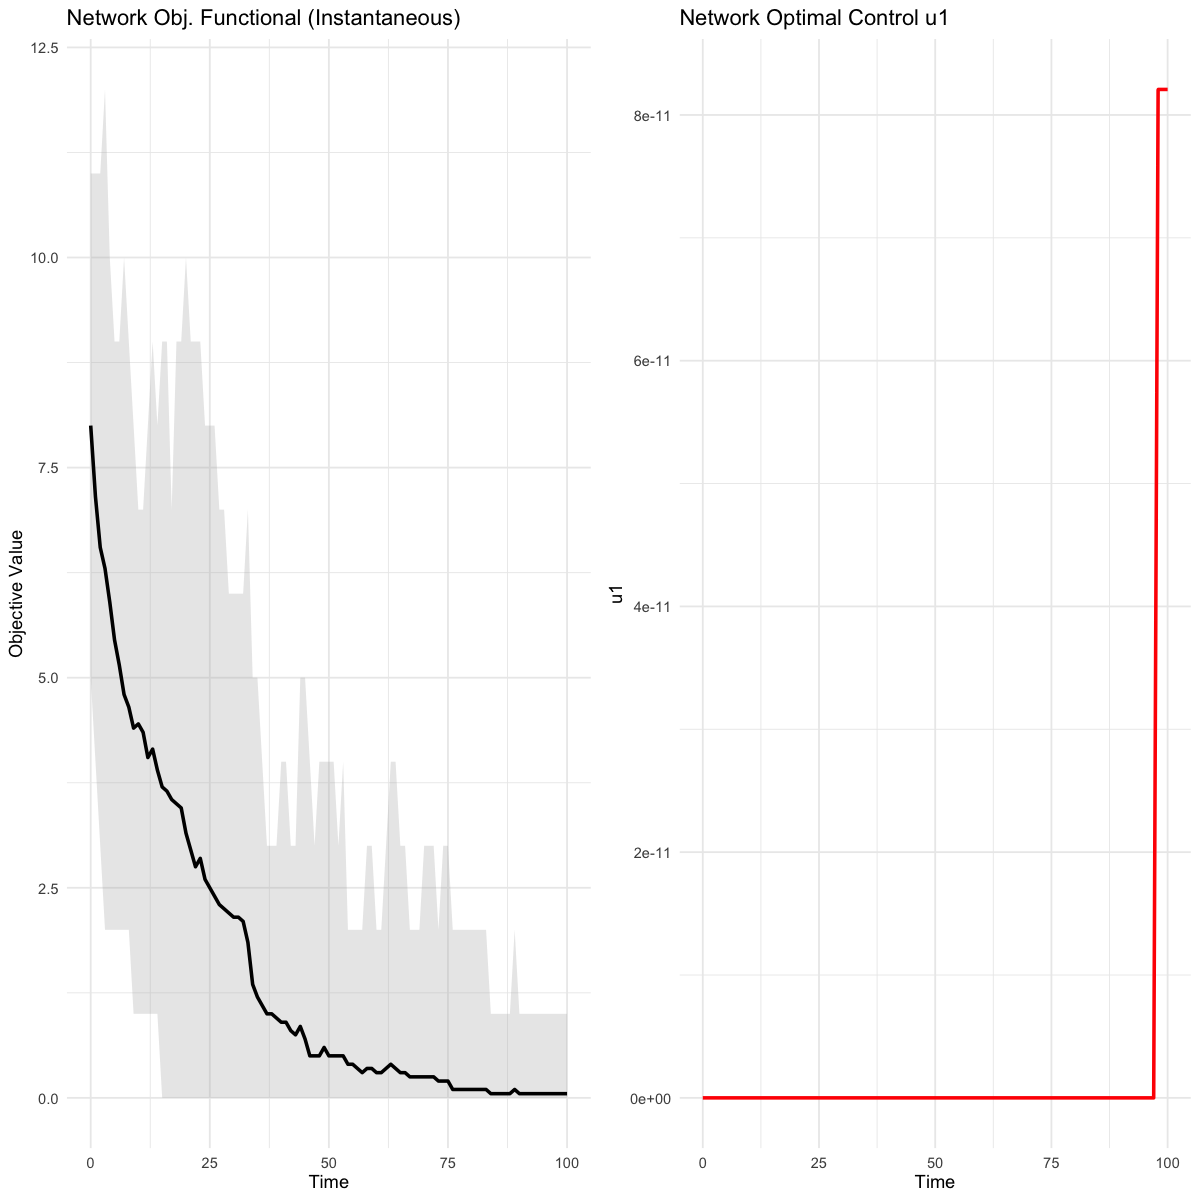

Network-based optimal control: Total objective functional = 182.556 


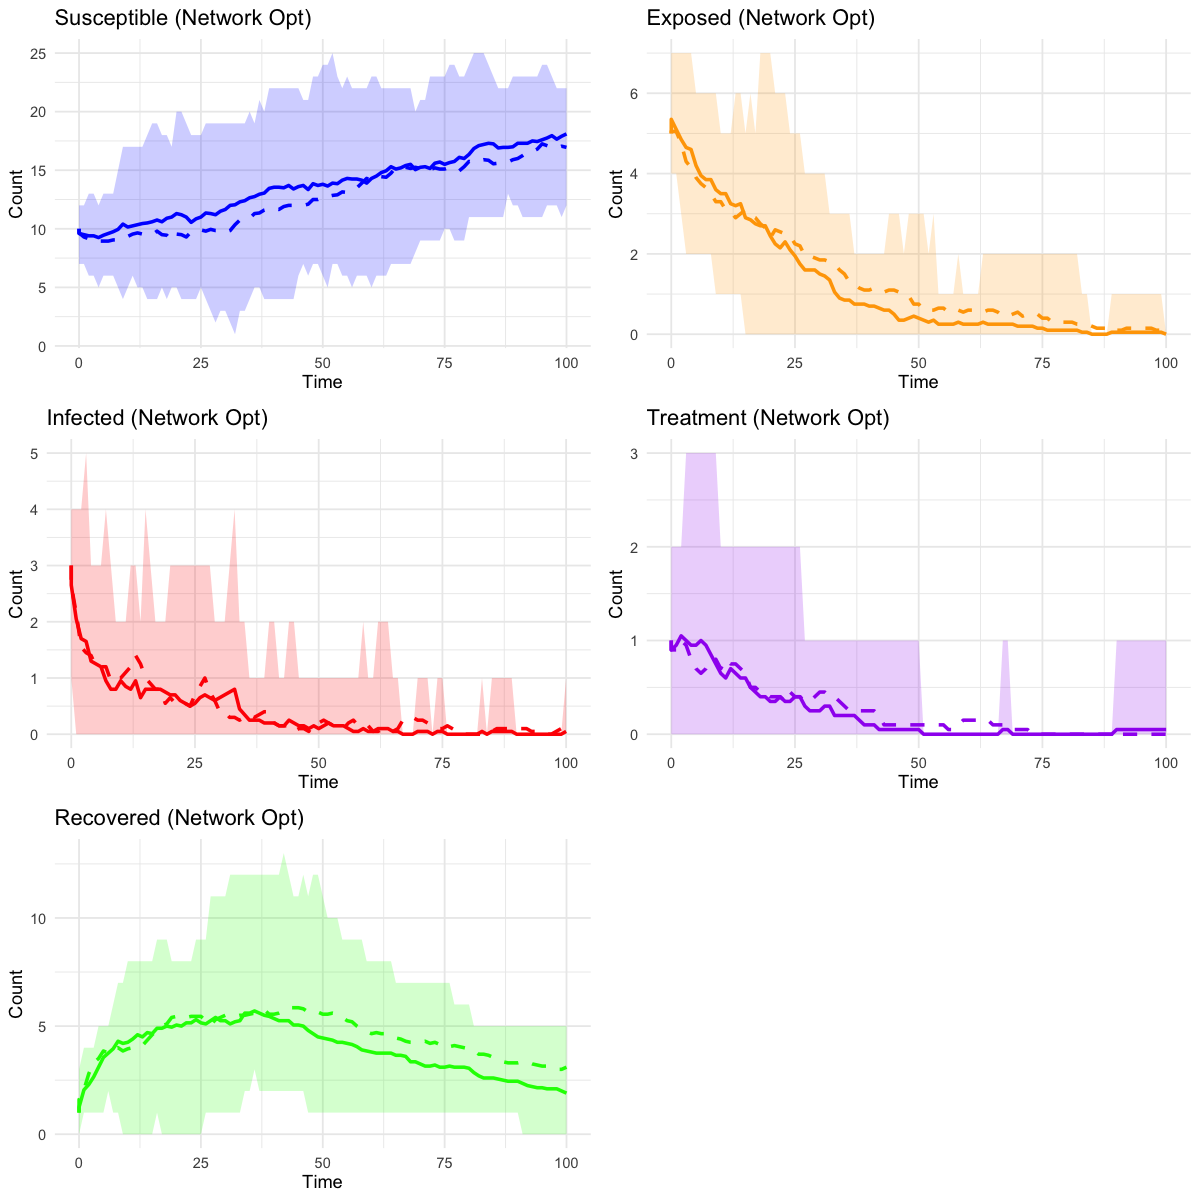

In [17]:
# --- Network simulation results with shaded min/max area (Network-based Optimal Control) ---
# Ensure u1_profile_opt matches df_avg$time length
# Use the avg/min/max from results_df
df_avg <- results_df$avg
df_min <- results_df$min
df_max <- results_df$max
# Use the avg from results_df_no_control for comparison
df_avg_no_control <- results_df_no_control$avg

if (length(u1_profile_opt) < length(df_avg$time)) {
  u1_profile_opt <- c(u1_profile_opt, rep(tail(u1_profile_opt, 1), length(df_avg$time) - length(u1_profile_opt)))
} else if (length(u1_profile_opt) > length(df_avg$time)) {
  u1_profile_opt <- u1_profile_opt[seq_along(df_avg$time)]
}


# 1. Objective functional and optimal control profile (average only)
df_obj <- data.frame(
  time = df_avg$time,
  obj_inst = df_avg$E + df_avg$I + df_avg$control_cost
)
df_obj_minmax <- data.frame(
  time = df_avg$time,
  min = df_min$E + df_min$I + df_min$control_cost,
  max = df_max$E + df_max$I + df_max$control_cost,
  avg = df_avg$E + df_avg$I + df_avg$control_cost
)

# Use the optimized control profile if available
if (exists("u1_profile_opt")) {
  df_u1 <- data.frame(time = df_avg$time, u1 = u1_profile_opt)
} else {
  stop("u1_profile_opt not found. Run the optimizer first.")
}

p_obj <- ggplot(df_obj_minmax, aes(x = time)) +
  geom_ribbon(aes(ymin = min, ymax = max), fill = "gray70", alpha = 0.3) +
  geom_line(aes(y = avg), color = "black", size = 1) +
  labs(title = "Network Obj. Functional (Instantaneous)", x = "Time", y = "Objective Value") +
  theme_minimal()

p_u1 <- ggplot(df_u1, aes(x = time, y = u1)) +
  geom_line(color = "red", size = 1) +
  labs(title = "Network Optimal Control u1", x = "Time", y = "u1") +
  theme_minimal()

gridExtra::grid.arrange(p_obj, p_u1, ncol = 2)

# 2. SEITR compartments with shaded min/max area
plot_compartment_band <- function(df_avg, df_min, df_max, df_avg_no_control, comp, color, title) {
  df <- data.frame(
    time = df_avg$time,
    avg = df_avg[[comp]],
    min = df_min[[comp]],
    max = df_max[[comp]],
    avg_no_control = df_avg_no_control[[comp]]
  )
  ggplot(df, aes(x = time)) +
    geom_ribbon(aes(ymin = min, ymax = max), fill = color, alpha = 0.2) +
    geom_line(aes(y = avg), color = color, size = 1) +
    geom_line(aes(y = avg_no_control), color = color, linetype = "dashed", size = 1) +
    labs(title = paste0(title, " (Network Opt)"), x = "Time", y = "Count") +
    theme_minimal()
}

p_S <- plot_compartment_band(df_avg, df_min, df_max, df_avg_no_control, "S", "blue", "Susceptible")
p_E <- plot_compartment_band(df_avg, df_min, df_max, df_avg_no_control, "E", "orange", "Exposed")
p_I <- plot_compartment_band(df_avg, df_min, df_max, df_avg_no_control, "I", "red", "Infected")
p_T <- plot_compartment_band(df_avg, df_min, df_max, df_avg_no_control, "T", "purple", "Treatment")
p_R <- plot_compartment_band(df_avg, df_min, df_max, df_avg_no_control, "R", "green", "Recovered")

gridExtra::grid.arrange(p_S, p_E, p_I, p_T, p_R, ncol = 2)

# Print final objective functional value
cat("Network-based optimal control: Total objective functional =", J$J_total, "\n")

Network simulation vs ODE solution with and without Optimal Control

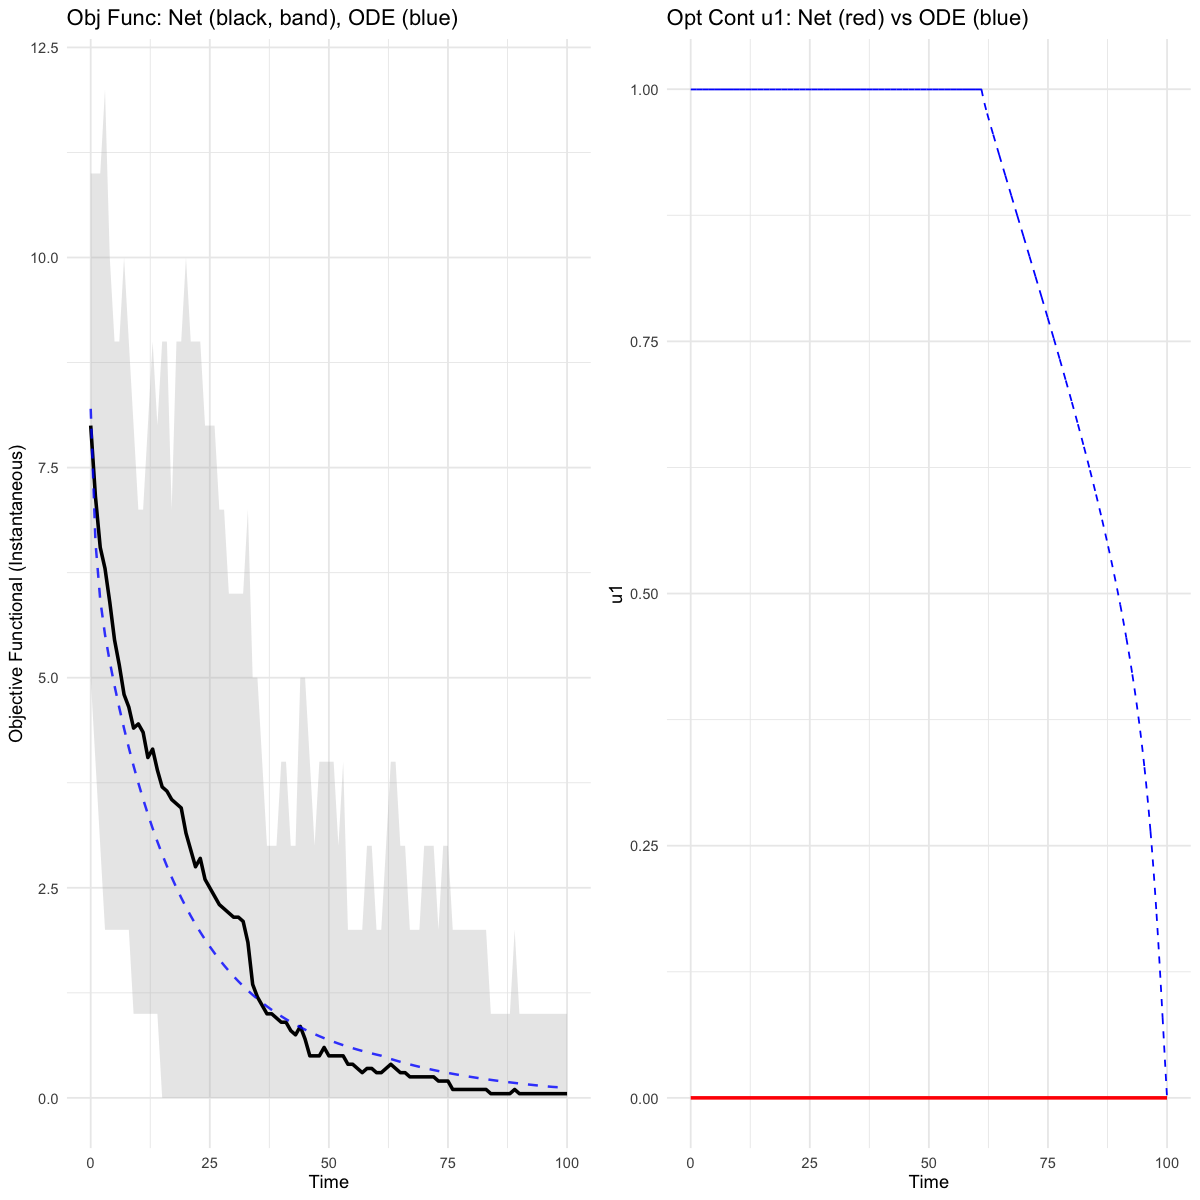

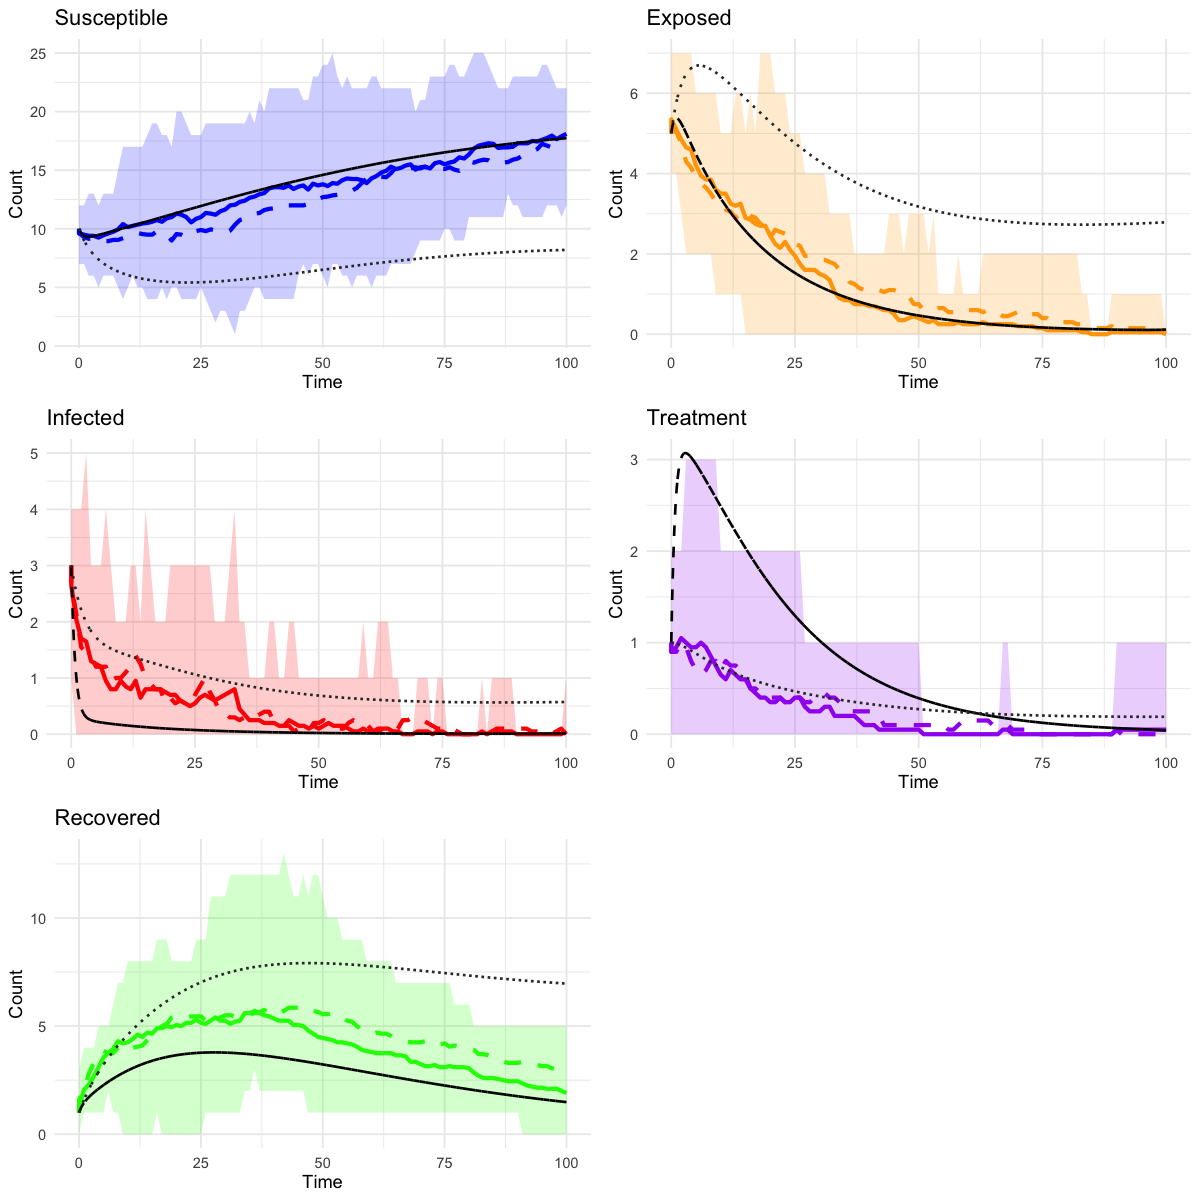

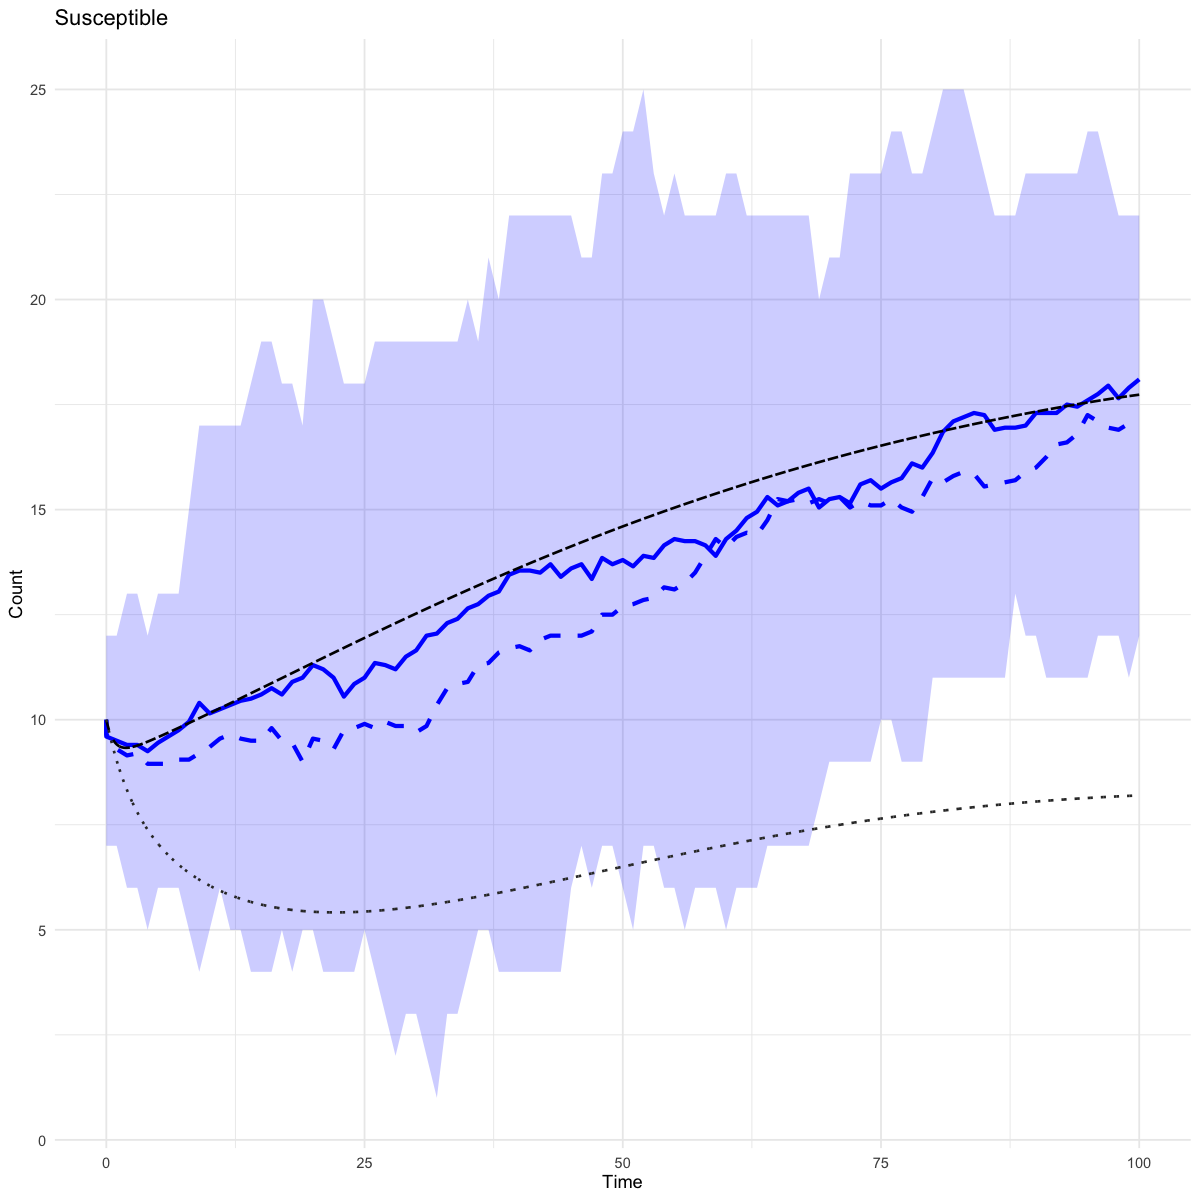

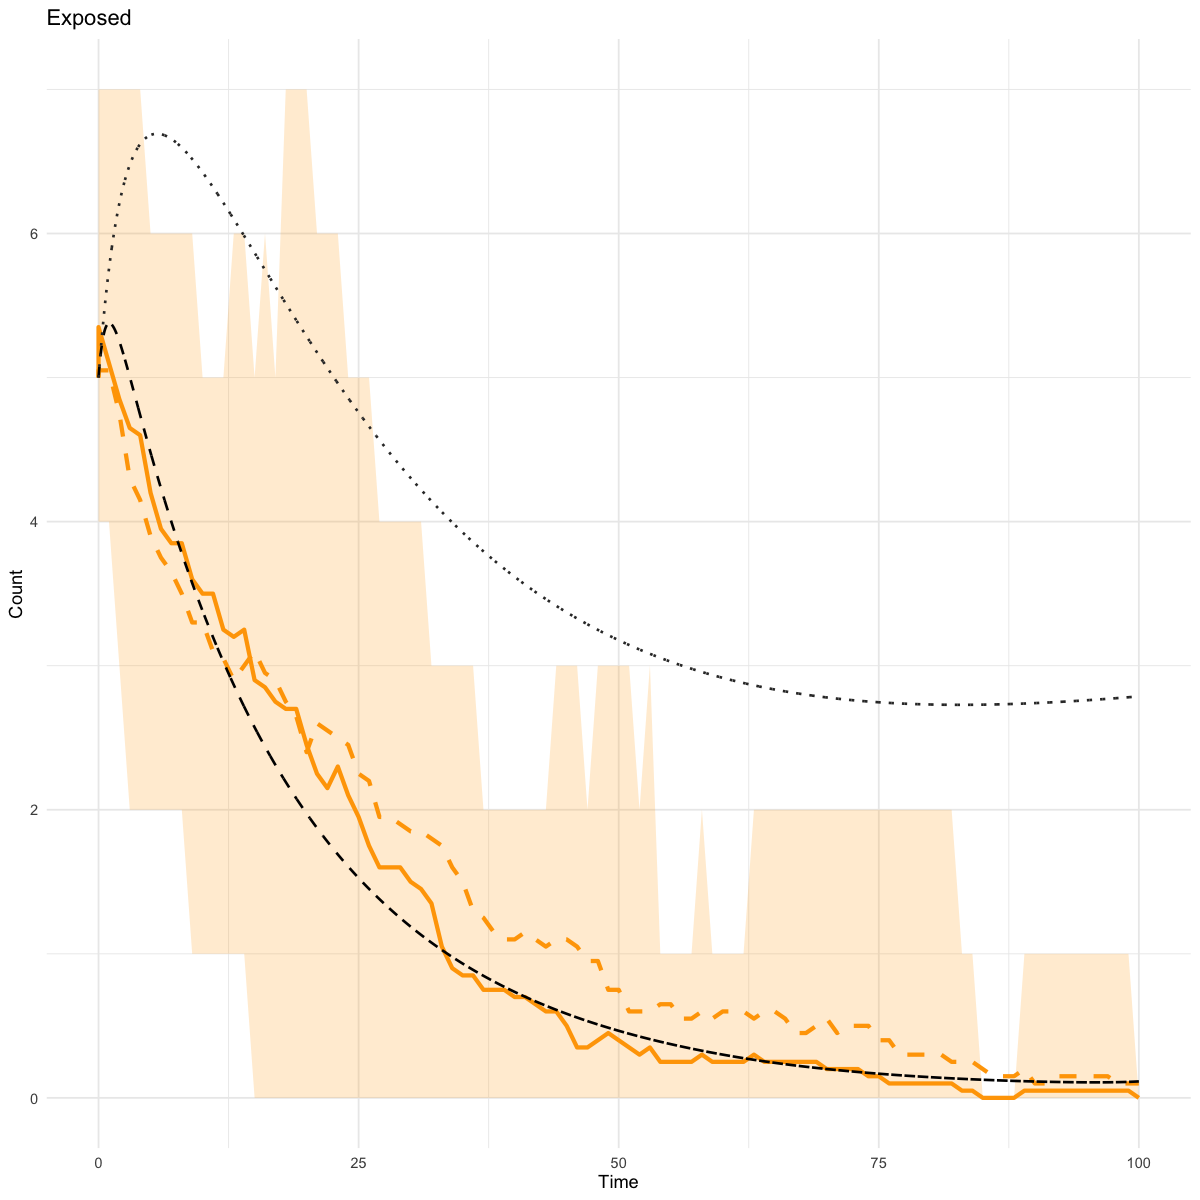

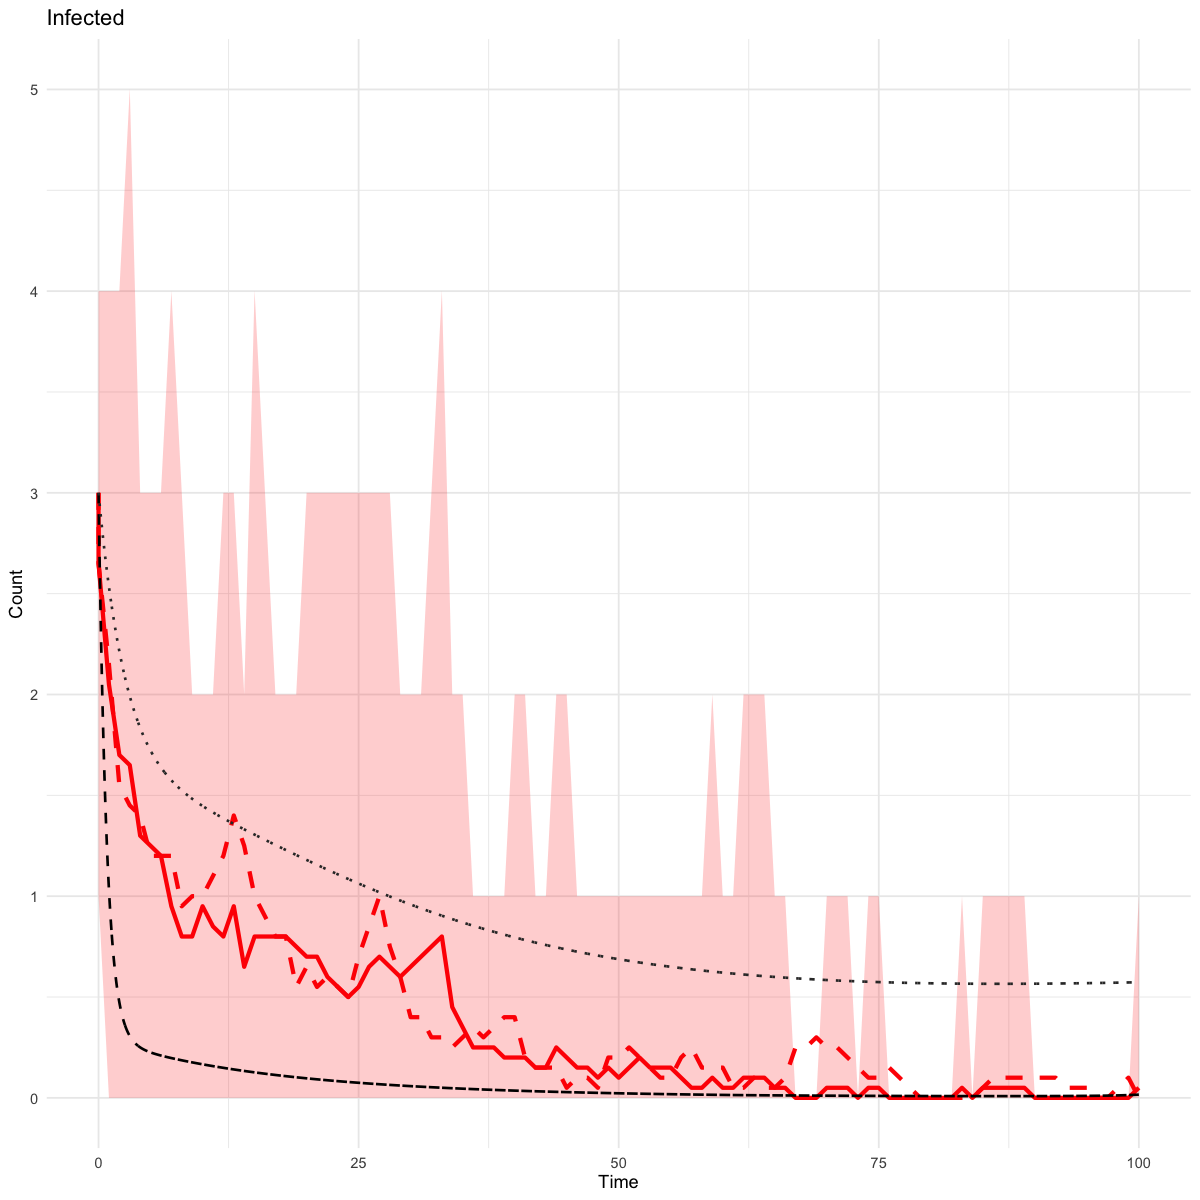

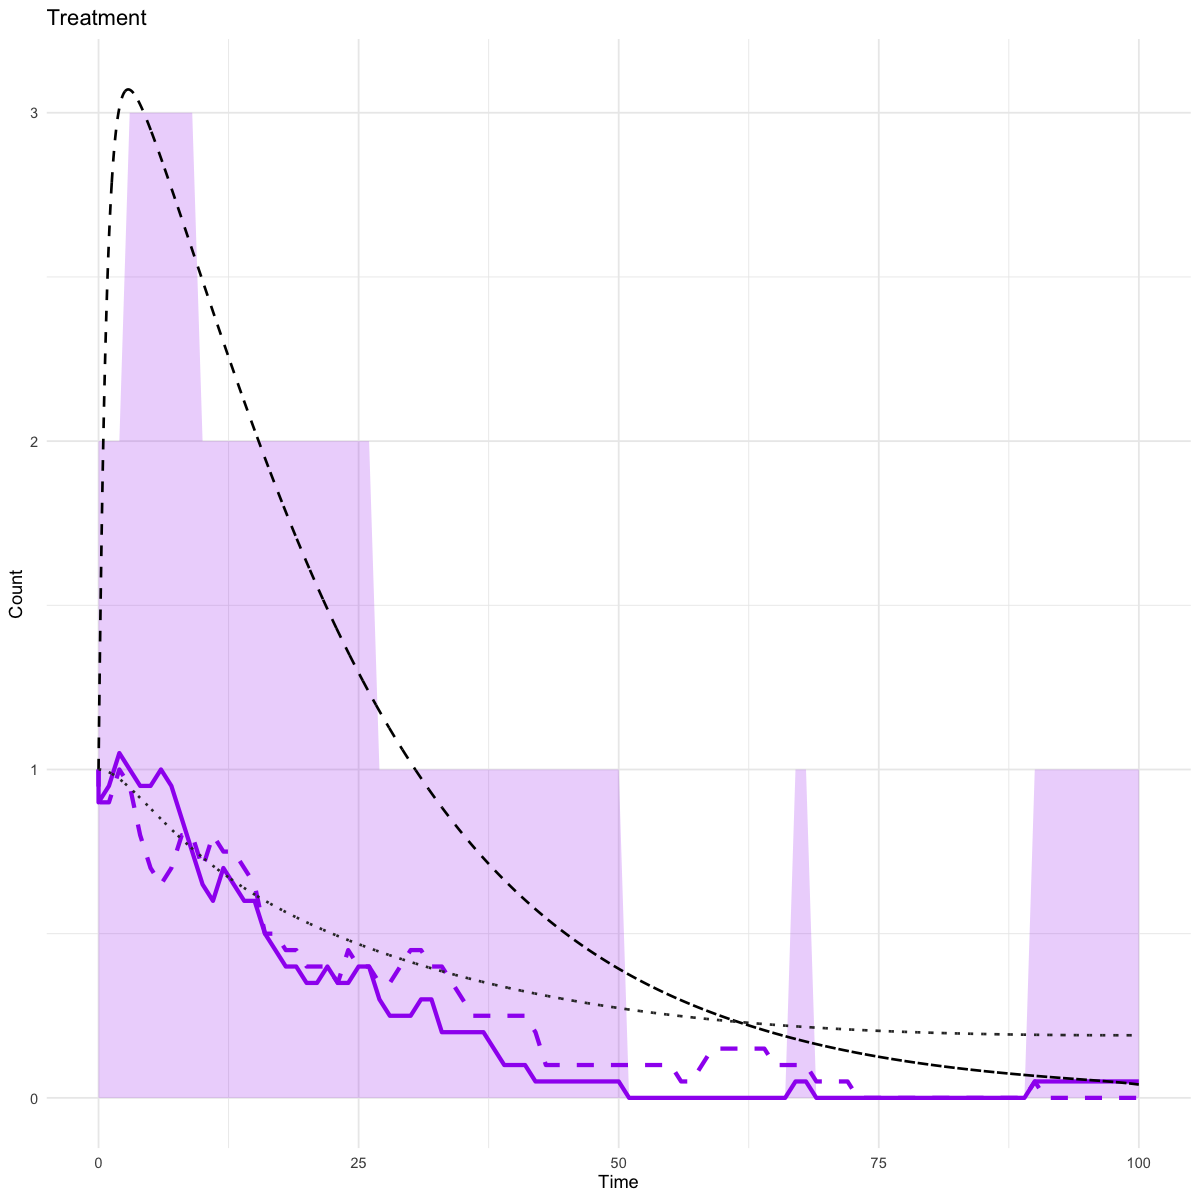

ODE total objective functional (Simpson's rule): 135.4472 


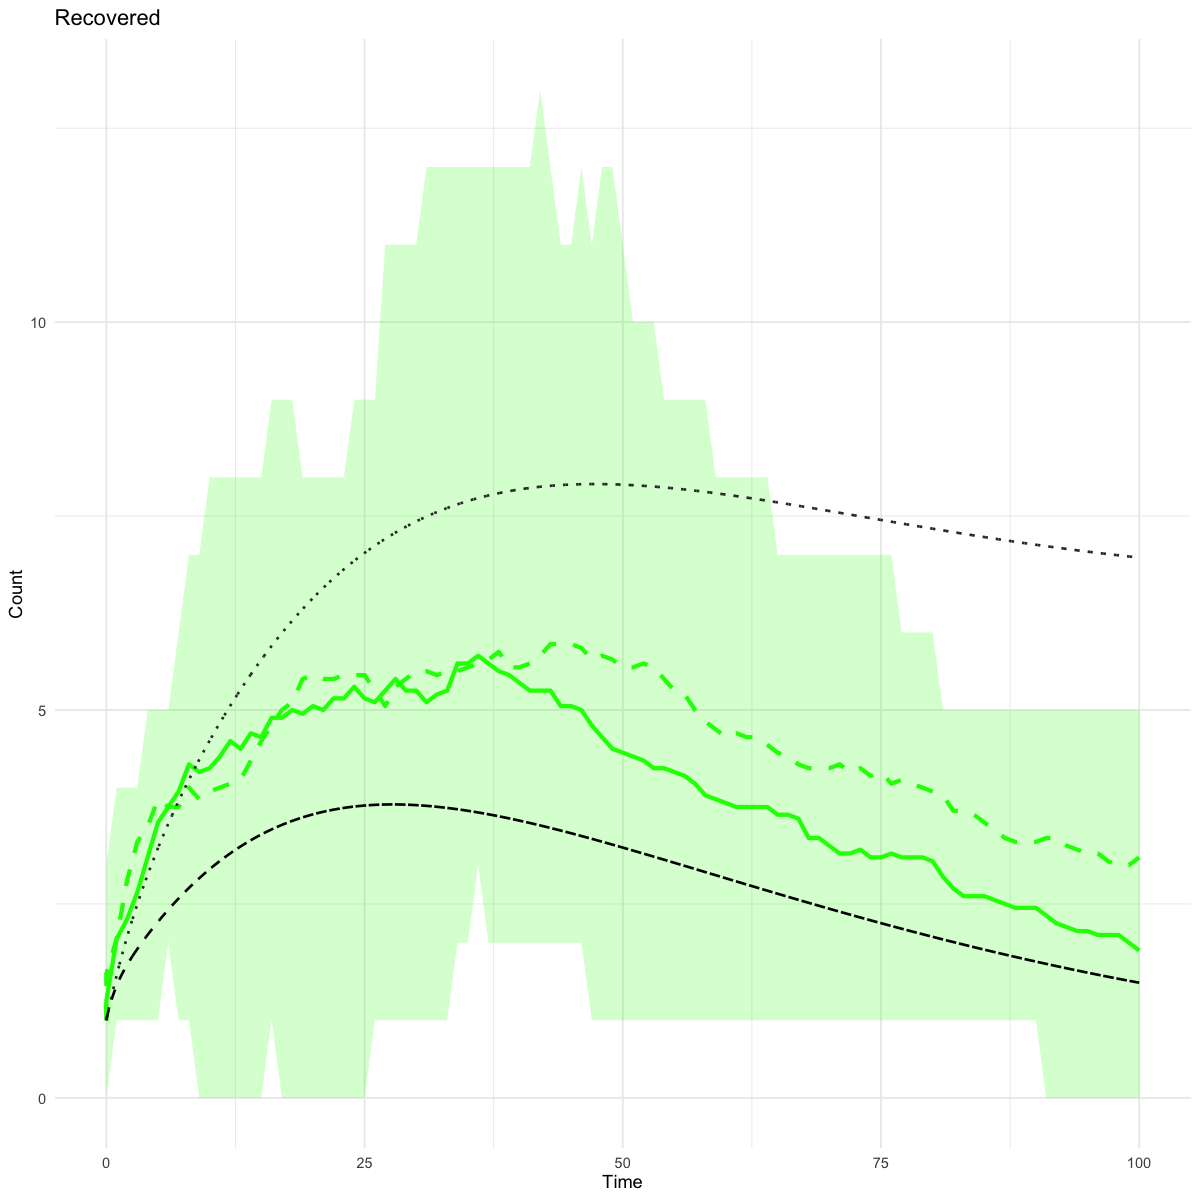

In [18]:
# Overlay ODE results on network simulation plots with min/max shading

# 1. Prepare ODE results as a data.frame for plotting
ode_results <- data.frame(
  time = t,
  S_before = S1,
  E_before = E1,
  I_before = I1,
  T_before = T1,
  R_before = R1,
  S_after = S,
  E_after = E,
  I_after = I,
  T_after = T,
  R_after = R,
  u1 = u1
)

# 2. Calculate ODE objective functional using Simpson's rule (total value)
n_ode <- length(t)
if (n_ode %% 2 == 0) n_ode <- n_ode - 1
ode_times <- t[1:n_ode]
E_ode <- E[1:n_ode]
I_ode <- I[1:n_ode]
u1_ode <- u1[1:n_ode]
w1 <- 0.2
control_cost_ode <- w1 * u1_ode^2
weights <- rep(2, n_ode); weights[1] <- weights[n_ode] <- 1; weights[seq(2, n_ode-1, by=2)] <- 4
h_ode <- mean(diff(ode_times))
J_ode_inst <- E_ode + I_ode + control_cost_ode
J_ode_total <- (h_ode/3) * sum(weights * J_ode_inst)

# 3. Interpolate ODE objective functional to network time grid
J_ode_interp <- approx(x = ode_times, y = J_ode_inst, xout = df_avg$time, rule = 2)$y

# 4. Prepare network objective functional with min/max bands
df_obj_minmax <- data.frame(
  time = df_avg$time,
  min = df_min$E + df_min$I + df_min$control_cost,
  max = df_max$E + df_max$I + df_max$control_cost,
  avg = df_avg$E + df_avg$I + df_avg$control_cost,
  ode_obj_inst = J_ode_interp
)

df_avg_no_control <- results_df_no_control$avg

p_obj <- ggplot(df_obj_minmax, aes(x = time)) +
  geom_ribbon(aes(ymin = min, ymax = max), fill = "gray70", alpha = 0.3) +
  geom_line(aes(y = avg), color = "black", size = 1) +
  geom_line(aes(y = ode_obj_inst), color = "blue", size = 0.7, linetype = "dashed", alpha = 0.8) +
  labs(title = "Obj Func: Net (black, band), ODE (blue)", x = "Time", y = "Objective Functional (Instantaneous)") +
  theme_minimal()

# 5. Optimal control profile
df_u1 <- data.frame(time = df_avg$time, u1 = u1_profile_opt)
df_u1_ode <- data.frame(time = t, u1 = u1)
p_u1 <- ggplot(df_u1, aes(x = time, y = u1)) +
  geom_line(color = "red", size = 1) +
  geom_line(data = df_u1_ode, aes(x = time, y = u1), color = "blue", size = 0.5, linetype = "dashed") +
  labs(title = "Opt Cont u1: Net (red) vs ODE (blue)", x = "Time", y = "u1") +
  theme_minimal()

gridExtra::grid.arrange(p_obj, p_u1, ncol = 2)

# 6. SEITR compartments: overlay ODE before/after optimization, add min/max bands
plot_compartment_band_overlay <- function(df_avg, df_min, df_max, df_avg_no_control, comp, color, title, ode_results, after, before) {
  df <- data.frame(
    time = df_avg$time,
    avg = df_avg[[comp]],
    min = df_min[[comp]],
    max = df_max[[comp]],
    avg_no_control = df_avg_no_control[[comp]]
  )
  ggplot(df, aes(x = time)) +
    geom_ribbon(aes(ymin = min, ymax = max), fill = color, alpha = 0.2) +
    geom_line(aes(y = avg), color = color, size = 1.2) +
    geom_line(aes(y = avg_no_control), color = color, linetype = "dashed", size = 1.2) +
    geom_line(data = ode_results, aes(x = time, y = !!as.name(after)), color = "black", size = 0.75, linetype = "dashed") +
    geom_line(data = ode_results, aes(x = time, y = !!as.name(before)), color = "gray20", size = 0.75, linetype = "dotted") +
    labs(title = title, x = "Time", y = "Count") +
    theme_minimal()
}

p_S <- plot_compartment_band_overlay(df_avg, df_min, df_max, df_avg_no_control, "S", "blue", "Susceptible", ode_results, "S_after", "S_before")
p_E <- plot_compartment_band_overlay(df_avg, df_min, df_max, df_avg_no_control, "E", "orange", "Exposed", ode_results, "E_after", "E_before")
p_I <- plot_compartment_band_overlay(df_avg, df_min, df_max, df_avg_no_control, "I", "red", "Infected", ode_results, "I_after", "I_before")
p_T <- plot_compartment_band_overlay(df_avg, df_min, df_max, df_avg_no_control, "T", "purple", "Treatment", ode_results, "T_after", "T_before")
p_R <- plot_compartment_band_overlay(df_avg, df_min, df_max, df_avg_no_control, "R", "green", "Recovered", ode_results, "R_after", "R_before")

gridExtra::grid.arrange(p_S, p_E, p_I, p_T, p_R, ncol = 2)

print(p_S)
print(p_E)
print(p_I)
print(p_T)
print(p_R)

# Print ODE total objective functional value
cat("ODE total objective functional (Simpson's rule):", J_ode_total, "\n")

In [19]:
compartments <- c("S", "E", "I", "T", "R")
msd_list <- numeric(length(compartments))
rmsd_list <- numeric(length(compartments))
norm_rmsd_list <- numeric(length(compartments))

for (i in seq_along(compartments)) {
  comp <- compartments[i]
  ode_interp <- approx(x = ode_results$time, y = ode_results[[paste0(comp, "_after")]], xout = df_avg$time, rule = 2)$y
  net_avg <- df_avg[[comp]]
  msd <- mean((net_avg - ode_interp)^2)
  rmsd <- sqrt(msd)
  #Added max
  norm_factor <- max(1, mean(net_avg)) # You can also use max(net_avg) or range(net_avg)
  norm_rmsd <- rmsd / norm_factor
  msd_list[i] <- msd
  rmsd_list[i] <- rmsd
  norm_rmsd_list[i] <- norm_rmsd
  cat(sprintf("Compartment: %s | MSD: %.4f | RMSD: %.4f | Normalized RMSD: %.4f\n", comp, msd, rmsd, norm_rmsd))
}

Compartment: S | MSD: 0.3873 | RMSD: 0.6223 | Normalized RMSD: 0.0455
Compartment: E | MSD: 0.0456 | RMSD: 0.2135 | Normalized RMSD: 0.1773
Compartment: I | MSD: 0.1887 | RMSD: 0.4344 | Normalized RMSD: 0.4344
Compartment: T | MSD: 0.7276 | RMSD: 0.8530 | Normalized RMSD: 0.8530
Compartment: R | MSD: 1.4292 | RMSD: 1.1955 | Normalized RMSD: 0.3088


Network size 100, ER, p = 0.3

In [26]:
# Parameters
Lambda <- 0.4
beta1 <- 0.9
beta2 <- 0.059
beta3 <- 0.2
alpha1 <- 0.03
alpha2 <- 0.055
delta_I <- 0.03
delta_T <- 0.03
mu <- 0.02

# Derived quantities
k1 <- beta3 + mu + delta_I + alpha1
k2 <- beta2 + mu
k3 <- mu + delta_T + alpha2
R0 <- (beta1 * beta2) / (k1 * k2)
cat("R0 =", R0, "\n")

# Time setup
h <- 0.01
t <- seq(0, 100, by = h)
L <- length(t)

# Weights and control bounds
w1 <- 0.2
zeta <- 1
delta <- 0.001

# Initial conditions
S <- E <- I <- T <- R <- N <- numeric(L)
S[1] <- 50
E[1] <- 25
I[1] <- 15
T[1] <- 5
R[1] <- 5
N[1] <- S[1] + E[1] + I[1] + T[1] + R[1]

# Control and adjoint initialization
u1 <- rep(0.03, L)
lambda1 <- lambda2 <- lambda3 <- lambda4 <- lambda5 <- numeric(L)
lambda1[L] <- lambda2[L] <- lambda3[L] <- lambda4[L] <- lambda5[L] <- 0

itr <- 0
test <- -1

R0 = 2.400542 


In [27]:
# System dynamics (state equations) using RK4 method

# Define right-hand side functions
f1 <- function(S, I, N)     Lambda - (beta1 * S * I) / N - mu * S
f2 <- function(S, I, N, E)  (beta1 * S * I) / N - (beta2 + mu) * E
f3 <- function(E, I, u1)    beta2 * E - (beta3 + mu + delta_I + u1) * I
f4 <- function(u1, I, T)    u1 * I - (mu + delta_T + alpha2) * T
f5 <- function(I, T, R)     beta3 * I + alpha2 * T - mu * R
f6 <- function(N, I, T)     Lambda - N * mu - delta_I * I - delta_T * T

# Forward integration for state variables (one iteration, as in MATLAB)
for (i in 1:(L-1)) {
  m1 <- f1(S[i], I[i], N[i])
  n1 <- f2(S[i], I[i], N[i], E[i])
  o1 <- f3(E[i], I[i], u1[i])
  p1 <- f4(u1[i], I[i], T[i])
  q1 <- f5(I[i], T[i], R[i])
  r1 <- f6(N[i], I[i], T[i])
  
  m2 <- f1(S[i] + 0.5*h*m1, I[i] + 0.5*h*o1, N[i] + 0.5*h*r1)
  n2 <- f2(S[i] + 0.5*h*m1, I[i] + 0.5*h*o1, N[i] + 0.5*h*r1, E[i] + 0.5*h*n1)
  o2 <- f3(E[i] + 0.5*h*n1, I[i] + 0.5*h*o1, u1[i] + 0.5*h)
  p2 <- f4(u1[i] + 0.5*h, I[i] + 0.5*h*o1, T[i] + 0.5*h*p1)
  q2 <- f5(I[i] + 0.5*h*o1, T[i] + 0.5*h*p1, R[i] + 0.5*h*q1)
  r2 <- f6(N[i] + 0.5*h*r1, I[i] + 0.5*h*o1, T[i] + 0.5*h*p1)
  
  m3 <- f1(S[i] + 0.5*h*m2, I[i] + 0.5*h*o2, N[i] + 0.5*h*r2)
  n3 <- f2(S[i] + 0.5*h*m2, I[i] + 0.5*h*o2, N[i] + 0.5*h*r2, E[i] + 0.5*h*n2)
  o3 <- f3(E[i] + 0.5*h*n2, I[i] + 0.5*h*o2, u1[i] + 0.5*h)
  p3 <- f4(u1[i] + 0.5*h, I[i] + 0.5*h*o2, T[i] + 0.5*h*p2)
  q3 <- f5(I[i] + 0.5*h*o2, T[i] + 0.5*h*p2, R[i] + 0.5*h*q2)
  r3 <- f6(N[i] + 0.5*h*r2, I[i] + 0.5*h*o2, T[i] + 0.5*h*p2)
  
  m4 <- f1(S[i] + h*m3, I[i] + h*o3, N[i] + h*r3)
  n4 <- f2(S[i] + h*m3, I[i] + h*o3, N[i] + h*r3, E[i] + h*n3)
  o4 <- f3(E[i] + h*n3, I[i] + h*o3, u1[i] + h)
  p4 <- f4(u1[i] + h, I[i] + h*o3, T[i] + h*p3)
  q4 <- f5(I[i] + h*o3, T[i] + h*p3, R[i] + h*q3)
  r4 <- f6(N[i] + h*r3, I[i] + h*o3, T[i] + h*p3)
  
  S[i+1] <- S[i] + (h/6)*(m1 + 2*m2 + 2*m3 + m4)
  E[i+1] <- E[i] + (h/6)*(n1 + 2*n2 + 2*n3 + n4)
  I[i+1] <- I[i] + (h/6)*(o1 + 2*o2 + 2*o3 + o4)
  T[i+1] <- T[i] + (h/6)*(p1 + 2*p2 + 2*p3 + p4)
  R[i+1] <- R[i] + (h/6)*(q1 + 2*q2 + 2*q3 + q4)
  N[i+1] <- N[i] + (h/6)*(r1 + 2*r2 + 2*r3 + r4)
}

In [28]:
# Adjoint equations (backward in time)
g1 <- function(lambda1, I, N, lambda2) (beta1 * I * lambda1) / N + mu * lambda1 - (lambda2 * beta1 * I) / N
g2 <- function(lambda2, lambda3) -1 + beta2 * lambda2 + mu * lambda2 - beta2 * lambda3
g3 <- function(lambda1, S, N, lambda2, lambda3, u1, lambda4, lambda5) -1 + (beta1 * S * lambda1) / N - (beta1 * S * lambda2) / N +
    beta3 * lambda3 + mu * lambda3 + delta_I * lambda3 + u1 * lambda3 - lambda4 * u1 - lambda5 * beta3
g4 <- function(lambda4, lambda5) mu * lambda4 + delta_T * lambda4 + alpha2 * lambda4 - alpha2 * lambda5
g5 <- function(lambda5) lambda5 * mu

# Storage for objective functional and iteration count
FV <- numeric()
itrs <- numeric()

# Main optimal control iteration (while loop)
while (test < 0) {
  itr <- itr + 1
  
  # Store old values for convergence check
  oldu1 <- u1
  oldS <- S; oldE <- E; oldI <- I; oldT <- T; oldR <- R
  oldlambda1 <- lambda1; oldlambda2 <- lambda2; oldlambda3 <- lambda3
  oldlambda4 <- lambda4; oldlambda5 <- lambda5
  
  # Forward integration for state variables (RK4)
  for (i in 1:(L-1)) {
    m1 <- f1(S[i], I[i], N[i])
    n1 <- f2(S[i], I[i], N[i], E[i])
    o1 <- f3(E[i], I[i], u1[i])
    p1 <- f4(u1[i], I[i], T[i])
    q1 <- f5(I[i], T[i], R[i])
    r1 <- f6(N[i], I[i], T[i])
    
    m2 <- f1(S[i] + 0.5*h*m1, I[i] + 0.5*h*o1, N[i] + 0.5*h*r1)
    n2 <- f2(S[i] + 0.5*h*m1, I[i] + 0.5*h*o1, N[i] + 0.5*h*r1, E[i] + 0.5*h*n1)
    o2 <- f3(E[i] + 0.5*h*n1, I[i] + 0.5*h*o1, u1[i] + 0.5*h)
    p2 <- f4(u1[i] + 0.5*h, I[i] + 0.5*h*o1, T[i] + 0.5*h*p1)
    q2 <- f5(I[i] + 0.5*h*o1, T[i] + 0.5*h*p1, R[i] + 0.5*h*q1)
    r2 <- f6(N[i] + 0.5*h*r1, I[i] + 0.5*h*o1, T[i] + 0.5*h*p1)
    
    m3 <- f1(S[i] + 0.5*h*m2, I[i] + 0.5*h*o2, N[i] + 0.5*h*r2)
    n3 <- f2(S[i] + 0.5*h*m2, I[i] + 0.5*h*o2, N[i] + 0.5*h*r2, E[i] + 0.5*h*n2)
    o3 <- f3(E[i] + 0.5*h*n2, I[i] + 0.5*h*o2, u1[i] + 0.5*h)
    p3 <- f4(u1[i] + 0.5*h, I[i] + 0.5*h*o2, T[i] + 0.5*h*p2)
    q3 <- f5(I[i] + 0.5*h*o2, T[i] + 0.5*h*p2, R[i] + 0.5*h*q2)
    r3 <- f6(N[i] + 0.5*h*r2, I[i] + 0.5*h*o2, T[i] + 0.5*h*p2)
    
    m4 <- f1(S[i] + h*m3, I[i] + h*o3, N[i] + h*r3)
    n4 <- f2(S[i] + h*m3, I[i] + h*o3, N[i] + h*r3, E[i] + h*n3)
    o4 <- f3(E[i] + h*n3, I[i] + h*o3, u1[i] + h)
    p4 <- f4(u1[i] + h, I[i] + h*o3, T[i] + h*p3)
    q4 <- f5(I[i] + h*o3, T[i] + h*p3, R[i] + h*q3)
    r4 <- f6(N[i] + h*r3, I[i] + h*o3, T[i] + h*p3)
    
    S[i+1] <- S[i] + (h/6)*(m1 + 2*m2 + 2*m3 + m4)
    E[i+1] <- E[i] + (h/6)*(n1 + 2*n2 + 2*n3 + n4)
    I[i+1] <- I[i] + (h/6)*(o1 + 2*o2 + 2*o3 + o4)
    T[i+1] <- T[i] + (h/6)*(p1 + 2*p2 + 2*p3 + p4)
    R[i+1] <- R[i] + (h/6)*(q1 + 2*q2 + 2*q3 + q4)
    N[i+1] <- N[i] + (h/6)*(r1 + 2*r2 + 2*r3 + r4)
  }
  
  # Save initial trajectory for plotting
  if (itr == 1) {
    S1 <- S; E1 <- E; I1 <- I; T1 <- T; R1 <- R; N1 <- N
  }
  
  # Backward integration for adjoint variables (RK4, backward in time)
  for (i in 1:(L-1)) {
    j <- L + 1 - i
    k1 <- g1(lambda1[j], I[j], N[j], lambda2[j])
    l1 <- g2(lambda2[j], lambda3[j])
    c1 <- g3(lambda1[j], S[j], N[j], lambda2[j], lambda3[j], u1[j], lambda4[j], lambda5[j])
    v1 <- g4(lambda4[j], lambda5[j])
    d1 <- g5(lambda5[j])
    
    k2 <- g1(lambda1[j] - 0.5*h*k1, I[j] - 0.5*h, N[j] - 0.5*h, lambda2[j] - 0.5*h*l1)
    l2 <- g2(lambda2[j] - 0.5*h*l1, lambda3[j] - 0.5*h*c1)
    c2 <- g3(lambda1[j] - 0.5*h*k1, S[j] - 0.5*h, N[j] - 0.5*h, lambda2[j] - 0.5*h*l1, lambda3[j] - 0.5*h*c1, u1[j] - 0.5*h, lambda4[j] - 0.5*h*v1, lambda5[j] - 0.5*h*d1)
    v2 <- g4(lambda4[j] - 0.5*h*v1, lambda5[j] - 0.5*h*d1)
    d2 <- g5(lambda5[j] - 0.5*h*d1)
    
    k3 <- g1(lambda1[j] - 0.5*h*k2, I[j] - 0.5*h, N[j] - 0.5*h, lambda2[j] - 0.5*h*l2)
    l3 <- g2(lambda2[j] - 0.5*h*l2, lambda3[j] - 0.5*h*c2)
    c3 <- g3(lambda1[j] - 0.5*h*k2, S[j] - 0.5*h, N[j] - 0.5*h, lambda2[j] - 0.5*h*l2, lambda3[j] - 0.5*h*c2, u1[j] - 0.5*h, lambda4[j] - 0.5*h*v2, lambda5[j] - 0.5*h*d2)
    v3 <- g4(lambda4[j] - 0.5*h*v2, lambda5[j] - 0.5*h*d2)
    d3 <- g5(lambda5[j] - 0.5*h*d2)
    
    k4 <- g1(lambda1[j] - h*k3, I[j] - h, N[j] - h, lambda2[j] - h*l3)
    l4 <- g2(lambda2[j] - h*l3, lambda3[j] - h*c3)
    c4 <- g3(lambda1[j] - h*k3, S[j] - h, N[j] - h, lambda2[j] - h*l3, lambda3[j] - h*c3, u1[j] - h, lambda4[j] - h*v3, lambda5[j] - h*d3)
    v4 <- g4(lambda4[j] - h*v3, lambda5[j] - h*d3)
    d4 <- g5(lambda5[j] - h*d3)
    
    lambda1[j-1] <- lambda1[j] - (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    lambda2[j-1] <- lambda2[j] - (h/6)*(l1 + 2*l2 + 2*l3 + l4)
    lambda3[j-1] <- lambda3[j] - (h/6)*(c1 + 2*c2 + 2*c3 + c4)
    lambda4[j-1] <- lambda4[j] - (h/6)*(v1 + 2*v2 + 2*v3 + v4)
    lambda5[j-1] <- lambda5[j] - (h/6)*(d1 + 2*d2 + 2*d3 + d4)
  }
  
  # Simpson's rule for objective functional
  JE <- E[1] + E[L] + 4*sum(E[seq(2, L-1, by=2)]) + 2*sum(E[seq(3, L-2, by=2)])
  JI <- I[1] + I[L] + 4*sum(I[seq(2, L-1, by=2)]) + 2*sum(I[seq(3, L-2, by=2)])
  JW <- 0.5*w1*(u1[1]^2 + u1[L]^2 + 4*sum(u1[seq(2, L-1, by=2)]^2) + 2*sum(u1[seq(3, L-2, by=2)]^2))
  J <- (h/3)*(JE + JI + JW)
  FV[itr] <- J
  itrs[itr] <- itr
  
  # Control update
  ustar <- pmin(zeta, pmax(0, (I * (lambda3 - lambda4)) / w1))
  u1 <- 0.5 * (ustar + oldu1)
  
  # Convergence check
  temp1 <- delta*sum(abs(u1)) - sum(abs(oldu1-u1))
  temp2 <- delta*sum(abs(S)) - sum(abs(oldS-S))
  temp3 <- delta*sum(abs(E)) - sum(abs(oldE-E))
  temp4 <- delta*sum(abs(I)) - sum(abs(oldI-I))
  temp5 <- delta*sum(abs(T)) - sum(abs(oldT-T))
  temp6 <- delta*sum(abs(R)) - sum(abs(oldR-R))
  temp7 <- delta*sum(abs(lambda1)) - sum(abs(oldlambda1-lambda1))
  temp8 <- delta*sum(abs(lambda2)) - sum(abs(oldlambda2-lambda2))
  temp9 <- delta*sum(abs(lambda3)) - sum(abs(oldlambda3-lambda3))
  temp10 <- delta*sum(abs(lambda4)) - sum(abs(oldlambda4-lambda4))
  temp11 <- delta*sum(abs(lambda5)) - sum(abs(oldlambda5-lambda5))
  
  test <- min(temp1, temp2, temp3, temp4, temp5, temp6, temp7, temp8, temp9, temp10, temp11)
  cat(itr, "   ", test, "\n")
}

1     -191243.4 
2     -109242.3 
3     -25996.96 
4     -8819.765 
5     -3570.309 
6     -1505.175 
7     -658.9411 
8     -278.9535 
9     -104.4179 
10     -14.83407 
11     -3.211419 
12     0 


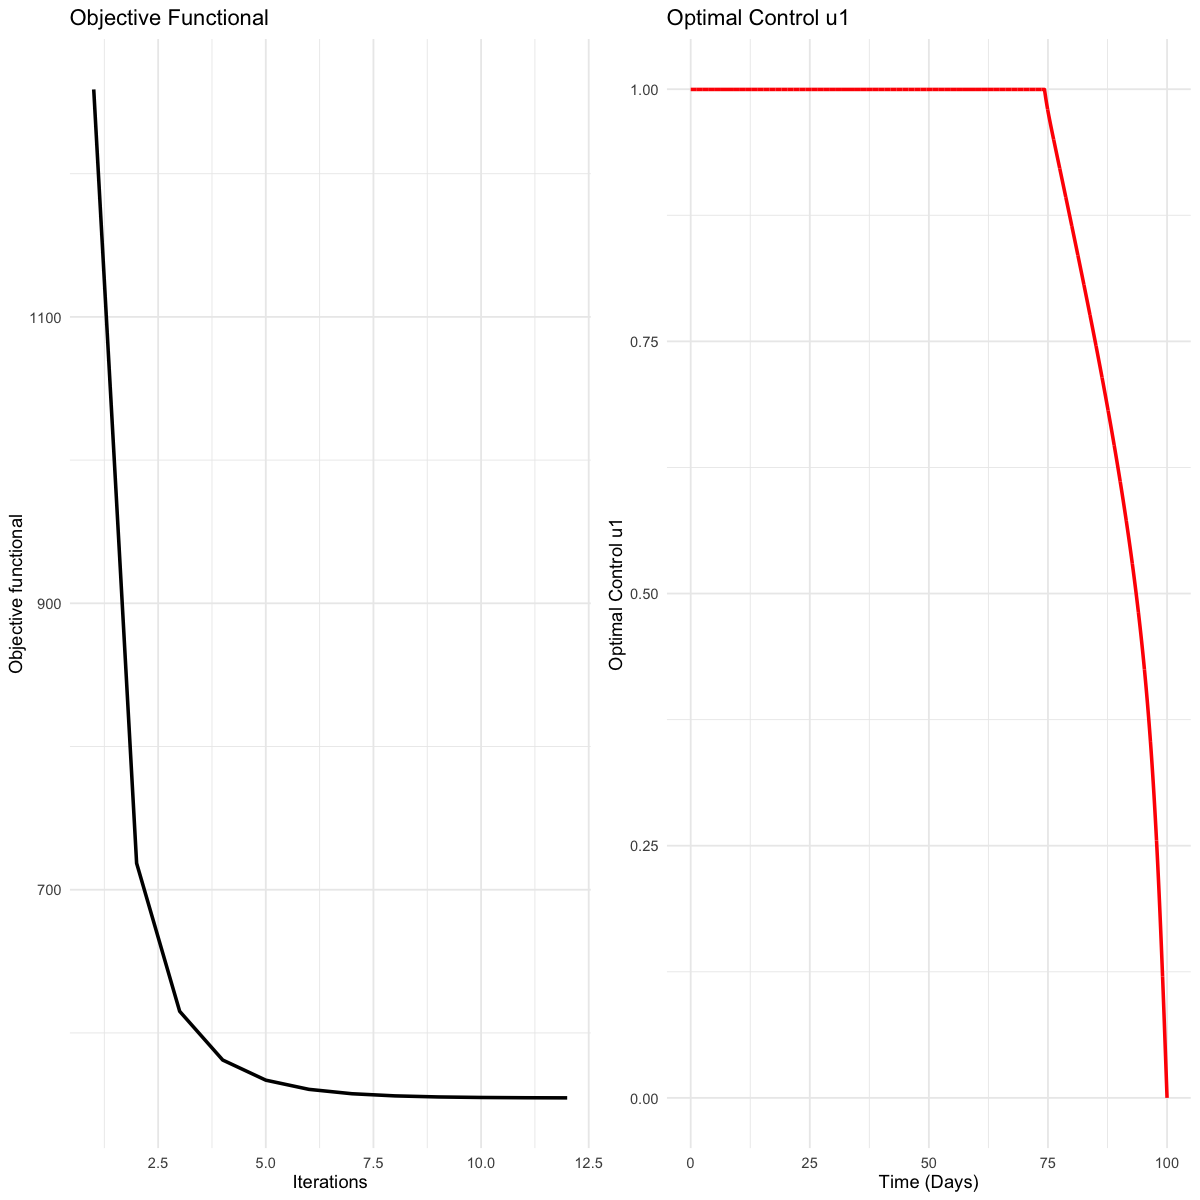

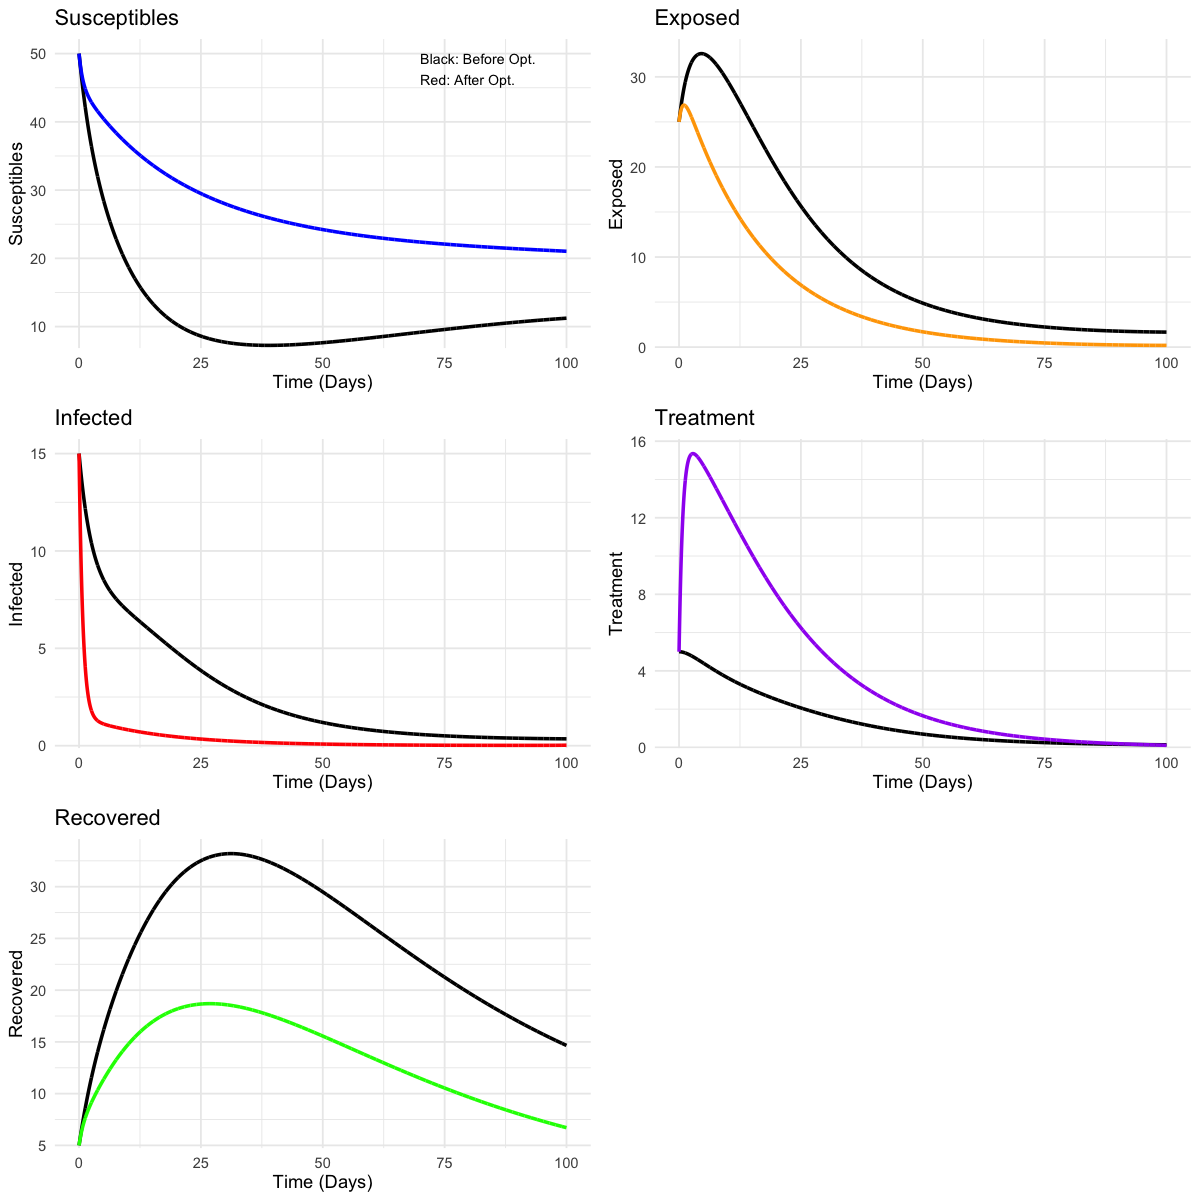

In [29]:
# 1. Objective functional and control profile
df_obj_ode <- data.frame(
  Iteration = itrs,
  Objective = FV
)
df_u1_ode <- data.frame(
  Time = t,
  u1 = u1
)

p_obj_ode <- ggplot(df_obj_ode, aes(x = Iteration, y = Objective)) +
  geom_line(color = "black", size = 1) +
  labs(title = "Objective Functional", x = "Iterations", y = "Objective functional") +
  theme_minimal()

p_u1_ode <- ggplot(df_u1_ode, aes(x = Time, y = u1)) +
  geom_line(color = "red", size = 1) +
  labs(title = "Optimal Control u1", x = "Time (Days)", y = "Optimal Control u1") +
  theme_minimal()

gridExtra::grid.arrange(p_obj_ode, p_u1_ode, ncol = 2)

# 2. State variables before/after optimization (long format for ggplot)
df_states <- data.frame(
  Time = t,
  S_before = S1,
  S_after = S,
  E_before = E1,
  E_after = E,
  I_before = I1,
  I_after = I,
  T_before = T1,
  T_after = T,
  R_before = R1,
  R_after = R
)

# Helper for compartment plot
plot_compartment <- function(df, before, after, title, color) {
  ggplot(df, aes(x = Time)) +
    geom_line(aes(y = !!as.name(before)), color = "black", size = 1, linetype = "solid") +
    geom_line(aes(y = !!as.name(after)), color = color, size = 1, linetype = "solid") +
    labs(title = title, x = "Time (Days)", y = title) +
    theme_minimal() +
    scale_y_continuous(expand = expansion(mult = c(0.01, 0.05))) +
    theme(legend.position = "none")
}

p_S <- plot_compartment(df_states, "S_before", "S_after", "Susceptibles", "blue")
p_E <- plot_compartment(df_states, "E_before", "E_after", "Exposed", "orange")
p_I <- plot_compartment(df_states, "I_before", "I_after", "Infected", "red")
p_T <- plot_compartment(df_states, "T_before", "T_after", "Treatment", "purple")
p_R <- plot_compartment(df_states, "R_before", "R_after", "Recovered", "green")

# Add legend to first plot only
p_S <- p_S +
  annotate("text", x = max(df_states$Time)*0.7, y = max(df_states$S_before, df_states$S_after), 
           label = "Black: Before Opt.\nRed: After Opt.", hjust = 0, vjust = 1, size = 3)

gridExtra::grid.arrange(p_S, p_E, p_I, p_T, p_R, ncol = 2)

In [30]:
# Define model parameters and initial conditions
Lambda    <- 0.4         # Recruitment rate
beta1     <- 0.9         # Transmission rate (S to E)
beta2     <- 0.059       # Progression rate (E to I)
beta3     <- 0.2         # Recovery rate (I to R)
alpha1    <- 0.03        # Treatment rate (I to T)
alpha2    <- 0.055       # Recovery rate from treatment (T to R)
delta_I   <- 0.03        # Disease-induced death rate (I)
delta_T   <- 0.03        # Disease-induced death rate (T)
mu        <- 0.02        # Natural death rate

# Control parameters
w1        <- 0.2         # Weight for control cost
zeta      <- 1           # Upper bound for control
# Simulation time setup
t_max     <- 100
dt        <- 1           # Time step for network simulation
times     <- seq(0, t_max, by = dt)
# Initial conditions
init_S    <- 50
init_E    <- 25
init_I    <- 15
init_T    <- 5
init_R    <- 5
init_N    <- init_S + init_E + init_I + init_T + init_R

# Network parameters
network_type <- "ER"     # Network type: ER, BA, WS, LN, RR
n            <- 100       # Initial number of nodes
n_par1       <- 0.3      # Network-specific parameter 1
n_par2       <- 10       # Network-specific parameter 2

# Interpolate ODE optimal control to network simulation time grid for initial experiment
# u1_profile <- approx(x = t, y = u1, xout = seq(0, t_max+1, by = dt), rule = 2)$y

Calculate u1_profile on network simulations

In [31]:
# Set up parallel backend
n_cores <- detectCores() - 3
cl <- makeCluster(n_cores)
setDefaultCluster(cl)
clusterEvalQ(cl, library(igraph))

# Make RNG streams consistent across calls
RNGkind("L'Ecuyer-CMRG")

# Parameterization
K <- 12
total_steps <- length(seq(0, t_max, by = dt))
interval_length <- ceiling(total_steps / K)

expand_u1 <- function(params_seg, total_length, interval_length) {
  prof <- rep(params_seg, each = interval_length)[1:total_length]
  pmin(zeta, pmax(0, prof))
}

# Bounded transform (unconstrained -> [0, zeta])
to_un <- function(u) qlogis(pmin(pmax(u / zeta, 1e-6), 1 - 1e-6))
from_un <- function(x) zeta * plogis(x)

# Objective: use CRN and heavier averaging during optimization
objective_wrapper <- function(params_un) {
  set.seed(12345)  # CRN for fair comparisons across parameter sets
  u1_seg <- from_un(params_un)
  u1_profile <- expand_u1(u1_seg, total_steps, interval_length)
  # Call simulator directly to control averaging
  results <- run_seitr_network_simulation(
    network_type = network_type, n = n, n_par1 = n_par1, n_par2 = n_par2,
    Lambda = Lambda, beta1 = beta1, beta2 = beta2, beta3 = beta3, alpha1 = alpha1, alpha2 = alpha2,
    delta_I = delta_I, delta_T = delta_T, mu = mu,
    init_S = init_S, init_E = init_E, init_I = init_I, init_T = init_T, init_R = init_R,
    t_max = t_max, u1_profile = u1_profile, num_exp = 40, verbose = FALSE
  )
  calculate_objective_functional(results$avg)$J_total
}

# Initialize around previous constant 0.03
init_seg <- rep(0.03, K)
init_params_un <- to_un(init_seg)

# Export everything used by workers
clusterExport(cl, varlist = c(
  "expand_u1", "objective_wrapper", "from_un", "to_un",
  "K", "interval_length", "total_steps", "zeta",
  "run_seitr_network_simulation", "calculate_objective_functional",
  "generate_network", "initialize_node_statuses", "update_node_status", "connect_new_nodes",
  "network_type", "n", "n_par1", "n_par2",
  "Lambda", "beta1", "beta2", "beta3", "alpha1", "alpha2",
  "delta_I", "delta_T", "mu", "init_S", "init_E", "init_I", "init_T", "init_R", "t_max", "dt", "w1"
))

# Run optimization
result <- optimParallel(
  par = init_seg,
  fn = objective_wrapper,
  method = "L-BFGS-B",
  lower = 0,
  upper = zeta,
  control = list(trace = 1, maxit = 2000, pgtol = 1e-6),
  cl = cl
)

# Build optimized profile back on the simulation grid
u1_opt_params_un <- as.numeric(result$par)
u1_opt_seg       <- from_un(u1_opt_params_un)
u1_profile_opt   <- expand_u1(u1_opt_seg, total_steps, interval_length)

stopCluster(cl)

[[1]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[3]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[4]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[5]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[6]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[7]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[8]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"

final  value 432.791761 
stopped after 1 iterations


Run the experiments

In [32]:
# Run the SEITR network simulation with the optimal control profile

results_df <- run_seitr_network_simulation(
  network_type = network_type, n = n, n_par1 = n_par1, n_par2 = n_par2,
  Lambda = Lambda, beta1 = beta1, beta2 = beta2, beta3 = beta3, alpha1 = alpha1, alpha2 = alpha2,
  delta_I = delta_I, delta_T = delta_T, mu = mu,
  init_S = init_S, init_E = init_E, init_I = init_I, init_T = init_T, init_R = init_R,
  t_max = t_max, u1_profile = u1_profile_opt, num_exp = 20
)

J <- calculate_objective_functional(results_df$avg)

In [33]:
# Run the SEITR network simulation with the optimal control profile
# but no control (u1 = 0) for comparison
u1_profile_no_control <- rep(0, total_steps)

results_df_no_control <- run_seitr_network_simulation(
  network_type = network_type, n = n, n_par1 = n_par1, n_par2 = n_par2,
  Lambda = Lambda, beta1 = beta1, beta2 = beta2, beta3 = beta3, alpha1 = alpha1, alpha2 = alpha2,
  delta_I = delta_I, delta_T = delta_T, mu = mu,
  init_S = init_S, init_E = init_E, init_I = init_I, init_T = init_T, init_R = init_R,
  t_max = t_max, u1_profile = u1_profile_no_control, num_exp = 20
)

J_no_control <- calculate_objective_functional(results_df_no_control$avg)

Network simulation results

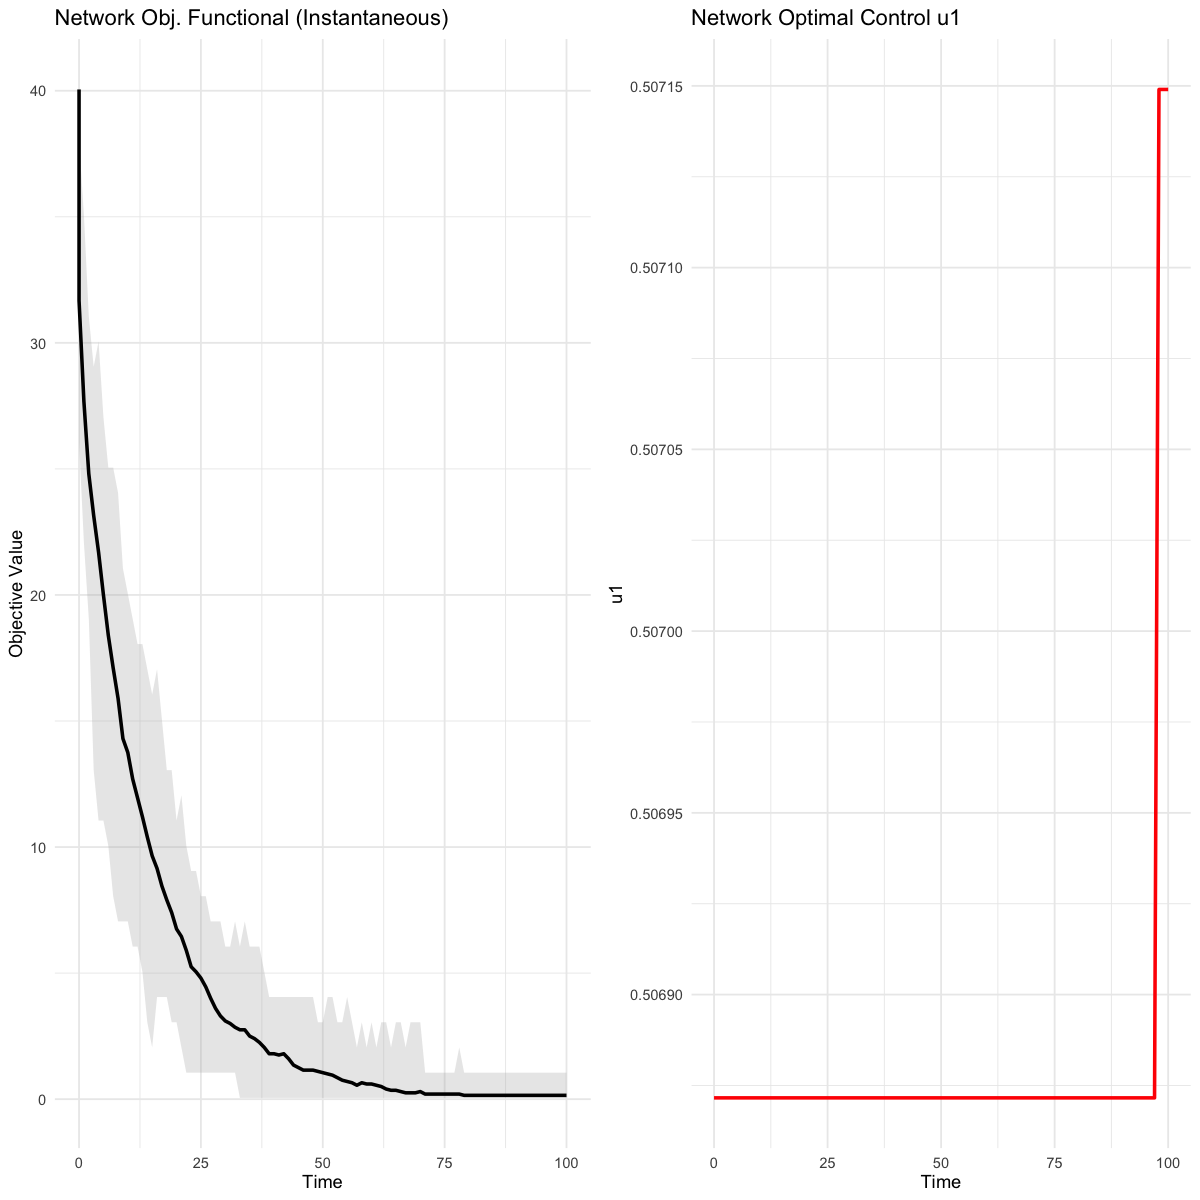

Network-based optimal control: Total objective functional = 437.882 


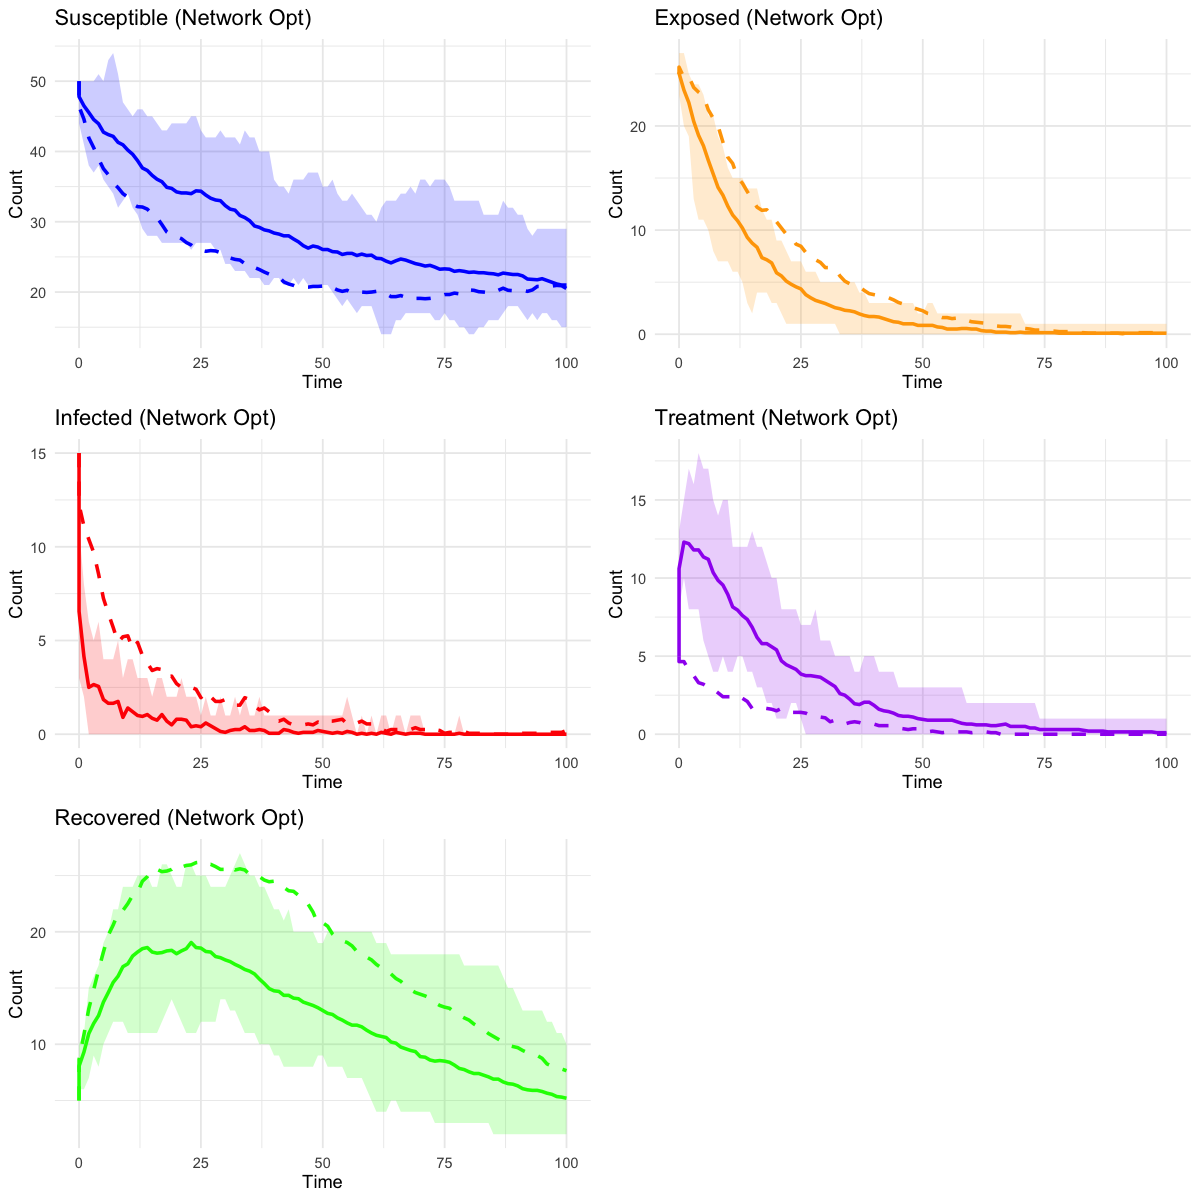

In [34]:
# --- Network simulation results with shaded min/max area (Network-based Optimal Control) ---
# Ensure u1_profile_opt matches df_avg$time length
# Use the avg/min/max from results_df
df_avg <- results_df$avg
df_min <- results_df$min
df_max <- results_df$max
# Use the avg from results_df_no_control for comparison
df_avg_no_control <- results_df_no_control$avg

if (length(u1_profile_opt) < length(df_avg$time)) {
  u1_profile_opt <- c(u1_profile_opt, rep(tail(u1_profile_opt, 1), length(df_avg$time) - length(u1_profile_opt)))
} else if (length(u1_profile_opt) > length(df_avg$time)) {
  u1_profile_opt <- u1_profile_opt[seq_along(df_avg$time)]
}


# 1. Objective functional and optimal control profile (average only)
df_obj <- data.frame(
  time = df_avg$time,
  obj_inst = df_avg$E + df_avg$I + df_avg$control_cost
)
df_obj_minmax <- data.frame(
  time = df_avg$time,
  min = df_min$E + df_min$I + df_min$control_cost,
  max = df_max$E + df_max$I + df_max$control_cost,
  avg = df_avg$E + df_avg$I + df_avg$control_cost
)

# Use the optimized control profile if available
if (exists("u1_profile_opt")) {
  df_u1 <- data.frame(time = df_avg$time, u1 = u1_profile_opt)
} else {
  stop("u1_profile_opt not found. Run the optimizer first.")
}

p_obj <- ggplot(df_obj_minmax, aes(x = time)) +
  geom_ribbon(aes(ymin = min, ymax = max), fill = "gray70", alpha = 0.3) +
  geom_line(aes(y = avg), color = "black", size = 1) +
  labs(title = "Network Obj. Functional (Instantaneous)", x = "Time", y = "Objective Value") +
  theme_minimal()

p_u1 <- ggplot(df_u1, aes(x = time, y = u1)) +
  geom_line(color = "red", size = 1) +
  labs(title = "Network Optimal Control u1", x = "Time", y = "u1") +
  theme_minimal()

gridExtra::grid.arrange(p_obj, p_u1, ncol = 2)

# 2. SEITR compartments with shaded min/max area
plot_compartment_band <- function(df_avg, df_min, df_max, df_avg_no_control, comp, color, title) {
  df <- data.frame(
    time = df_avg$time,
    avg = df_avg[[comp]],
    min = df_min[[comp]],
    max = df_max[[comp]],
    avg_no_control = df_avg_no_control[[comp]]
  )
  ggplot(df, aes(x = time)) +
    geom_ribbon(aes(ymin = min, ymax = max), fill = color, alpha = 0.2) +
    geom_line(aes(y = avg), color = color, size = 1) +
    geom_line(aes(y = avg_no_control), color = color, linetype = "dashed", size = 1) +
    labs(title = paste0(title, " (Network Opt)"), x = "Time", y = "Count") +
    theme_minimal()
}

p_S <- plot_compartment_band(df_avg, df_min, df_max, df_avg_no_control, "S", "blue", "Susceptible")
p_E <- plot_compartment_band(df_avg, df_min, df_max, df_avg_no_control, "E", "orange", "Exposed")
p_I <- plot_compartment_band(df_avg, df_min, df_max, df_avg_no_control, "I", "red", "Infected")
p_T <- plot_compartment_band(df_avg, df_min, df_max, df_avg_no_control, "T", "purple", "Treatment")
p_R <- plot_compartment_band(df_avg, df_min, df_max, df_avg_no_control, "R", "green", "Recovered")

gridExtra::grid.arrange(p_S, p_E, p_I, p_T, p_R, ncol = 2)

# Print final objective functional value
cat("Network-based optimal control: Total objective functional =", J$J_total, "\n")

Network simulation vs ODE solution with and without Optimal Control

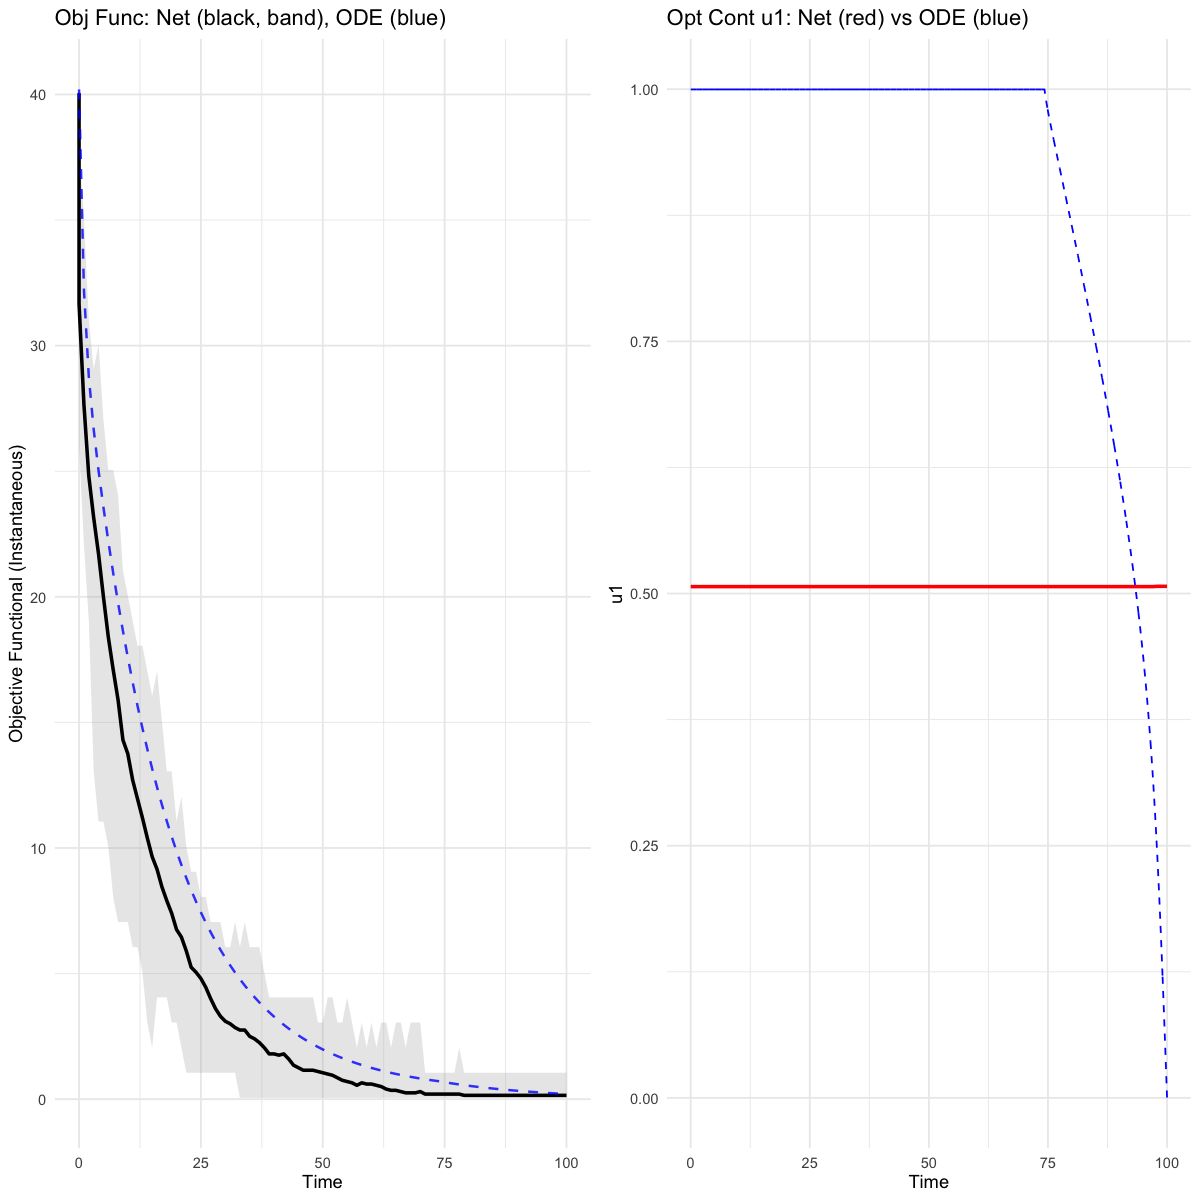

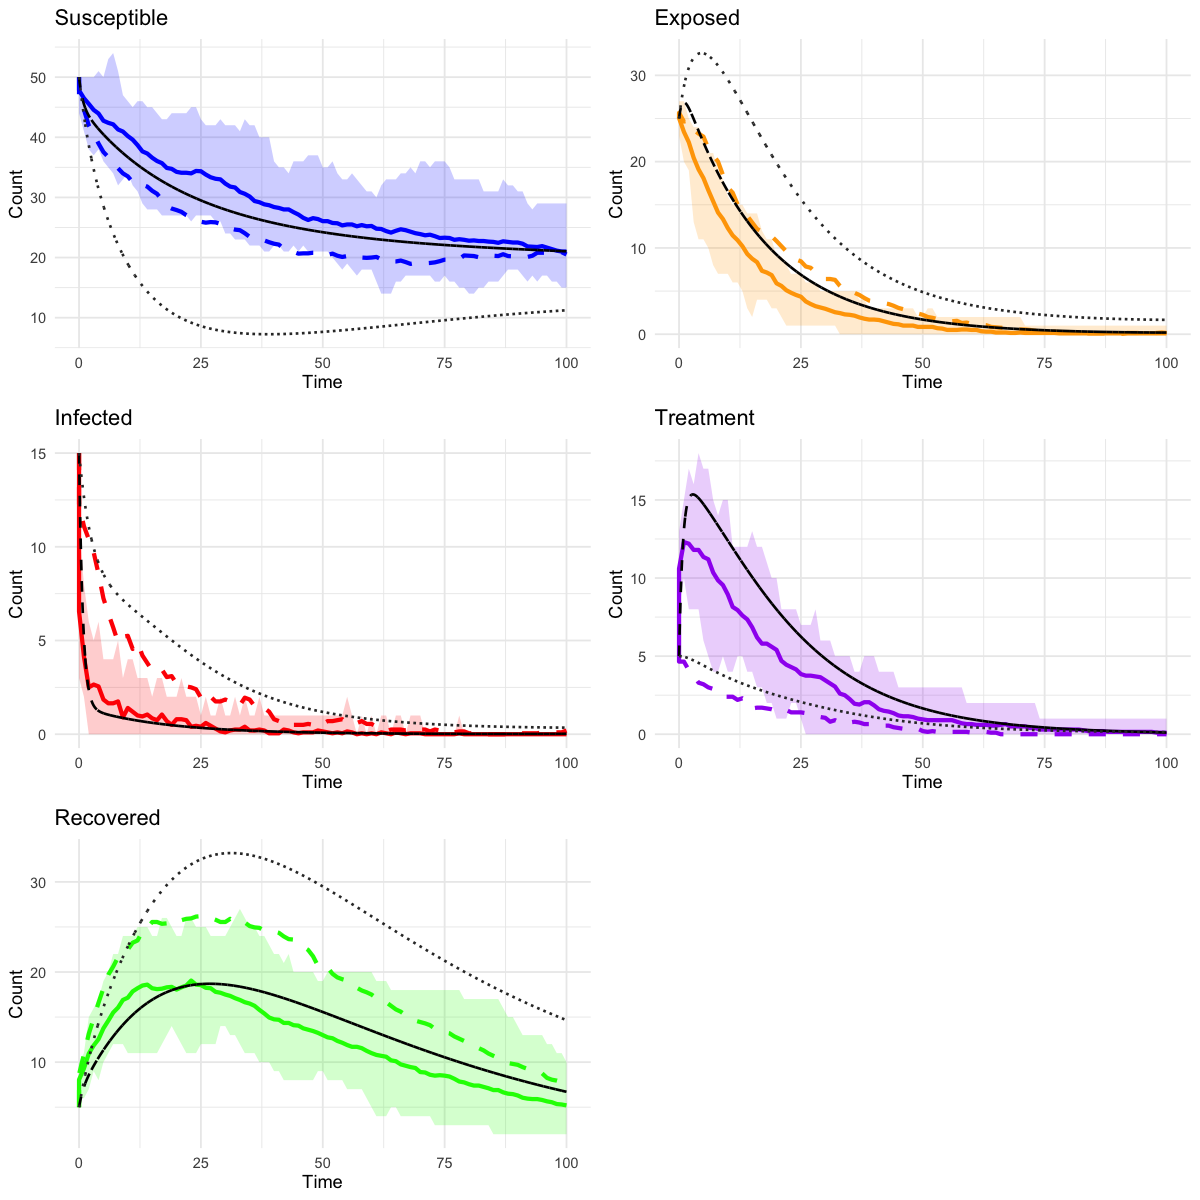

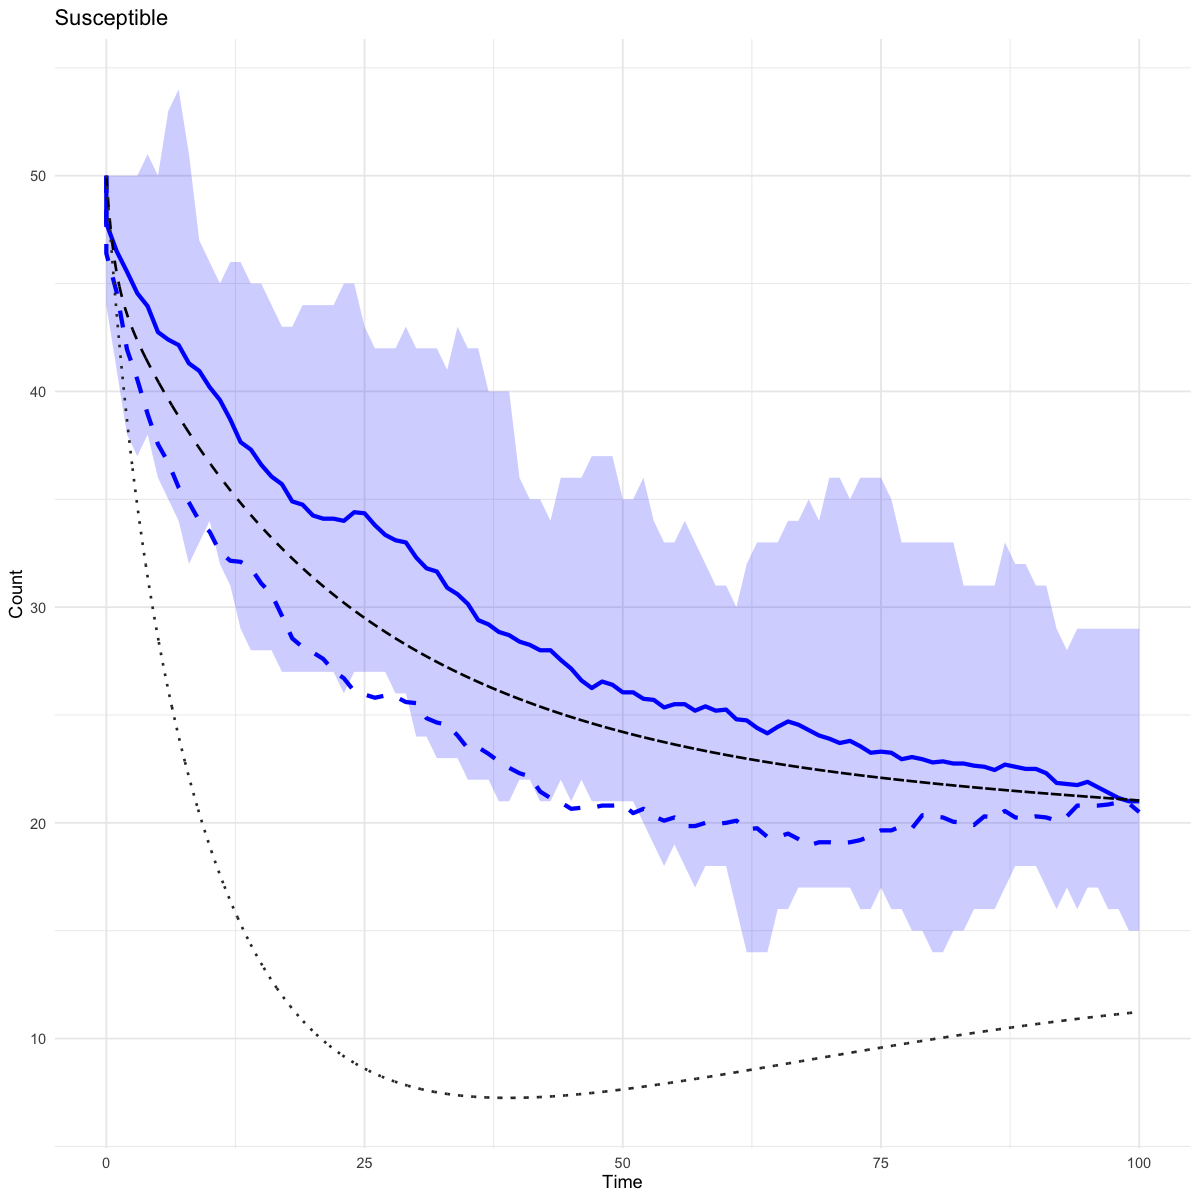

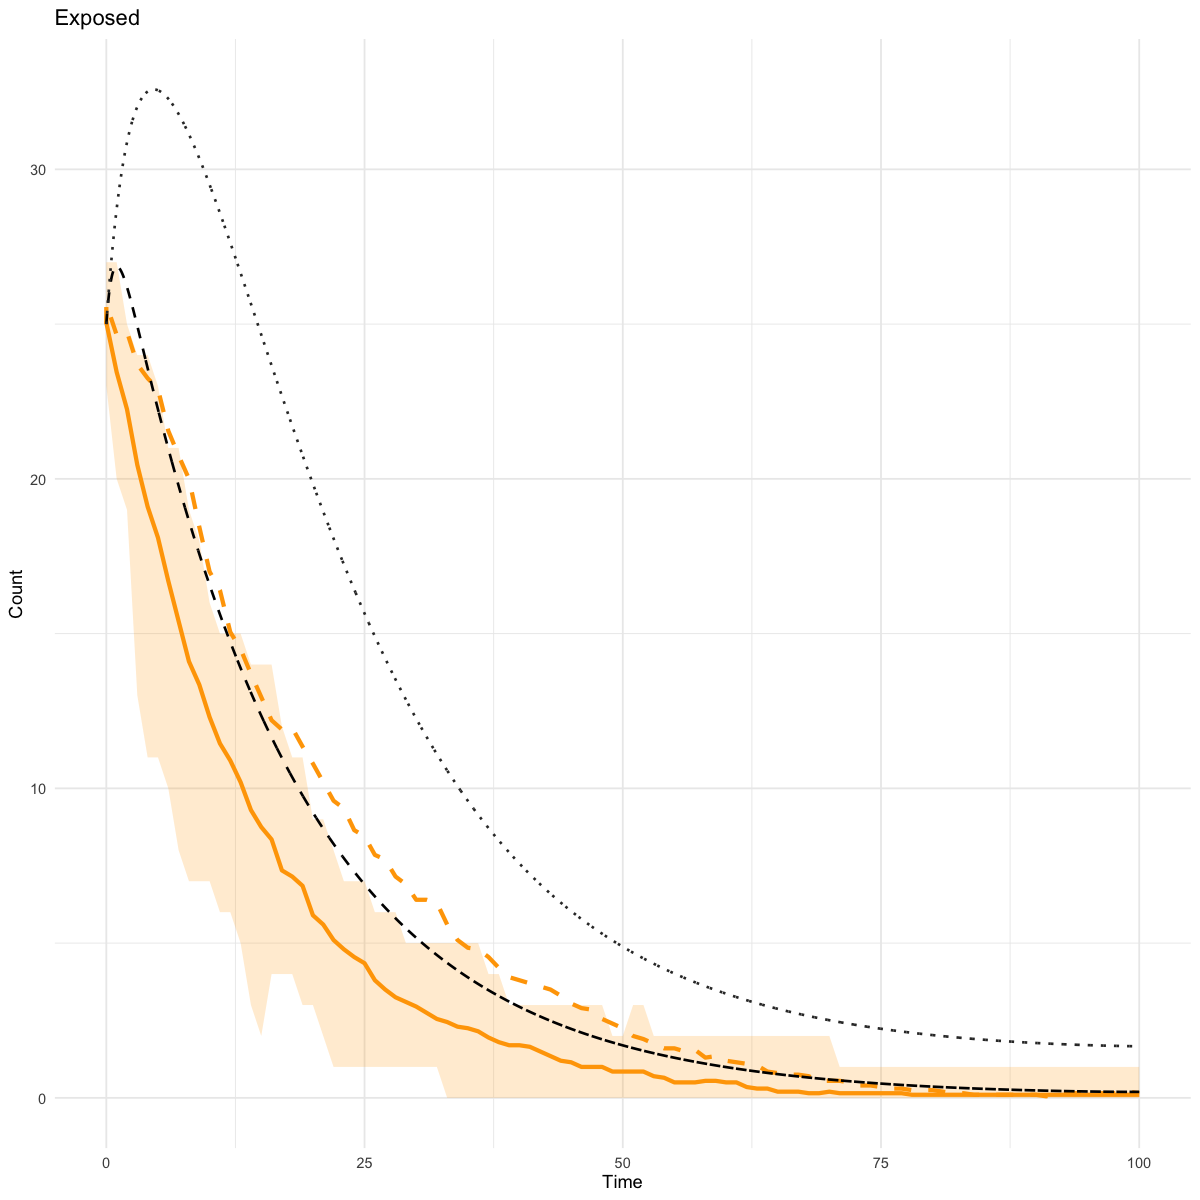

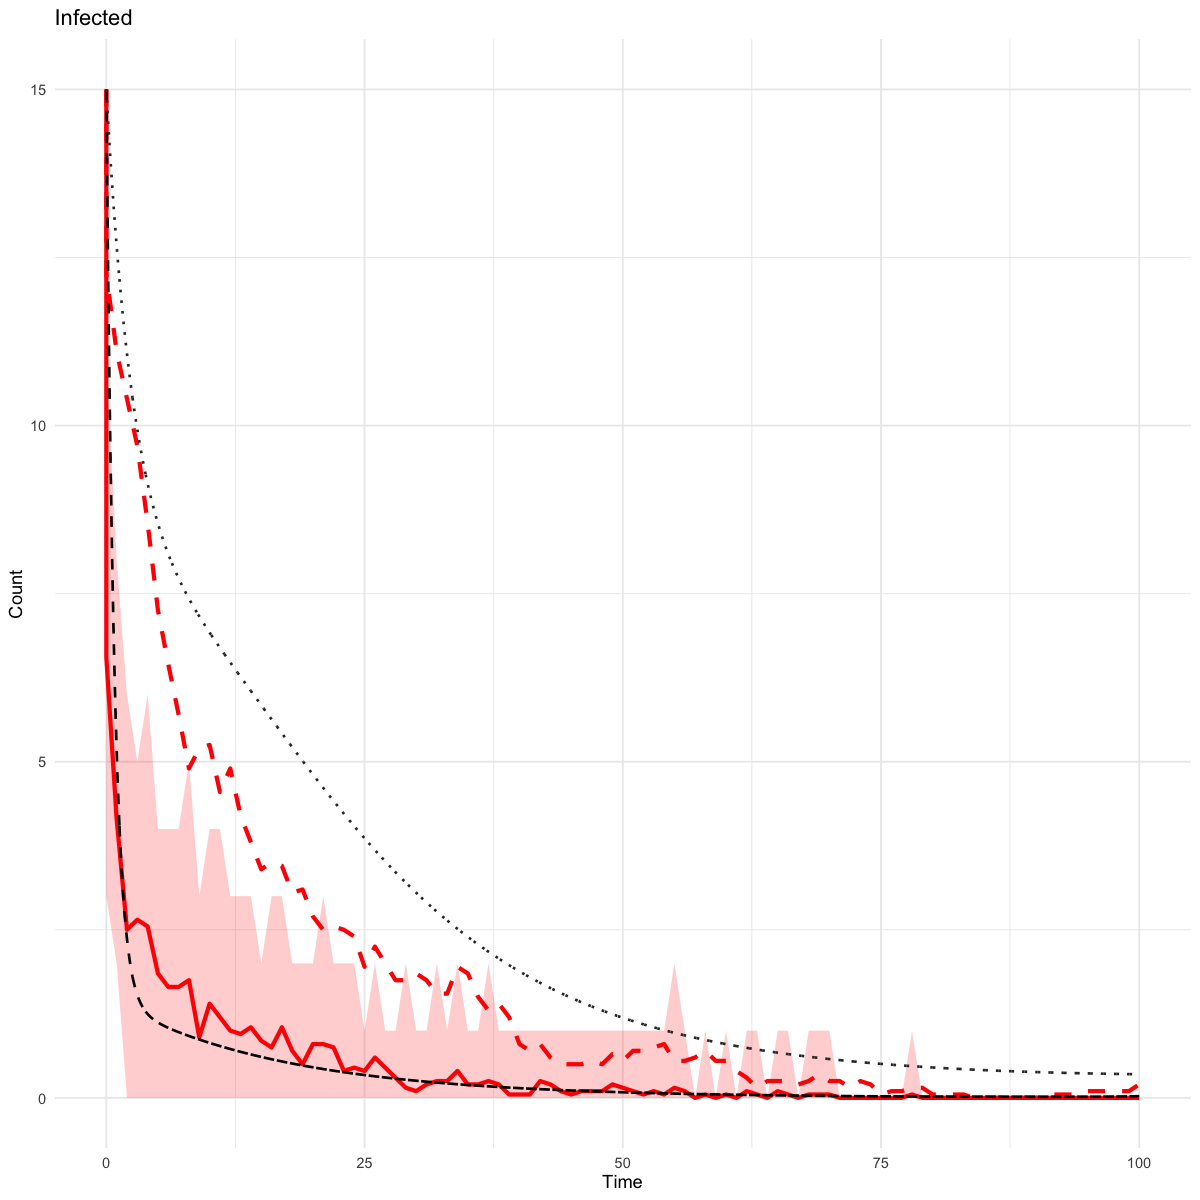

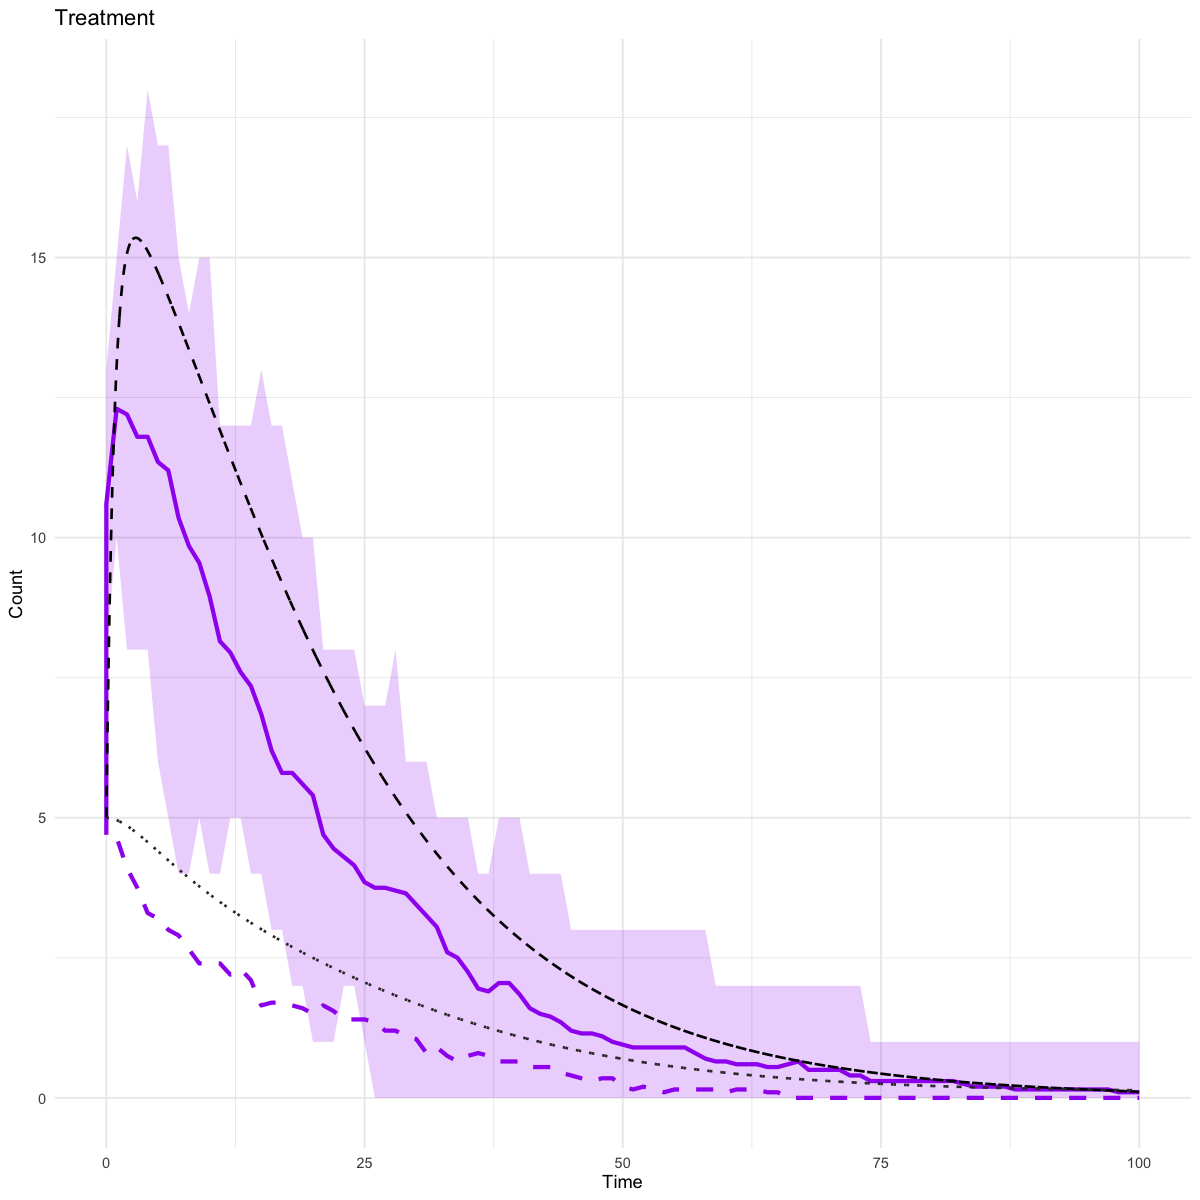

ODE total objective functional (Simpson's rule): 563.314 


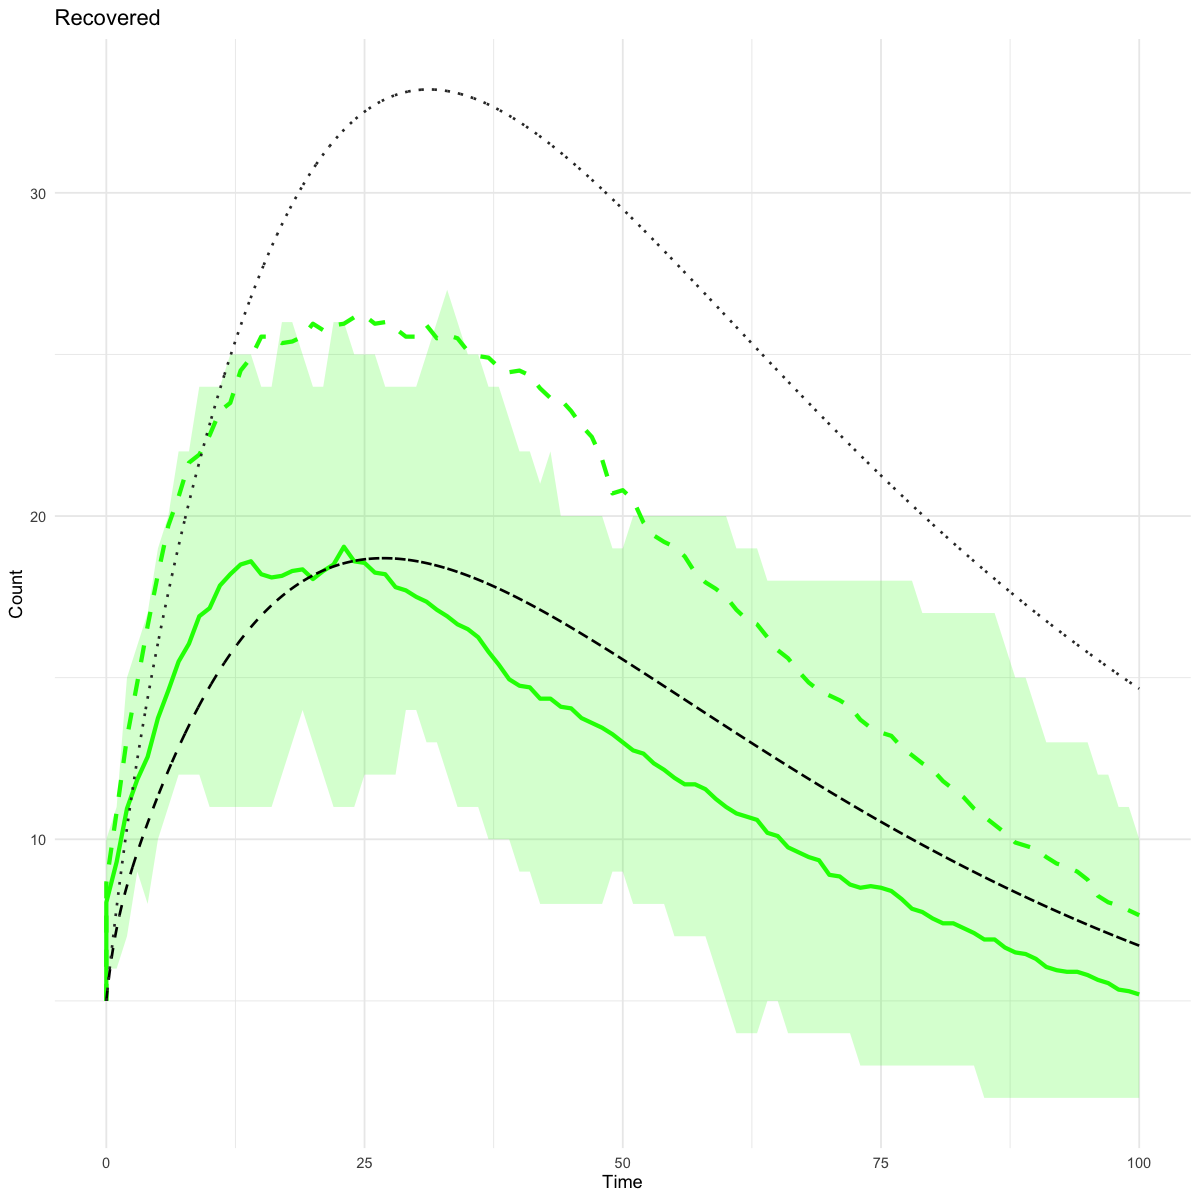

In [35]:
# Overlay ODE results on network simulation plots with min/max shading

# 1. Prepare ODE results as a data.frame for plotting
ode_results <- data.frame(
  time = t,
  S_before = S1,
  E_before = E1,
  I_before = I1,
  T_before = T1,
  R_before = R1,
  S_after = S,
  E_after = E,
  I_after = I,
  T_after = T,
  R_after = R,
  u1 = u1
)

# 2. Calculate ODE objective functional using Simpson's rule (total value)
n_ode <- length(t)
if (n_ode %% 2 == 0) n_ode <- n_ode - 1
ode_times <- t[1:n_ode]
E_ode <- E[1:n_ode]
I_ode <- I[1:n_ode]
u1_ode <- u1[1:n_ode]
w1 <- 0.2
control_cost_ode <- w1 * u1_ode^2
weights <- rep(2, n_ode); weights[1] <- weights[n_ode] <- 1; weights[seq(2, n_ode-1, by=2)] <- 4
h_ode <- mean(diff(ode_times))
J_ode_inst <- E_ode + I_ode + control_cost_ode
J_ode_total <- (h_ode/3) * sum(weights * J_ode_inst)

# 3. Interpolate ODE objective functional to network time grid
J_ode_interp <- approx(x = ode_times, y = J_ode_inst, xout = df_avg$time, rule = 2)$y

# 4. Prepare network objective functional with min/max bands
df_obj_minmax <- data.frame(
  time = df_avg$time,
  min = df_min$E + df_min$I + df_min$control_cost,
  max = df_max$E + df_max$I + df_max$control_cost,
  avg = df_avg$E + df_avg$I + df_avg$control_cost,
  ode_obj_inst = J_ode_interp
)

df_avg_no_control <- results_df_no_control$avg

p_obj <- ggplot(df_obj_minmax, aes(x = time)) +
  geom_ribbon(aes(ymin = min, ymax = max), fill = "gray70", alpha = 0.3) +
  geom_line(aes(y = avg), color = "black", size = 1) +
  geom_line(aes(y = ode_obj_inst), color = "blue", size = 0.7, linetype = "dashed", alpha = 0.8) +
  labs(title = "Obj Func: Net (black, band), ODE (blue)", x = "Time", y = "Objective Functional (Instantaneous)") +
  theme_minimal()

# 5. Optimal control profile
df_u1 <- data.frame(time = df_avg$time, u1 = u1_profile_opt)
df_u1_ode <- data.frame(time = t, u1 = u1)
p_u1 <- ggplot(df_u1, aes(x = time, y = u1)) +
  geom_line(color = "red", size = 1) +
  geom_line(data = df_u1_ode, aes(x = time, y = u1), color = "blue", size = 0.5, linetype = "dashed") +
  labs(title = "Opt Cont u1: Net (red) vs ODE (blue)", x = "Time", y = "u1") +
  theme_minimal()

gridExtra::grid.arrange(p_obj, p_u1, ncol = 2)

# 6. SEITR compartments: overlay ODE before/after optimization, add min/max bands
plot_compartment_band_overlay <- function(df_avg, df_min, df_max, df_avg_no_control, comp, color, title, ode_results, after, before) {
  df <- data.frame(
    time = df_avg$time,
    avg = df_avg[[comp]],
    min = df_min[[comp]],
    max = df_max[[comp]],
    avg_no_control = df_avg_no_control[[comp]]
  )
  ggplot(df, aes(x = time)) +
    geom_ribbon(aes(ymin = min, ymax = max), fill = color, alpha = 0.2) +
    geom_line(aes(y = avg), color = color, size = 1.2) +
    geom_line(aes(y = avg_no_control), color = color, linetype = "dashed", size = 1.2) +
    geom_line(data = ode_results, aes(x = time, y = !!as.name(after)), color = "black", size = 0.75, linetype = "dashed") +
    geom_line(data = ode_results, aes(x = time, y = !!as.name(before)), color = "gray20", size = 0.75, linetype = "dotted") +
    labs(title = title, x = "Time", y = "Count") +
    theme_minimal()
}

p_S <- plot_compartment_band_overlay(df_avg, df_min, df_max, df_avg_no_control, "S", "blue", "Susceptible", ode_results, "S_after", "S_before")
p_E <- plot_compartment_band_overlay(df_avg, df_min, df_max, df_avg_no_control, "E", "orange", "Exposed", ode_results, "E_after", "E_before")
p_I <- plot_compartment_band_overlay(df_avg, df_min, df_max, df_avg_no_control, "I", "red", "Infected", ode_results, "I_after", "I_before")
p_T <- plot_compartment_band_overlay(df_avg, df_min, df_max, df_avg_no_control, "T", "purple", "Treatment", ode_results, "T_after", "T_before")
p_R <- plot_compartment_band_overlay(df_avg, df_min, df_max, df_avg_no_control, "R", "green", "Recovered", ode_results, "R_after", "R_before")

gridExtra::grid.arrange(p_S, p_E, p_I, p_T, p_R, ncol = 2)

print(p_S)
print(p_E)
print(p_I)
print(p_T)
print(p_R)

# Print ODE total objective functional value
cat("ODE total objective functional (Simpson's rule):", J_ode_total, "\n")

In [36]:
compartments <- c("S", "E", "I", "T", "R")
msd_list <- numeric(length(compartments))
rmsd_list <- numeric(length(compartments))
norm_rmsd_list <- numeric(length(compartments))

for (i in seq_along(compartments)) {
  comp <- compartments[i]
  ode_interp <- approx(x = ode_results$time, y = ode_results[[paste0(comp, "_after")]], xout = df_avg$time, rule = 2)$y
  net_avg <- df_avg[[comp]]
  msd <- mean((net_avg - ode_interp)^2)
  rmsd <- sqrt(msd)
  #Added max
  norm_factor <- max(1, mean(net_avg)) # You can also use max(net_avg) or range(net_avg)
  norm_rmsd <- rmsd / norm_factor
  msd_list[i] <- msd
  rmsd_list[i] <- rmsd
  norm_rmsd_list[i] <- norm_rmsd
  cat(sprintf("Compartment: %s | MSD: %.4f | RMSD: %.4f | Normalized RMSD: %.4f\n", comp, msd, rmsd, norm_rmsd))
}

Compartment: S | MSD: 5.9781 | RMSD: 2.4450 | Normalized RMSD: 0.0839
Compartment: E | MSD: 4.1901 | RMSD: 2.0470 | Normalized RMSD: 0.5251
Compartment: I | MSD: 0.7780 | RMSD: 0.8820 | Normalized RMSD: 0.8820
Compartment: T | MSD: 3.0886 | RMSD: 1.7574 | Normalized RMSD: 0.6224
Compartment: R | MSD: 4.2618 | RMSD: 2.0644 | Normalized RMSD: 0.1694


Network size 100, BA, p = 0.3

Uses the same ODE results from the previous experiment

In [41]:
# Define model parameters and initial conditions
Lambda    <- 0.4         # Recruitment rate
beta1     <- 0.9         # Transmission rate (S to E)
beta2     <- 0.059       # Progression rate (E to I)
beta3     <- 0.2         # Recovery rate (I to R)
alpha1    <- 0.03        # Treatment rate (I to T)
alpha2    <- 0.055       # Recovery rate from treatment (T to R)
delta_I   <- 0.03        # Disease-induced death rate (I)
delta_T   <- 0.03        # Disease-induced death rate (T)
mu        <- 0.02        # Natural death rate

# Control parameters
w1        <- 0.2         # Weight for control cost
zeta      <- 1           # Upper bound for control
# Simulation time setup
t_max     <- 100
dt        <- 1           # Time step for network simulation
times     <- seq(0, t_max, by = dt)
# Initial conditions
init_S    <- 50
init_E    <- 25
init_I    <- 15
init_T    <- 5
init_R    <- 5
init_N    <- init_S + init_E + init_I + init_T + init_R

# Network parameters
network_type <- "BA"     # Network type: ER, BA, WS, LN, RR
n            <- 100       # Initial number of nodes
n_par1       <- 0.3      # Network-specific parameter 1
n_par2       <- 10       # Network-specific parameter 2

# Interpolate ODE optimal control to network simulation time grid for initial experiment
# u1_profile <- approx(x = t, y = u1, xout = seq(0, t_max+1, by = dt), rule = 2)$y

Calculate u1_profile on network simulations

In [42]:
# Set up parallel backend
n_cores <- detectCores() - 3
cl <- makeCluster(n_cores)
setDefaultCluster(cl)
clusterEvalQ(cl, library(igraph))

# Make RNG streams consistent across calls
RNGkind("L'Ecuyer-CMRG")

# Parameterization
K <- 12
total_steps <- length(seq(0, t_max, by = dt))
interval_length <- ceiling(total_steps / K)

expand_u1 <- function(params_seg, total_length, interval_length) {
  prof <- rep(params_seg, each = interval_length)[1:total_length]
  pmin(zeta, pmax(0, prof))
}

# Bounded transform (unconstrained -> [0, zeta])
to_un <- function(u) qlogis(pmin(pmax(u / zeta, 1e-6), 1 - 1e-6))
from_un <- function(x) zeta * plogis(x)

# Objective: use CRN and heavier averaging during optimization
objective_wrapper <- function(params_un) {
  set.seed(12345)  # CRN for fair comparisons across parameter sets
  u1_seg <- from_un(params_un)
  u1_profile <- expand_u1(u1_seg, total_steps, interval_length)
  # Call simulator directly to control averaging
  results <- run_seitr_network_simulation(
    network_type = network_type, n = n, n_par1 = n_par1, n_par2 = n_par2,
    Lambda = Lambda, beta1 = beta1, beta2 = beta2, beta3 = beta3, alpha1 = alpha1, alpha2 = alpha2,
    delta_I = delta_I, delta_T = delta_T, mu = mu,
    init_S = init_S, init_E = init_E, init_I = init_I, init_T = init_T, init_R = init_R,
    t_max = t_max, u1_profile = u1_profile, num_exp = 40, verbose = FALSE
  )
  calculate_objective_functional(results$avg)$J_total
}

# Initialize around previous constant 0.03
init_seg <- rep(0.03, K)
init_params_un <- to_un(init_seg)

# Export everything used by workers
clusterExport(cl, varlist = c(
  "expand_u1", "objective_wrapper", "from_un", "to_un",
  "K", "interval_length", "total_steps", "zeta",
  "run_seitr_network_simulation", "calculate_objective_functional",
  "generate_network", "initialize_node_statuses", "update_node_status", "connect_new_nodes",
  "network_type", "n", "n_par1", "n_par2",
  "Lambda", "beta1", "beta2", "beta3", "alpha1", "alpha2",
  "delta_I", "delta_T", "mu", "init_S", "init_E", "init_I", "init_T", "init_R", "t_max", "dt", "w1"
))

# Run optimization
result <- optimParallel(
  par = init_seg,
  fn = objective_wrapper,
  method = "L-BFGS-B",
  lower = 0,
  upper = zeta,
  control = list(trace = 1, maxit = 2000, pgtol = 1e-6),
  cl = cl
)

# Build optimized profile back on the simulation grid
u1_opt_params_un <- as.numeric(result$par)
u1_opt_seg       <- from_un(u1_opt_params_un)
u1_profile_opt   <- expand_u1(u1_opt_seg, total_steps, interval_length)

stopCluster(cl)

[[1]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[3]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[4]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[5]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[6]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[7]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[8]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"

final  value 480.459498 
stopped after 2 iterations


Run the experiments

In [43]:
# Run the SEITR network simulation with the optimal control profile

results_df <- run_seitr_network_simulation(
  network_type = network_type, n = n, n_par1 = n_par1, n_par2 = n_par2,
  Lambda = Lambda, beta1 = beta1, beta2 = beta2, beta3 = beta3, alpha1 = alpha1, alpha2 = alpha2,
  delta_I = delta_I, delta_T = delta_T, mu = mu,
  init_S = init_S, init_E = init_E, init_I = init_I, init_T = init_T, init_R = init_R,
  t_max = t_max, u1_profile = u1_profile_opt, num_exp = 20
)

J <- calculate_objective_functional(results_df$avg)

In [44]:
# Run the SEITR network simulation with the optimal control profile
# but no control (u1 = 0) for comparison
u1_profile_no_control <- rep(0, total_steps)

results_df_no_control <- run_seitr_network_simulation(
  network_type = network_type, n = n, n_par1 = n_par1, n_par2 = n_par2,
  Lambda = Lambda, beta1 = beta1, beta2 = beta2, beta3 = beta3, alpha1 = alpha1, alpha2 = alpha2,
  delta_I = delta_I, delta_T = delta_T, mu = mu,
  init_S = init_S, init_E = init_E, init_I = init_I, init_T = init_T, init_R = init_R,
  t_max = t_max, u1_profile = u1_profile_no_control, num_exp = 20
)

J_no_control <- calculate_objective_functional(results_df_no_control$avg)

Network simulation results

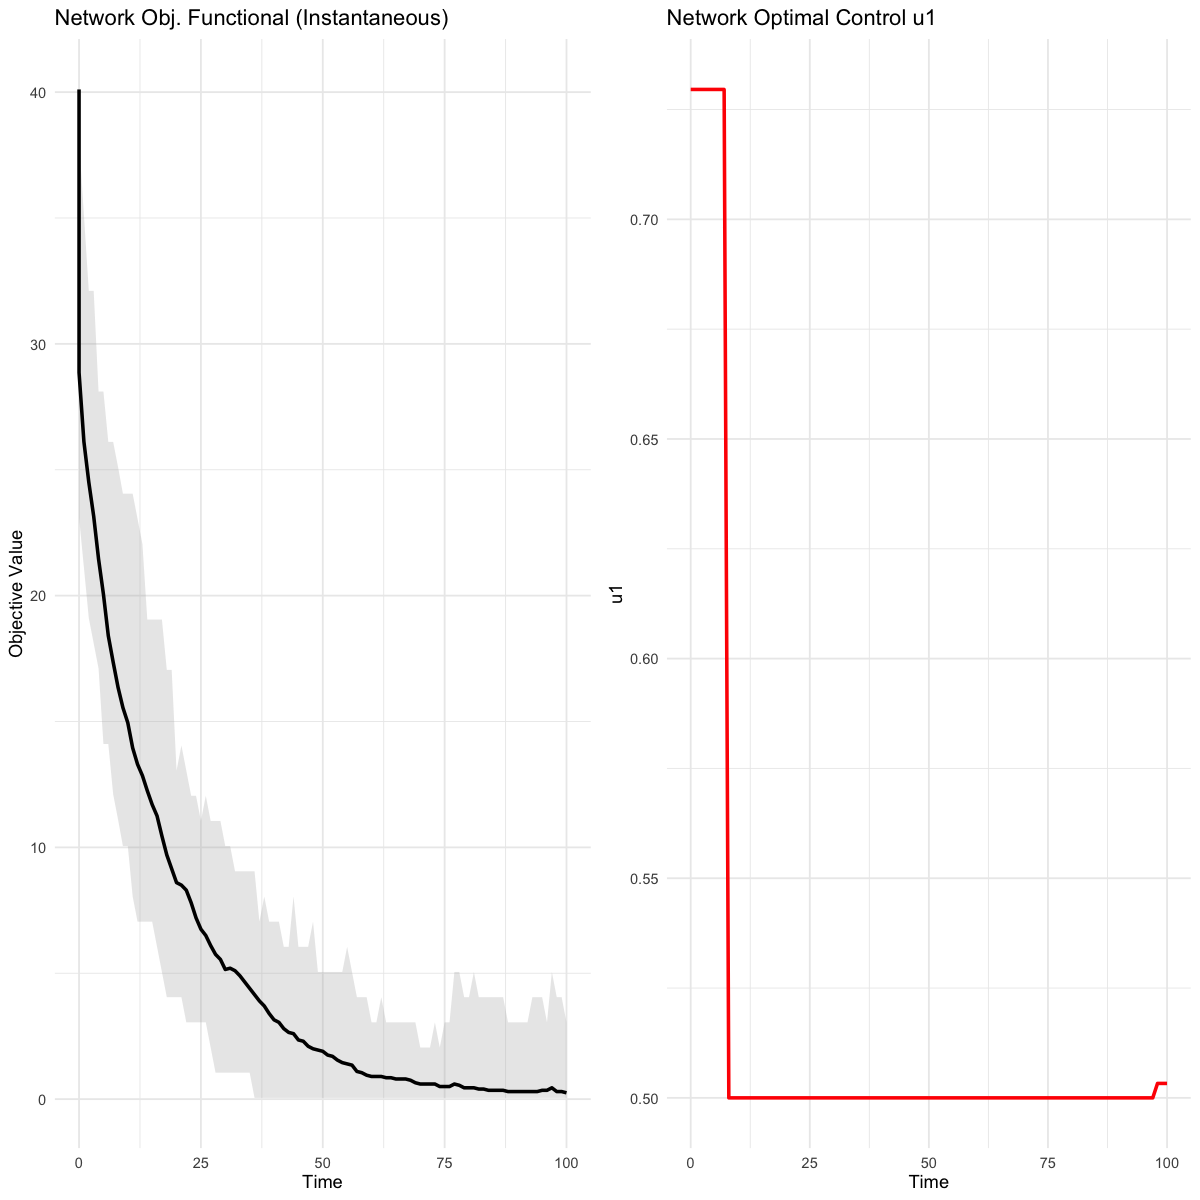

Network-based optimal control: Total objective functional = 519.713 


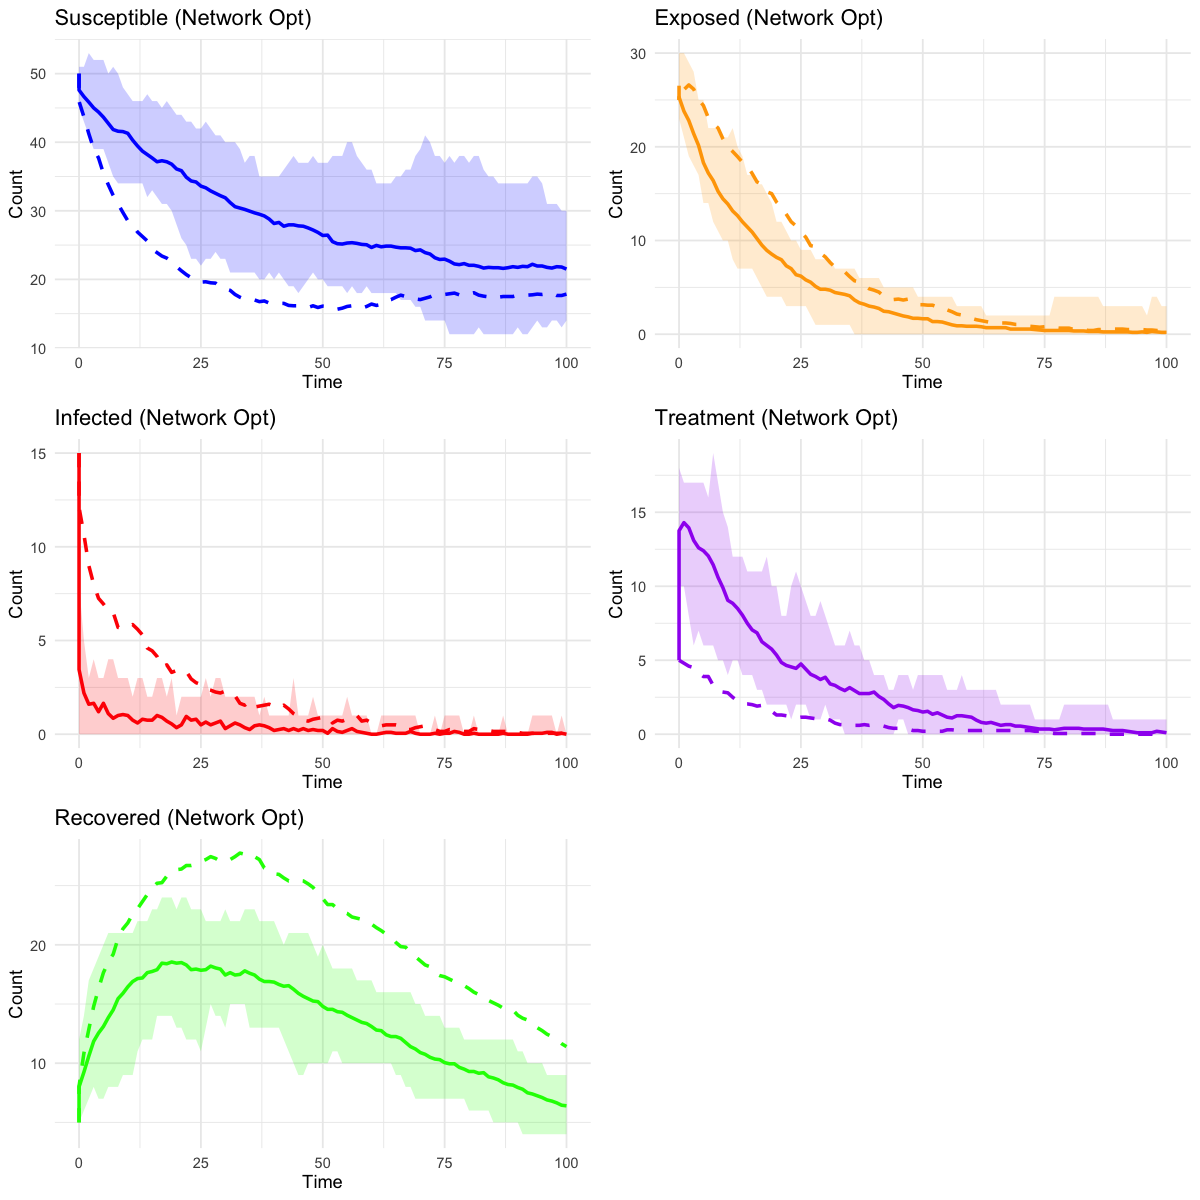

In [45]:
# --- Network simulation results with shaded min/max area (Network-based Optimal Control) ---
# Ensure u1_profile_opt matches df_avg$time length
# Use the avg/min/max from results_df
df_avg <- results_df$avg
df_min <- results_df$min
df_max <- results_df$max
# Use the avg from results_df_no_control for comparison
df_avg_no_control <- results_df_no_control$avg

if (length(u1_profile_opt) < length(df_avg$time)) {
  u1_profile_opt <- c(u1_profile_opt, rep(tail(u1_profile_opt, 1), length(df_avg$time) - length(u1_profile_opt)))
} else if (length(u1_profile_opt) > length(df_avg$time)) {
  u1_profile_opt <- u1_profile_opt[seq_along(df_avg$time)]
}


# 1. Objective functional and optimal control profile (average only)
df_obj <- data.frame(
  time = df_avg$time,
  obj_inst = df_avg$E + df_avg$I + df_avg$control_cost
)
df_obj_minmax <- data.frame(
  time = df_avg$time,
  min = df_min$E + df_min$I + df_min$control_cost,
  max = df_max$E + df_max$I + df_max$control_cost,
  avg = df_avg$E + df_avg$I + df_avg$control_cost
)

# Use the optimized control profile if available
if (exists("u1_profile_opt")) {
  df_u1 <- data.frame(time = df_avg$time, u1 = u1_profile_opt)
} else {
  stop("u1_profile_opt not found. Run the optimizer first.")
}

p_obj <- ggplot(df_obj_minmax, aes(x = time)) +
  geom_ribbon(aes(ymin = min, ymax = max), fill = "gray70", alpha = 0.3) +
  geom_line(aes(y = avg), color = "black", size = 1) +
  labs(title = "Network Obj. Functional (Instantaneous)", x = "Time", y = "Objective Value") +
  theme_minimal()

p_u1 <- ggplot(df_u1, aes(x = time, y = u1)) +
  geom_line(color = "red", size = 1) +
  labs(title = "Network Optimal Control u1", x = "Time", y = "u1") +
  theme_minimal()

gridExtra::grid.arrange(p_obj, p_u1, ncol = 2)

# 2. SEITR compartments with shaded min/max area
plot_compartment_band <- function(df_avg, df_min, df_max, df_avg_no_control, comp, color, title) {
  df <- data.frame(
    time = df_avg$time,
    avg = df_avg[[comp]],
    min = df_min[[comp]],
    max = df_max[[comp]],
    avg_no_control = df_avg_no_control[[comp]]
  )
  ggplot(df, aes(x = time)) +
    geom_ribbon(aes(ymin = min, ymax = max), fill = color, alpha = 0.2) +
    geom_line(aes(y = avg), color = color, size = 1) +
    geom_line(aes(y = avg_no_control), color = color, linetype = "dashed", size = 1) +
    labs(title = paste0(title, " (Network Opt)"), x = "Time", y = "Count") +
    theme_minimal()
}

p_S <- plot_compartment_band(df_avg, df_min, df_max, df_avg_no_control, "S", "blue", "Susceptible")
p_E <- plot_compartment_band(df_avg, df_min, df_max, df_avg_no_control, "E", "orange", "Exposed")
p_I <- plot_compartment_band(df_avg, df_min, df_max, df_avg_no_control, "I", "red", "Infected")
p_T <- plot_compartment_band(df_avg, df_min, df_max, df_avg_no_control, "T", "purple", "Treatment")
p_R <- plot_compartment_band(df_avg, df_min, df_max, df_avg_no_control, "R", "green", "Recovered")

gridExtra::grid.arrange(p_S, p_E, p_I, p_T, p_R, ncol = 2)

# Print final objective functional value
cat("Network-based optimal control: Total objective functional =", J$J_total, "\n")

Network simulation vs ODE solution with and without Optimal Control

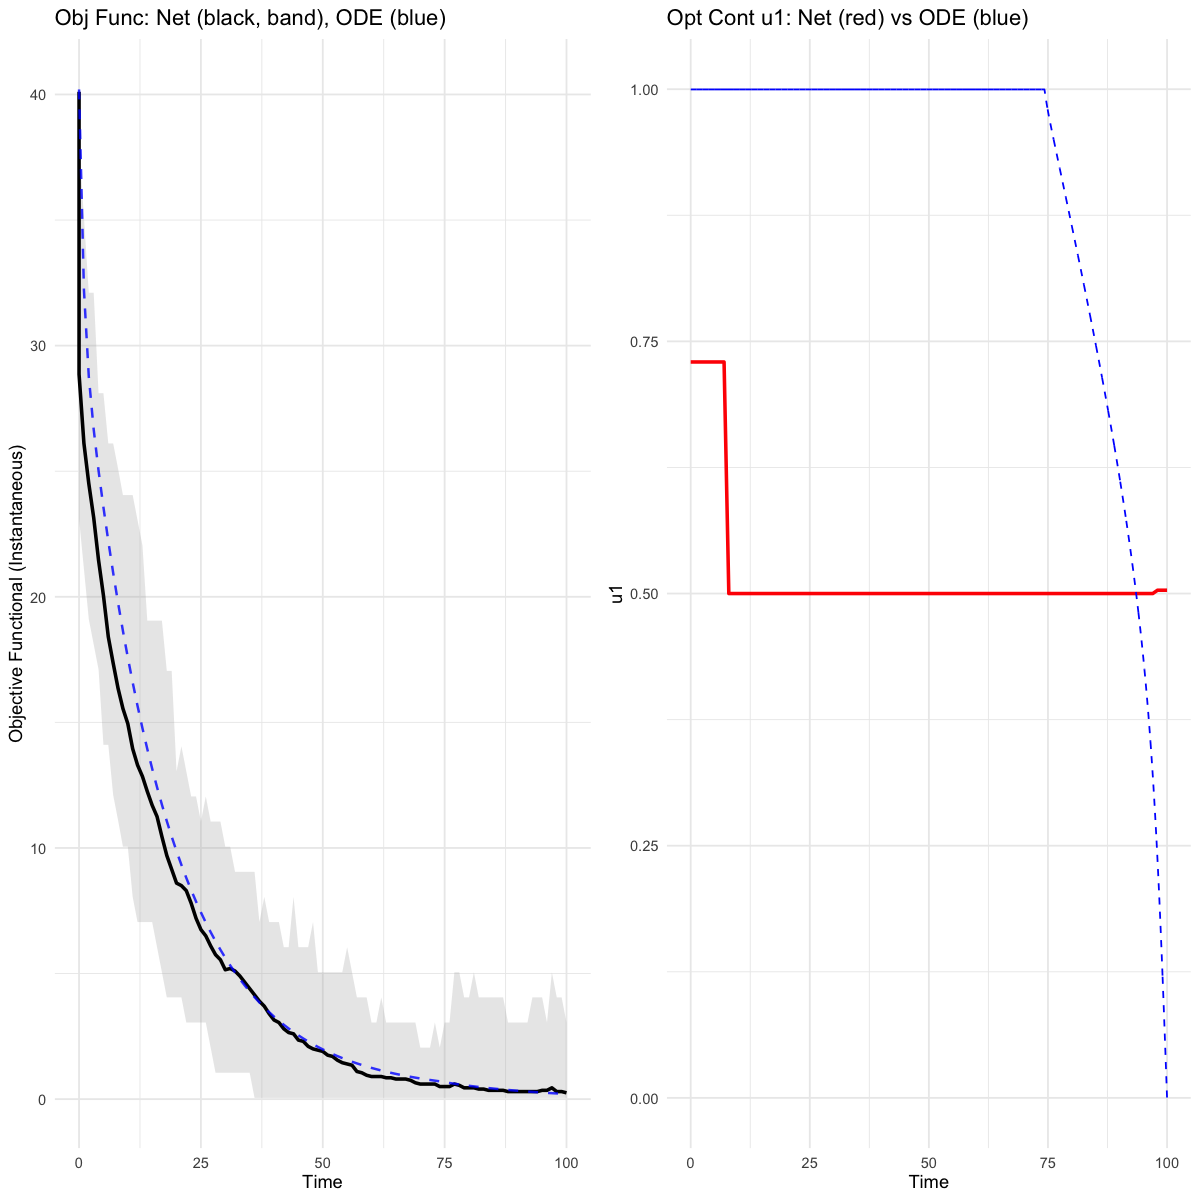

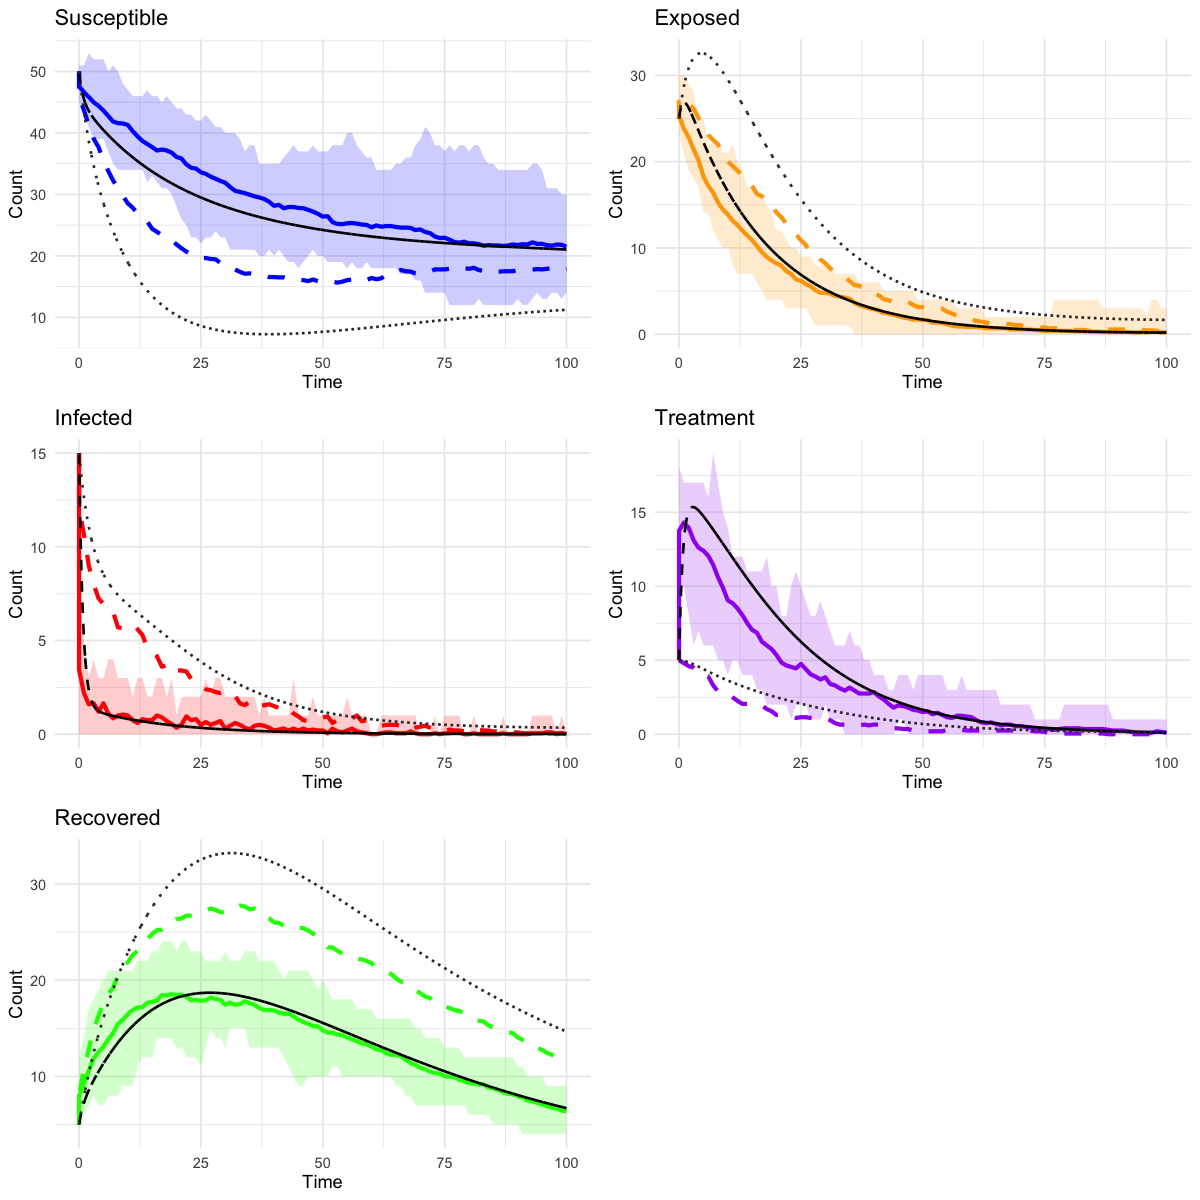

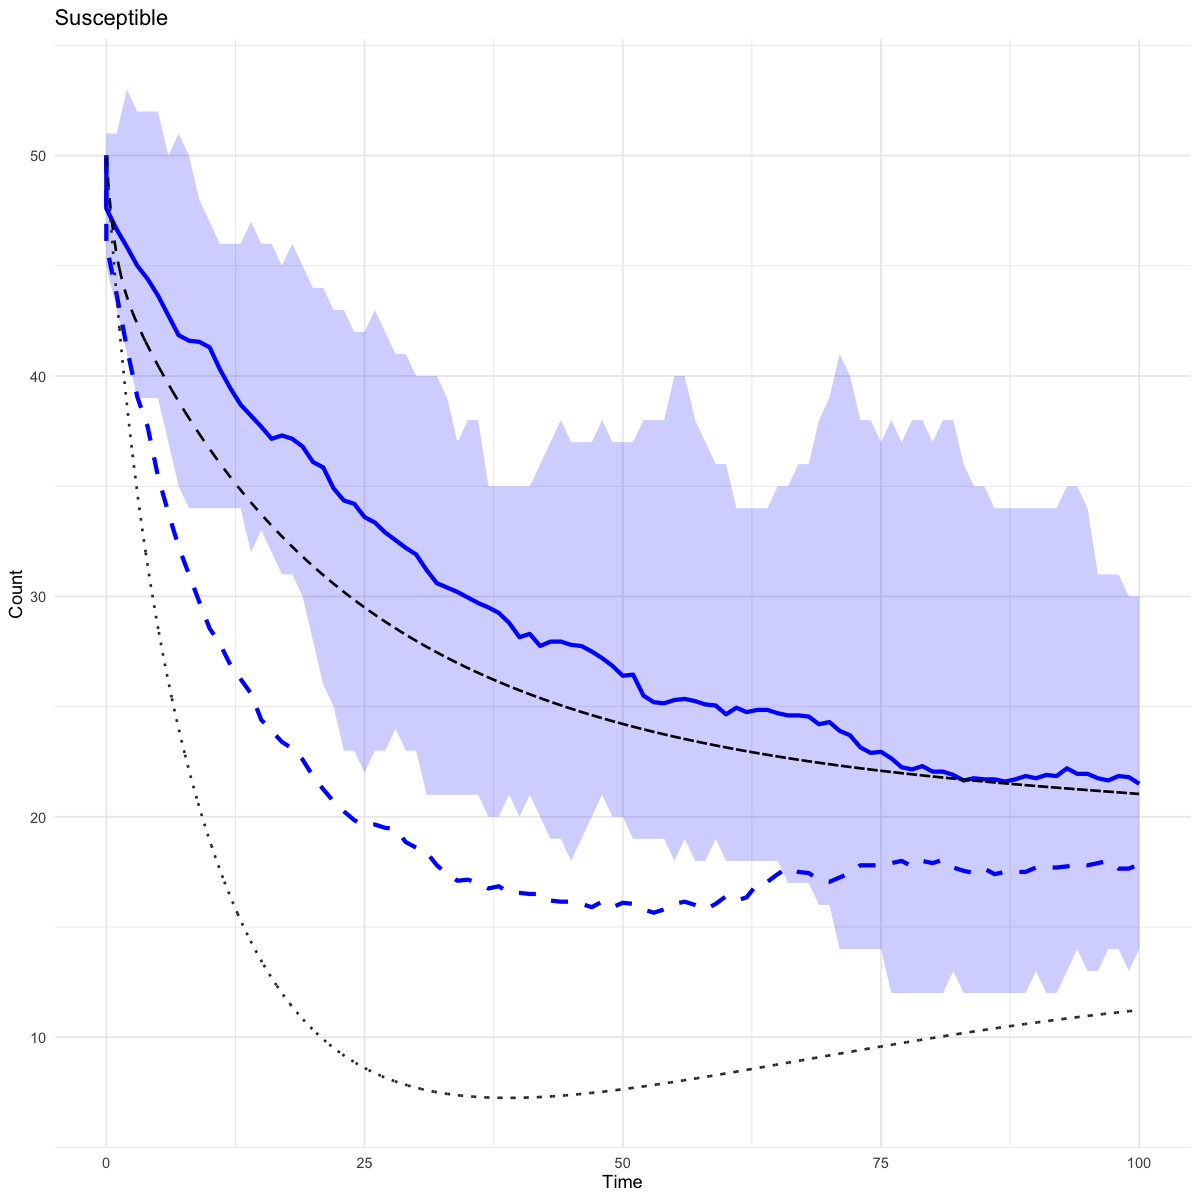

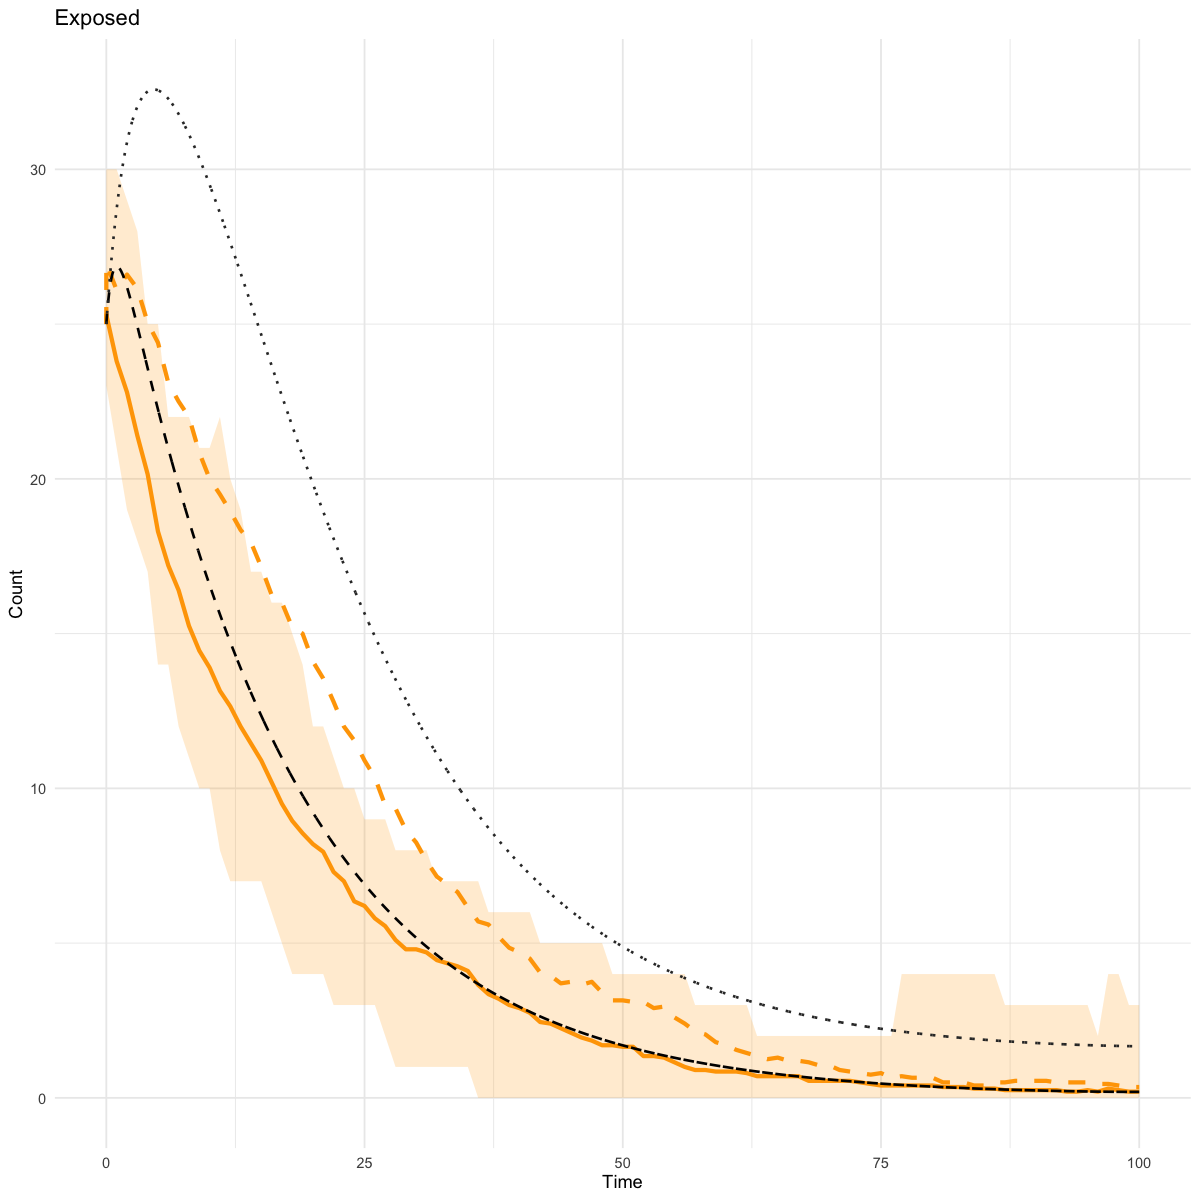

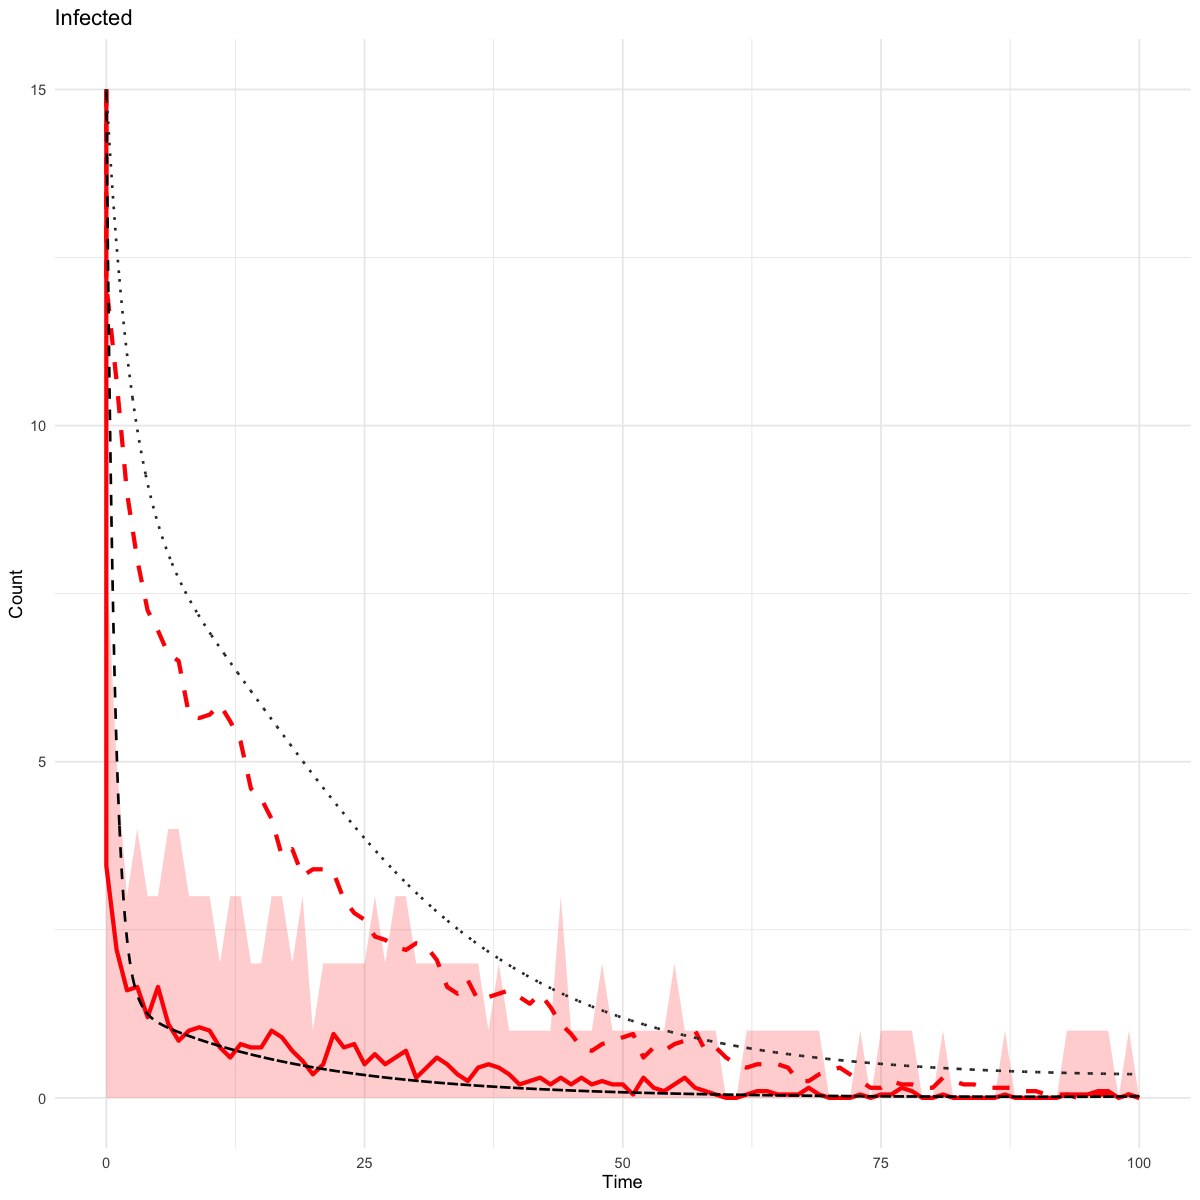

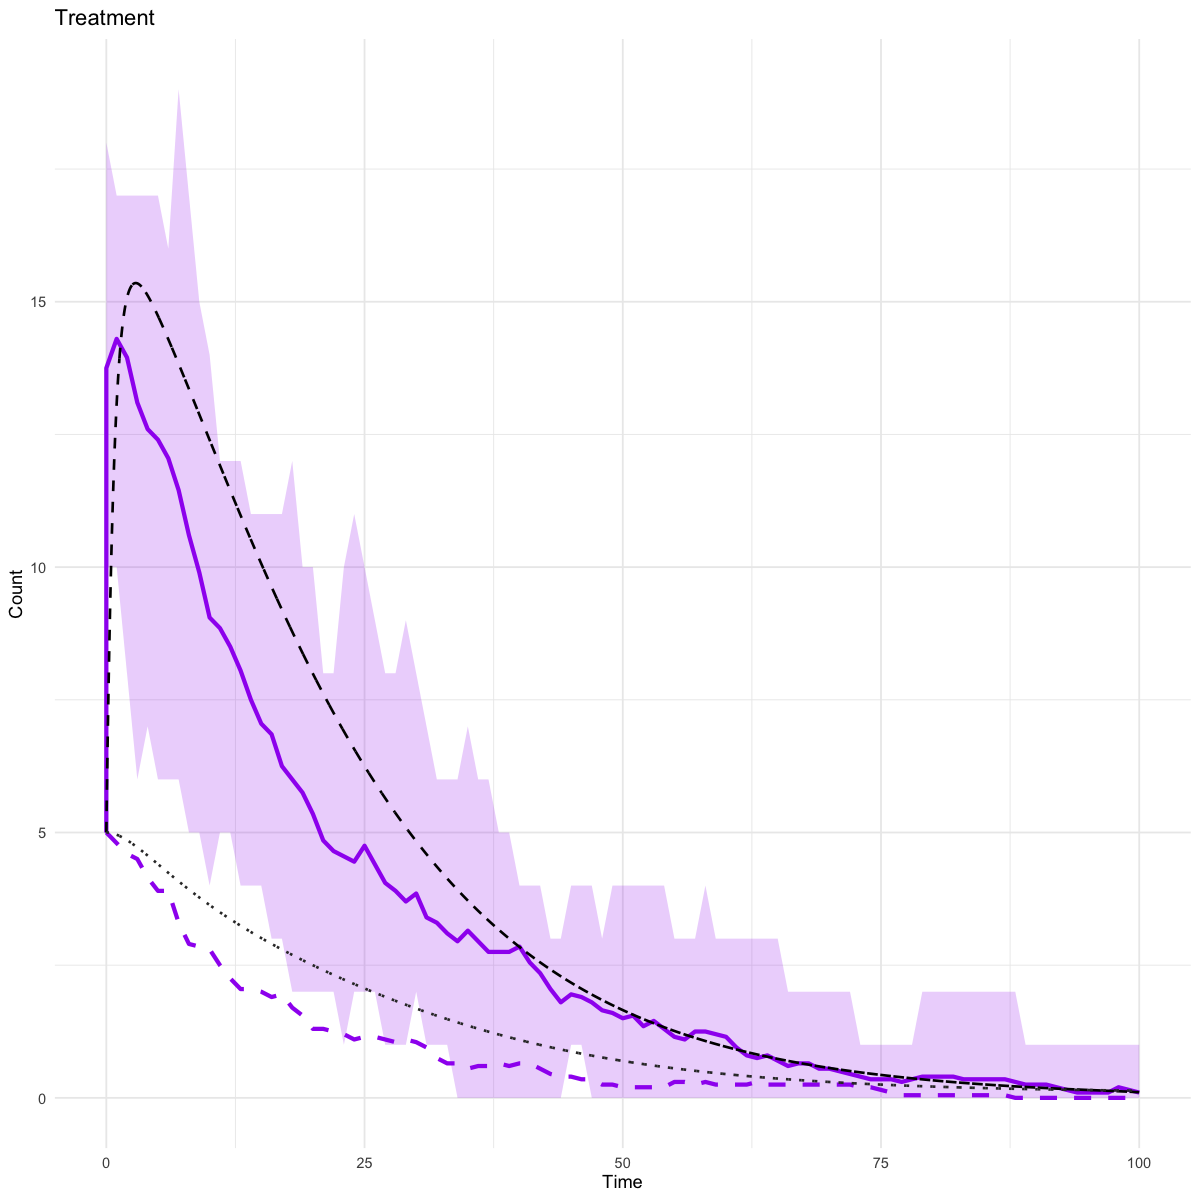

ODE total objective functional (Simpson's rule): 563.314 


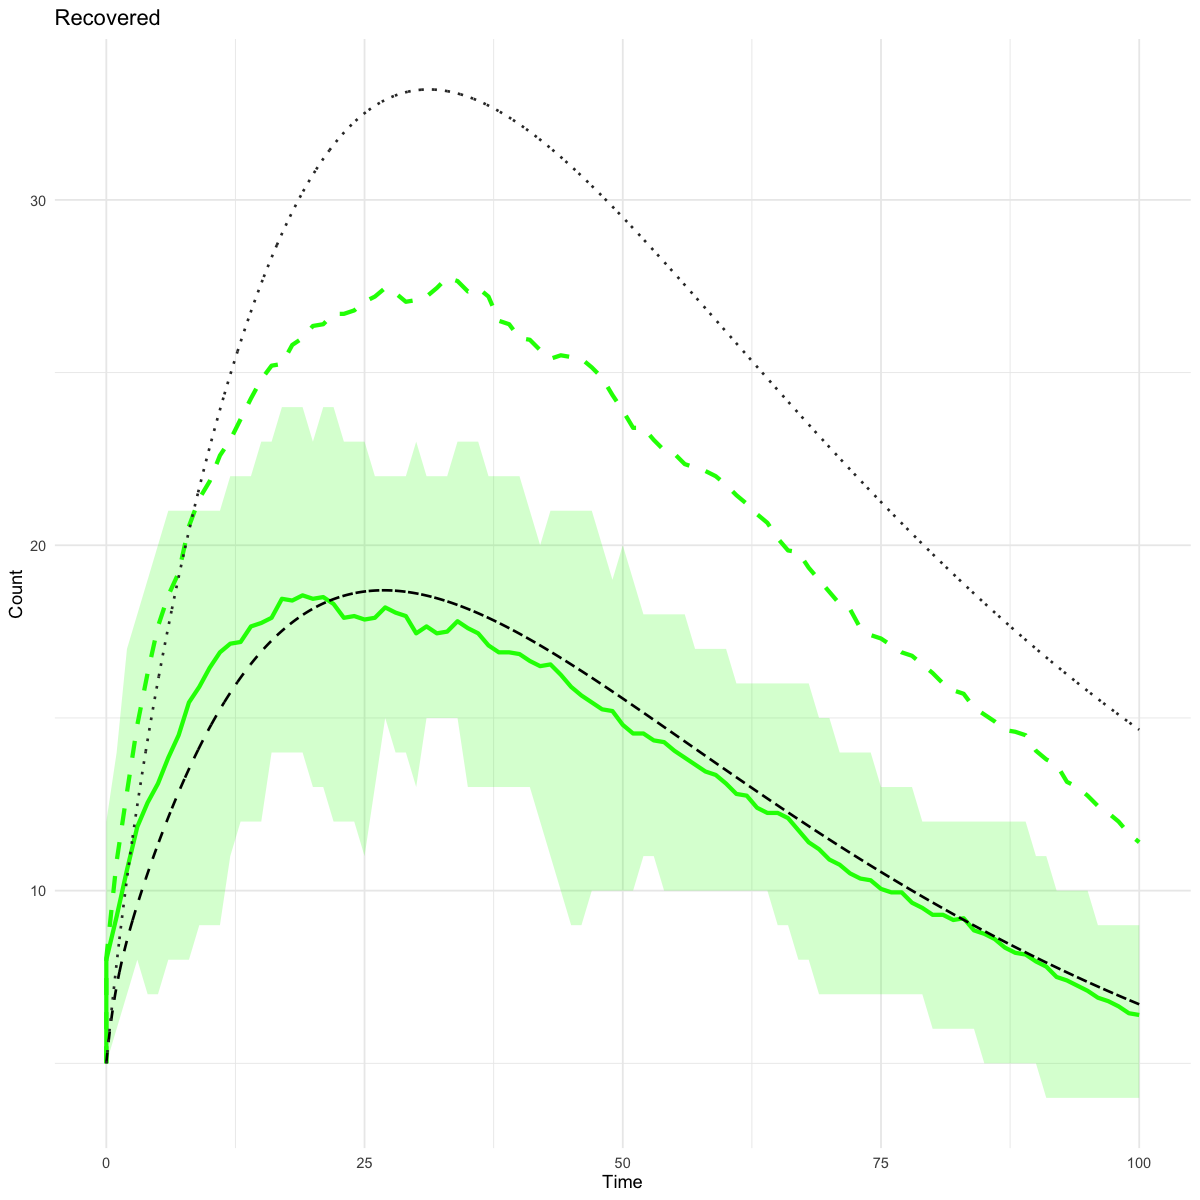

In [46]:
# Overlay ODE results on network simulation plots with min/max shading

# 1. Prepare ODE results as a data.frame for plotting
ode_results <- data.frame(
  time = t,
  S_before = S1,
  E_before = E1,
  I_before = I1,
  T_before = T1,
  R_before = R1,
  S_after = S,
  E_after = E,
  I_after = I,
  T_after = T,
  R_after = R,
  u1 = u1
)

# 2. Calculate ODE objective functional using Simpson's rule (total value)
n_ode <- length(t)
if (n_ode %% 2 == 0) n_ode <- n_ode - 1
ode_times <- t[1:n_ode]
E_ode <- E[1:n_ode]
I_ode <- I[1:n_ode]
u1_ode <- u1[1:n_ode]
w1 <- 0.2
control_cost_ode <- w1 * u1_ode^2
weights <- rep(2, n_ode); weights[1] <- weights[n_ode] <- 1; weights[seq(2, n_ode-1, by=2)] <- 4
h_ode <- mean(diff(ode_times))
J_ode_inst <- E_ode + I_ode + control_cost_ode
J_ode_total <- (h_ode/3) * sum(weights * J_ode_inst)

# 3. Interpolate ODE objective functional to network time grid
J_ode_interp <- approx(x = ode_times, y = J_ode_inst, xout = df_avg$time, rule = 2)$y

# 4. Prepare network objective functional with min/max bands
df_obj_minmax <- data.frame(
  time = df_avg$time,
  min = df_min$E + df_min$I + df_min$control_cost,
  max = df_max$E + df_max$I + df_max$control_cost,
  avg = df_avg$E + df_avg$I + df_avg$control_cost,
  ode_obj_inst = J_ode_interp
)

df_avg_no_control <- results_df_no_control$avg

p_obj <- ggplot(df_obj_minmax, aes(x = time)) +
  geom_ribbon(aes(ymin = min, ymax = max), fill = "gray70", alpha = 0.3) +
  geom_line(aes(y = avg), color = "black", size = 1) +
  geom_line(aes(y = ode_obj_inst), color = "blue", size = 0.7, linetype = "dashed", alpha = 0.8) +
  labs(title = "Obj Func: Net (black, band), ODE (blue)", x = "Time", y = "Objective Functional (Instantaneous)") +
  theme_minimal()

# 5. Optimal control profile
df_u1 <- data.frame(time = df_avg$time, u1 = u1_profile_opt)
df_u1_ode <- data.frame(time = t, u1 = u1)
p_u1 <- ggplot(df_u1, aes(x = time, y = u1)) +
  geom_line(color = "red", size = 1) +
  geom_line(data = df_u1_ode, aes(x = time, y = u1), color = "blue", size = 0.5, linetype = "dashed") +
  labs(title = "Opt Cont u1: Net (red) vs ODE (blue)", x = "Time", y = "u1") +
  theme_minimal()

gridExtra::grid.arrange(p_obj, p_u1, ncol = 2)

# 6. SEITR compartments: overlay ODE before/after optimization, add min/max bands
plot_compartment_band_overlay <- function(df_avg, df_min, df_max, df_avg_no_control, comp, color, title, ode_results, after, before) {
  df <- data.frame(
    time = df_avg$time,
    avg = df_avg[[comp]],
    min = df_min[[comp]],
    max = df_max[[comp]],
    avg_no_control = df_avg_no_control[[comp]]
  )
  ggplot(df, aes(x = time)) +
    geom_ribbon(aes(ymin = min, ymax = max), fill = color, alpha = 0.2) +
    geom_line(aes(y = avg), color = color, size = 1.2) +
    geom_line(aes(y = avg_no_control), color = color, linetype = "dashed", size = 1.2) +
    geom_line(data = ode_results, aes(x = time, y = !!as.name(after)), color = "black", size = 0.75, linetype = "dashed") +
    geom_line(data = ode_results, aes(x = time, y = !!as.name(before)), color = "gray20", size = 0.75, linetype = "dotted") +
    labs(title = title, x = "Time", y = "Count") +
    theme_minimal()
}

p_S <- plot_compartment_band_overlay(df_avg, df_min, df_max, df_avg_no_control, "S", "blue", "Susceptible", ode_results, "S_after", "S_before")
p_E <- plot_compartment_band_overlay(df_avg, df_min, df_max, df_avg_no_control, "E", "orange", "Exposed", ode_results, "E_after", "E_before")
p_I <- plot_compartment_band_overlay(df_avg, df_min, df_max, df_avg_no_control, "I", "red", "Infected", ode_results, "I_after", "I_before")
p_T <- plot_compartment_band_overlay(df_avg, df_min, df_max, df_avg_no_control, "T", "purple", "Treatment", ode_results, "T_after", "T_before")
p_R <- plot_compartment_band_overlay(df_avg, df_min, df_max, df_avg_no_control, "R", "green", "Recovered", ode_results, "R_after", "R_before")

gridExtra::grid.arrange(p_S, p_E, p_I, p_T, p_R, ncol = 2)

print(p_S)
print(p_E)
print(p_I)
print(p_T)
print(p_R)

# Print ODE total objective functional value
cat("ODE total objective functional (Simpson's rule):", J_ode_total, "\n")

In [47]:
compartments <- c("S", "E", "I", "T", "R")
msd_list <- numeric(length(compartments))
rmsd_list <- numeric(length(compartments))
norm_rmsd_list <- numeric(length(compartments))

for (i in seq_along(compartments)) {
  comp <- compartments[i]
  ode_interp <- approx(x = ode_results$time, y = ode_results[[paste0(comp, "_after")]], xout = df_avg$time, rule = 2)$y
  net_avg <- df_avg[[comp]]
  msd <- mean((net_avg - ode_interp)^2)
  rmsd <- sqrt(msd)
  #Added max
  norm_factor <- max(1, mean(net_avg)) # You can also use max(net_avg) or range(net_avg)
  norm_rmsd <- rmsd / norm_factor
  msd_list[i] <- msd
  rmsd_list[i] <- rmsd
  norm_rmsd_list[i] <- norm_rmsd
  cat(sprintf("Compartment: %s | MSD: %.4f | RMSD: %.4f | Normalized RMSD: %.4f\n", comp, msd, rmsd, norm_rmsd))
}

Compartment: S | MSD: 7.0749 | RMSD: 2.6599 | Normalized RMSD: 0.0909
Compartment: E | MSD: 1.4549 | RMSD: 1.2062 | Normalized RMSD: 0.2527
Compartment: I | MSD: 1.4285 | RMSD: 1.1952 | Normalized RMSD: 1.1952
Compartment: T | MSD: 2.5562 | RMSD: 1.5988 | Normalized RMSD: 0.4958
Compartment: R | MSD: 0.7501 | RMSD: 0.8661 | Normalized RMSD: 0.0653


Network size 100, WS, p = 0.3, k = 10

Uses ODE solution from previous experiment set

In [48]:
# Define model parameters and initial conditions
Lambda    <- 0.4         # Recruitment rate
beta1     <- 0.9         # Transmission rate (S to E)
beta2     <- 0.059       # Progression rate (E to I)
beta3     <- 0.2         # Recovery rate (I to R)
alpha1    <- 0.03        # Treatment rate (I to T)
alpha2    <- 0.055       # Recovery rate from treatment (T to R)
delta_I   <- 0.03        # Disease-induced death rate (I)
delta_T   <- 0.03        # Disease-induced death rate (T)
mu        <- 0.02        # Natural death rate

# Control parameters
w1        <- 0.2         # Weight for control cost
zeta      <- 1           # Upper bound for control
# Simulation time setup
t_max     <- 100
dt        <- 1           # Time step for network simulation
times     <- seq(0, t_max, by = dt)
# Initial conditions
init_S    <- 50
init_E    <- 25
init_I    <- 15
init_T    <- 5
init_R    <- 5
init_N    <- init_S + init_E + init_I + init_T + init_R

# Network parameters
network_type <- "WS"     # Network type: ER, BA, WS, LN, RR
n            <- 100       # Initial number of nodes
n_par1       <- 0.3      # Network-specific parameter 1
n_par2       <- 10       # Network-specific parameter 2

# Interpolate ODE optimal control to network simulation time grid for initial experiment
# u1_profile <- approx(x = t, y = u1, xout = seq(0, t_max+1, by = dt), rule = 2)$y

Calculate u1_profile on network simulations

In [49]:
# Set up parallel backend
n_cores <- detectCores() - 3
cl <- makeCluster(n_cores)
setDefaultCluster(cl)
clusterEvalQ(cl, library(igraph))

# Make RNG streams consistent across calls
RNGkind("L'Ecuyer-CMRG")

# Parameterization
K <- 12
total_steps <- length(seq(0, t_max, by = dt))
interval_length <- ceiling(total_steps / K)

expand_u1 <- function(params_seg, total_length, interval_length) {
  prof <- rep(params_seg, each = interval_length)[1:total_length]
  pmin(zeta, pmax(0, prof))
}

# Bounded transform (unconstrained -> [0, zeta])
to_un <- function(u) qlogis(pmin(pmax(u / zeta, 1e-6), 1 - 1e-6))
from_un <- function(x) zeta * plogis(x)

# Objective: use CRN and heavier averaging during optimization
objective_wrapper <- function(params_un) {
  set.seed(12345)  # CRN for fair comparisons across parameter sets
  u1_seg <- from_un(params_un)
  u1_profile <- expand_u1(u1_seg, total_steps, interval_length)
  # Call simulator directly to control averaging
  results <- run_seitr_network_simulation(
    network_type = network_type, n = n, n_par1 = n_par1, n_par2 = n_par2,
    Lambda = Lambda, beta1 = beta1, beta2 = beta2, beta3 = beta3, alpha1 = alpha1, alpha2 = alpha2,
    delta_I = delta_I, delta_T = delta_T, mu = mu,
    init_S = init_S, init_E = init_E, init_I = init_I, init_T = init_T, init_R = init_R,
    t_max = t_max, u1_profile = u1_profile, num_exp = 40, verbose = FALSE
  )
  calculate_objective_functional(results$avg)$J_total
}

# Initialize around previous constant 0.03
init_seg <- rep(0.03, K)
init_params_un <- to_un(init_seg)

# Export everything used by workers
clusterExport(cl, varlist = c(
  "expand_u1", "objective_wrapper", "from_un", "to_un",
  "K", "interval_length", "total_steps", "zeta",
  "run_seitr_network_simulation", "calculate_objective_functional",
  "generate_network", "initialize_node_statuses", "update_node_status", "connect_new_nodes",
  "network_type", "n", "n_par1", "n_par2",
  "Lambda", "beta1", "beta2", "beta3", "alpha1", "alpha2",
  "delta_I", "delta_T", "mu", "init_S", "init_E", "init_I", "init_T", "init_R", "t_max", "dt", "w1"
))

# Run optimization
result <- optimParallel(
  par = init_seg,
  fn = objective_wrapper,
  method = "L-BFGS-B",
  lower = 0,
  upper = zeta,
  control = list(trace = 1, maxit = 2000, pgtol = 1e-6),
  cl = cl
)

# Build optimized profile back on the simulation grid
u1_opt_params_un <- as.numeric(result$par)
u1_opt_seg       <- from_un(u1_opt_params_un)
u1_profile_opt   <- expand_u1(u1_opt_seg, total_steps, interval_length)

stopCluster(cl)

[[1]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[3]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[4]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[5]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[6]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[7]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[8]]
[1] "igraph"    "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"

final  value 404.010750 
converged


Run the experiments

In [50]:
# Run the SEITR network simulation with the optimal control profile

results_df <- run_seitr_network_simulation(
  network_type = network_type, n = n, n_par1 = n_par1, n_par2 = n_par2,
  Lambda = Lambda, beta1 = beta1, beta2 = beta2, beta3 = beta3, alpha1 = alpha1, alpha2 = alpha2,
  delta_I = delta_I, delta_T = delta_T, mu = mu,
  init_S = init_S, init_E = init_E, init_I = init_I, init_T = init_T, init_R = init_R,
  t_max = t_max, u1_profile = u1_profile_opt, num_exp = 20
)

J <- calculate_objective_functional(results_df$avg)

Warning message:
"`get.edge.ids()` was deprecated in igraph 2.1.0.
i Please use `get_edge_ids()` instead."


In [51]:
# Run the SEITR network simulation with the optimal control profile
# but no control (u1 = 0) for comparison
u1_profile_no_control <- rep(0, total_steps)

results_df_no_control <- run_seitr_network_simulation(
  network_type = network_type, n = n, n_par1 = n_par1, n_par2 = n_par2,
  Lambda = Lambda, beta1 = beta1, beta2 = beta2, beta3 = beta3, alpha1 = alpha1, alpha2 = alpha2,
  delta_I = delta_I, delta_T = delta_T, mu = mu,
  init_S = init_S, init_E = init_E, init_I = init_I, init_T = init_T, init_R = init_R,
  t_max = t_max, u1_profile = u1_profile_no_control, num_exp = 20
)

J_no_control <- calculate_objective_functional(results_df_no_control$avg)

Network simulation results

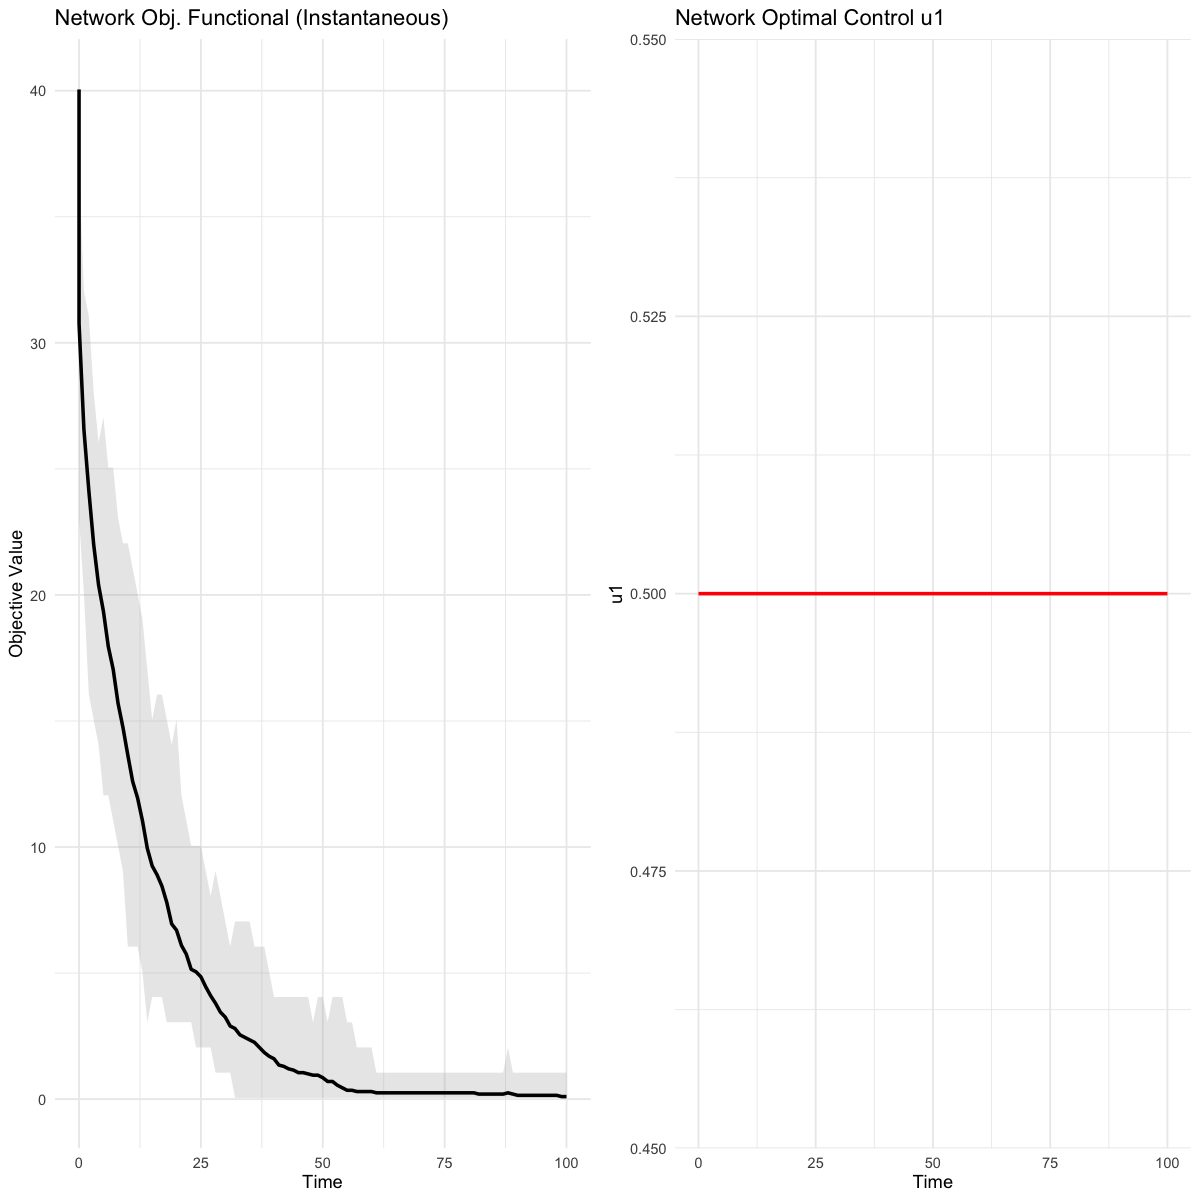

Network-based optimal control: Total objective functional = 422.7135 


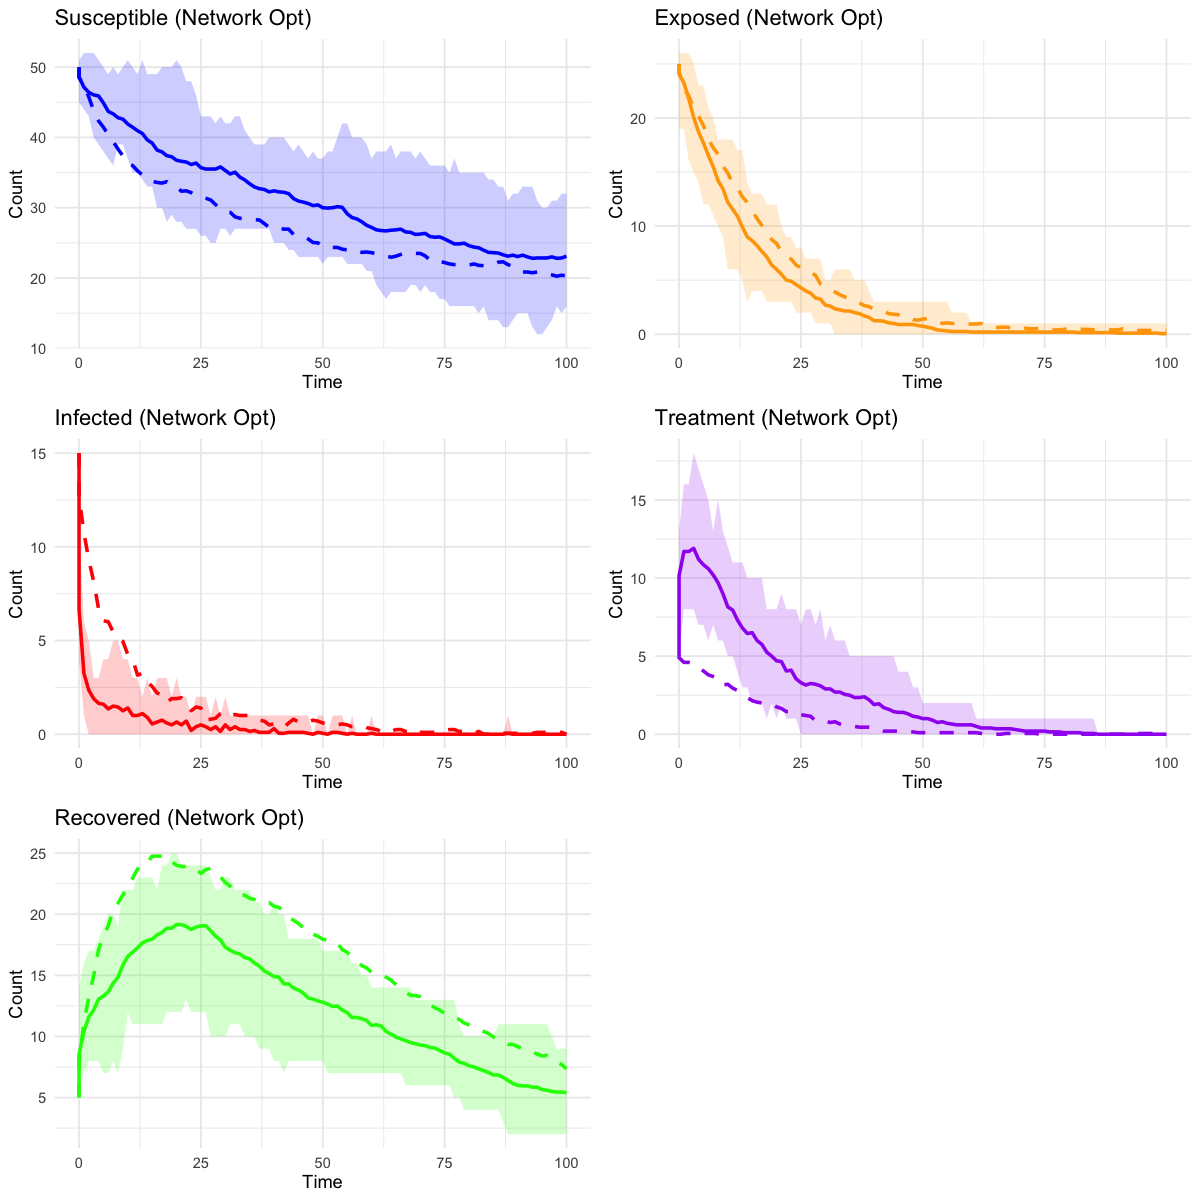

In [52]:
# --- Network simulation results with shaded min/max area (Network-based Optimal Control) ---
# Ensure u1_profile_opt matches df_avg$time length
# Use the avg/min/max from results_df
df_avg <- results_df$avg
df_min <- results_df$min
df_max <- results_df$max
# Use the avg from results_df_no_control for comparison
df_avg_no_control <- results_df_no_control$avg

if (length(u1_profile_opt) < length(df_avg$time)) {
  u1_profile_opt <- c(u1_profile_opt, rep(tail(u1_profile_opt, 1), length(df_avg$time) - length(u1_profile_opt)))
} else if (length(u1_profile_opt) > length(df_avg$time)) {
  u1_profile_opt <- u1_profile_opt[seq_along(df_avg$time)]
}


# 1. Objective functional and optimal control profile (average only)
df_obj <- data.frame(
  time = df_avg$time,
  obj_inst = df_avg$E + df_avg$I + df_avg$control_cost
)
df_obj_minmax <- data.frame(
  time = df_avg$time,
  min = df_min$E + df_min$I + df_min$control_cost,
  max = df_max$E + df_max$I + df_max$control_cost,
  avg = df_avg$E + df_avg$I + df_avg$control_cost
)

# Use the optimized control profile if available
if (exists("u1_profile_opt")) {
  df_u1 <- data.frame(time = df_avg$time, u1 = u1_profile_opt)
} else {
  stop("u1_profile_opt not found. Run the optimizer first.")
}

p_obj <- ggplot(df_obj_minmax, aes(x = time)) +
  geom_ribbon(aes(ymin = min, ymax = max), fill = "gray70", alpha = 0.3) +
  geom_line(aes(y = avg), color = "black", size = 1) +
  labs(title = "Network Obj. Functional (Instantaneous)", x = "Time", y = "Objective Value") +
  theme_minimal()

p_u1 <- ggplot(df_u1, aes(x = time, y = u1)) +
  geom_line(color = "red", size = 1) +
  labs(title = "Network Optimal Control u1", x = "Time", y = "u1") +
  theme_minimal()

gridExtra::grid.arrange(p_obj, p_u1, ncol = 2)

# 2. SEITR compartments with shaded min/max area
plot_compartment_band <- function(df_avg, df_min, df_max, df_avg_no_control, comp, color, title) {
  df <- data.frame(
    time = df_avg$time,
    avg = df_avg[[comp]],
    min = df_min[[comp]],
    max = df_max[[comp]],
    avg_no_control = df_avg_no_control[[comp]]
  )
  ggplot(df, aes(x = time)) +
    geom_ribbon(aes(ymin = min, ymax = max), fill = color, alpha = 0.2) +
    geom_line(aes(y = avg), color = color, size = 1) +
    geom_line(aes(y = avg_no_control), color = color, linetype = "dashed", size = 1) +
    labs(title = paste0(title, " (Network Opt)"), x = "Time", y = "Count") +
    theme_minimal()
}

p_S <- plot_compartment_band(df_avg, df_min, df_max, df_avg_no_control, "S", "blue", "Susceptible")
p_E <- plot_compartment_band(df_avg, df_min, df_max, df_avg_no_control, "E", "orange", "Exposed")
p_I <- plot_compartment_band(df_avg, df_min, df_max, df_avg_no_control, "I", "red", "Infected")
p_T <- plot_compartment_band(df_avg, df_min, df_max, df_avg_no_control, "T", "purple", "Treatment")
p_R <- plot_compartment_band(df_avg, df_min, df_max, df_avg_no_control, "R", "green", "Recovered")

gridExtra::grid.arrange(p_S, p_E, p_I, p_T, p_R, ncol = 2)

# Print final objective functional value
cat("Network-based optimal control: Total objective functional =", J$J_total, "\n")

Network simulation vs ODE solution with and without Optimal Control

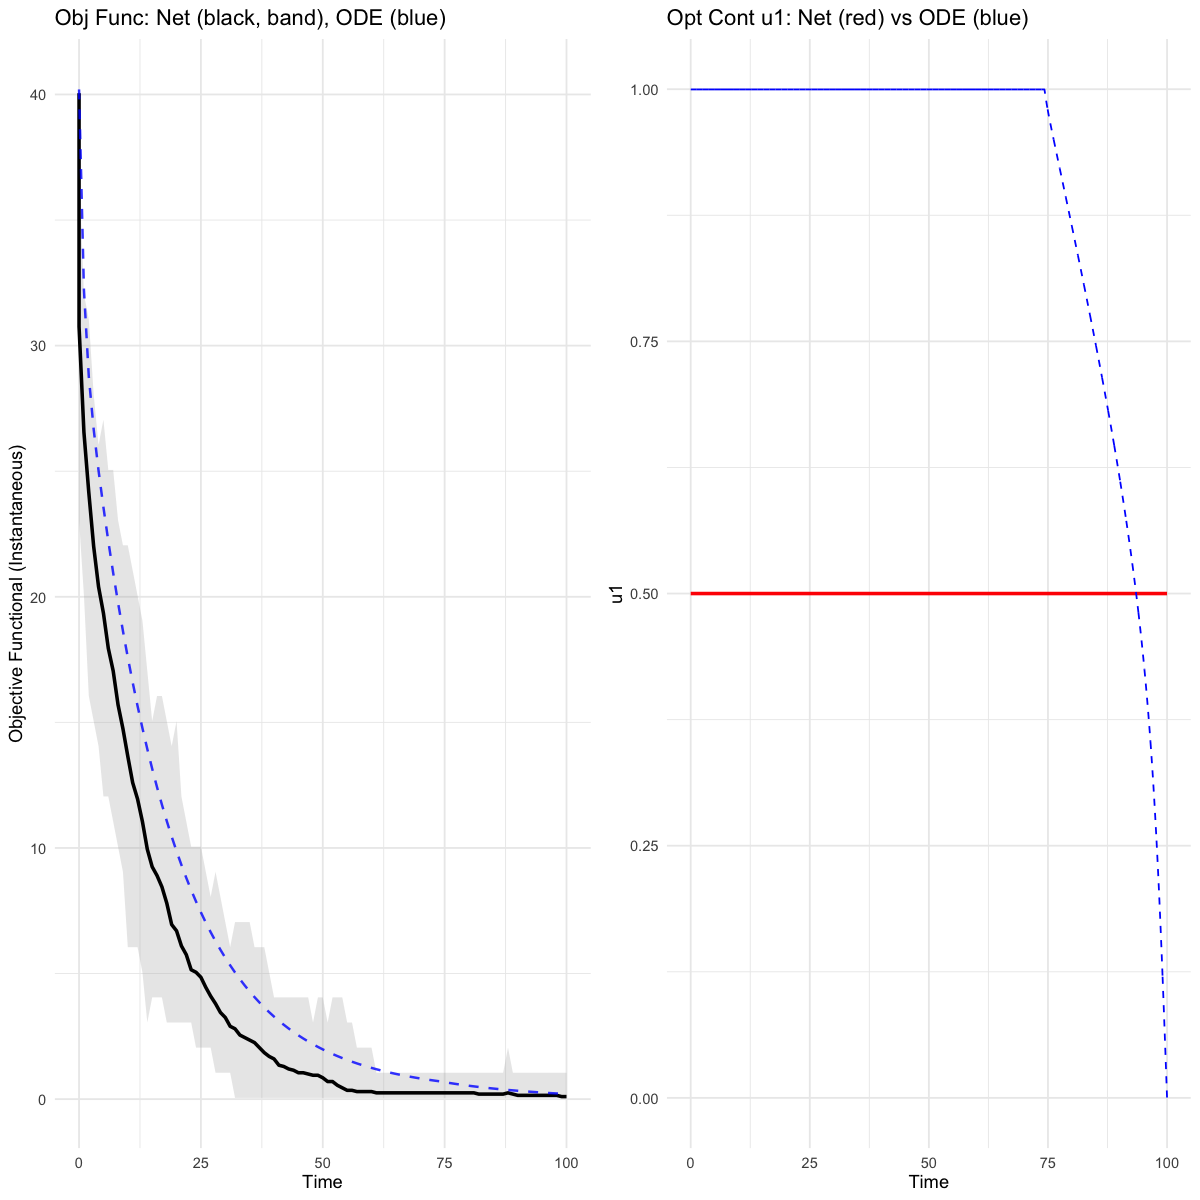

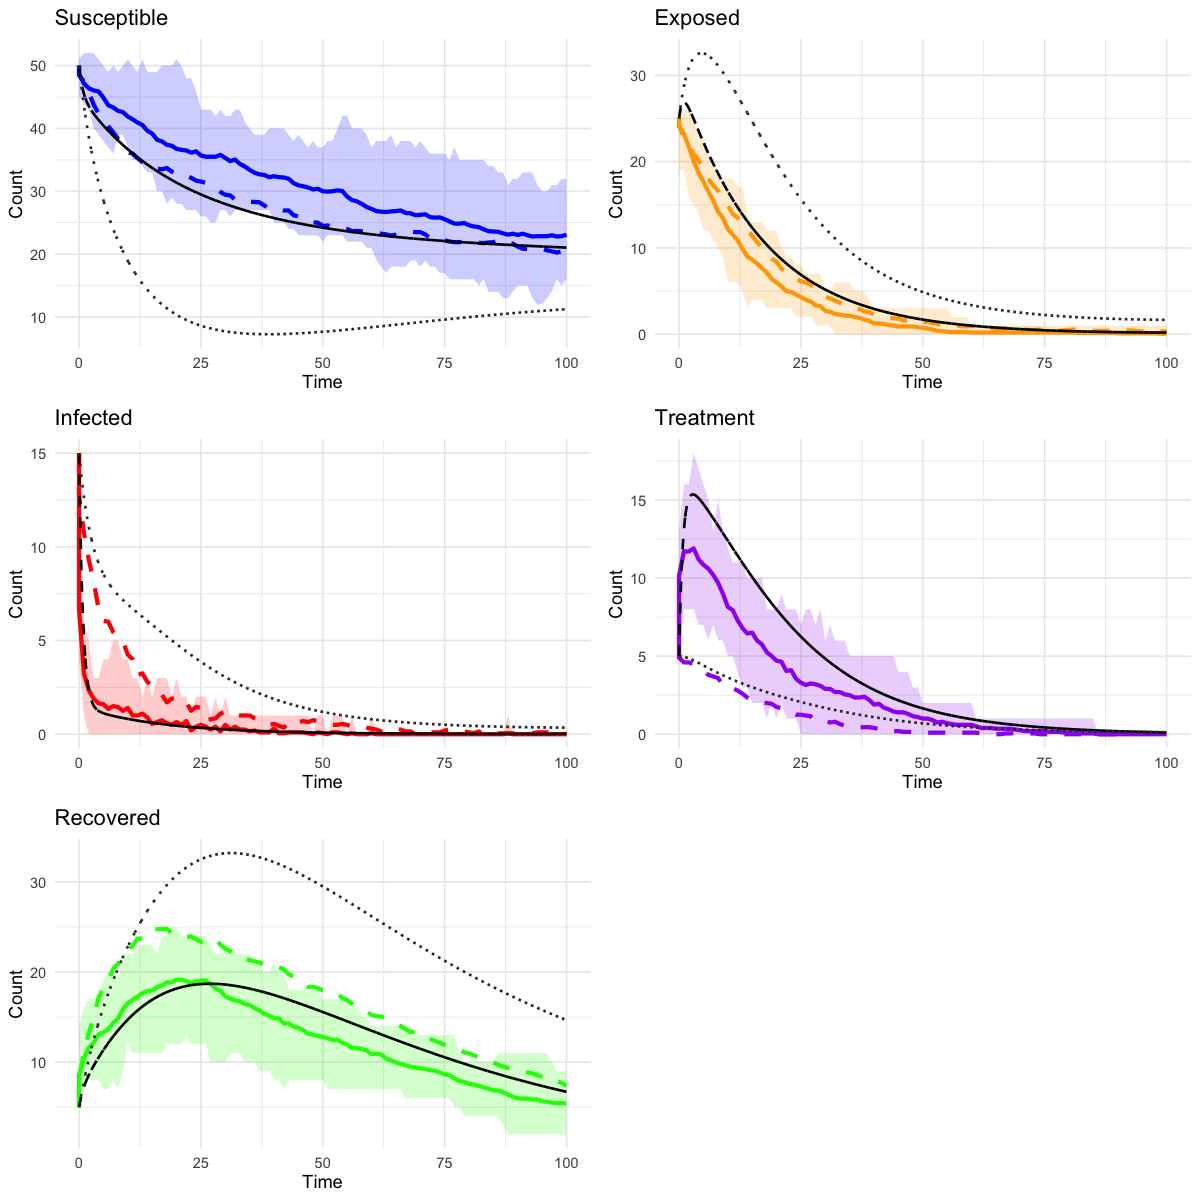

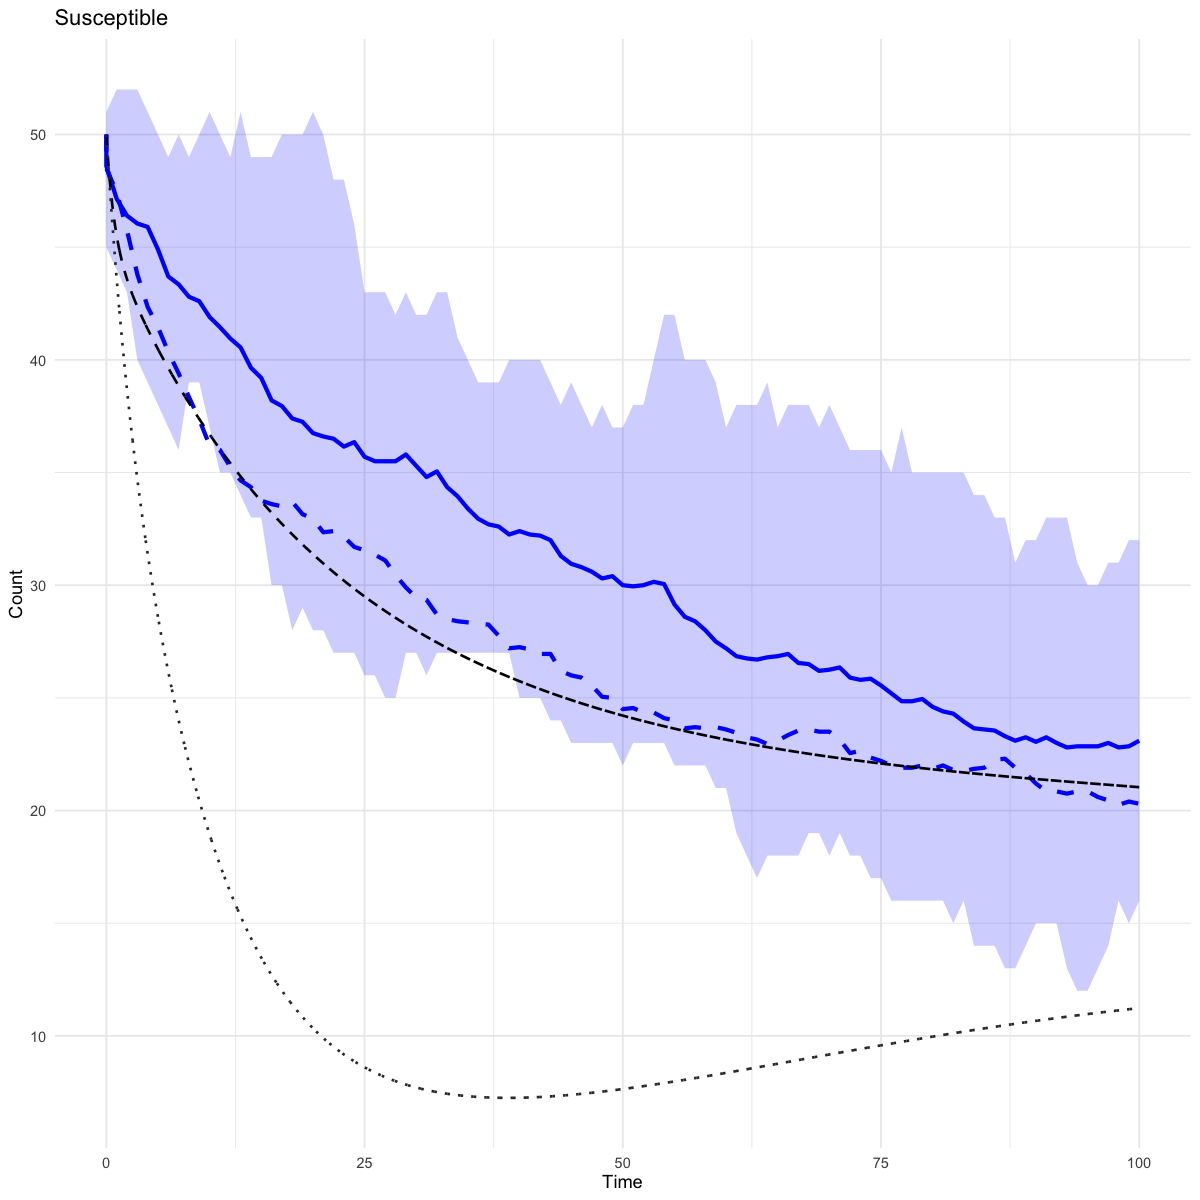

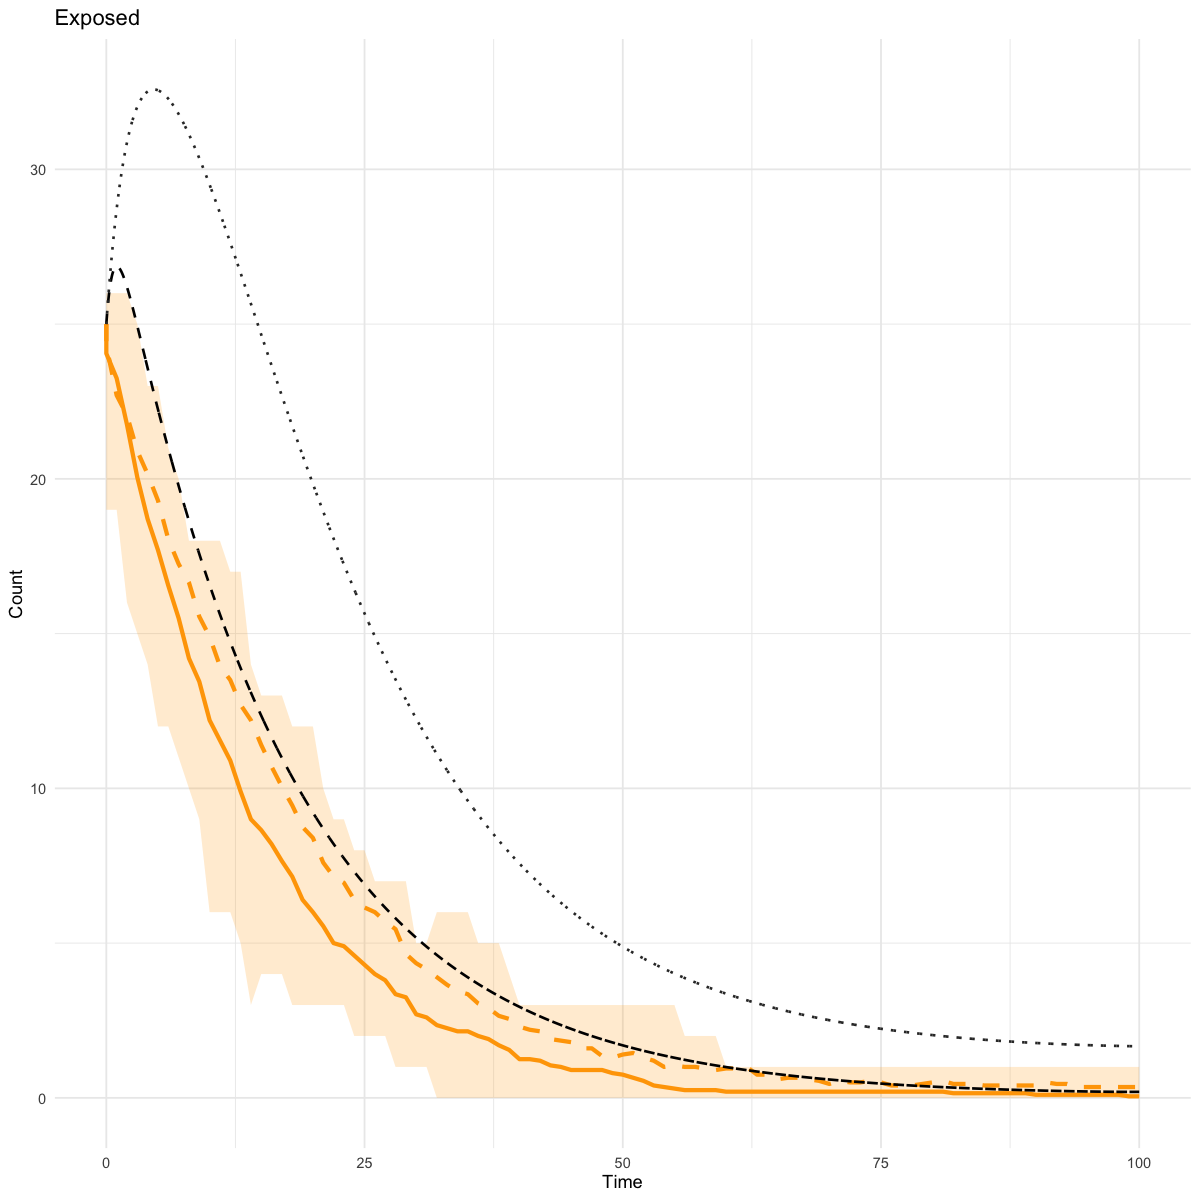

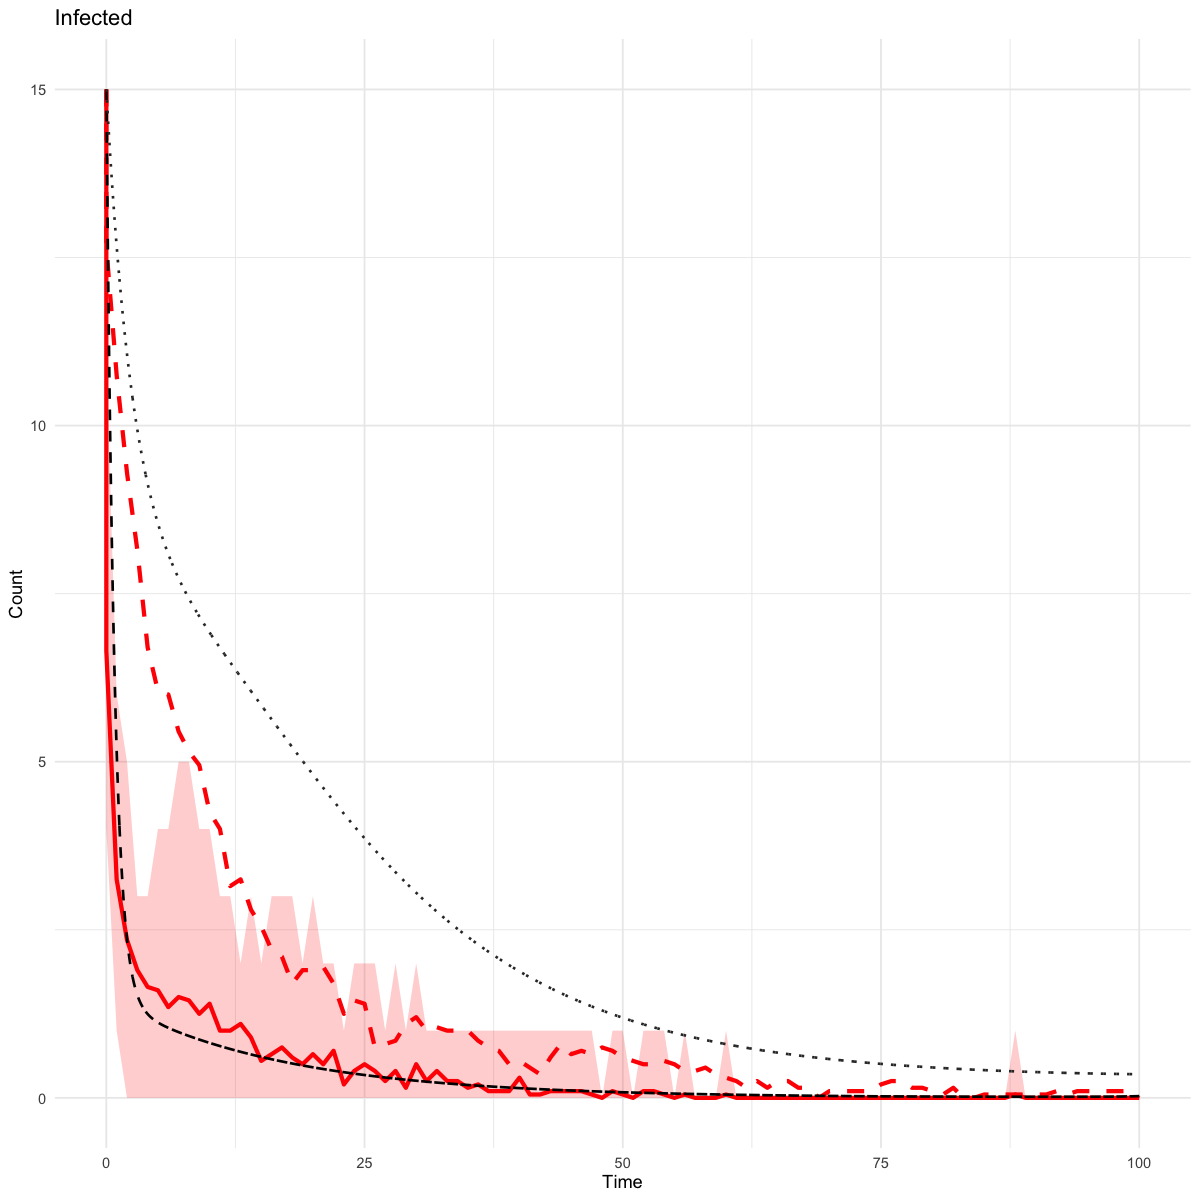

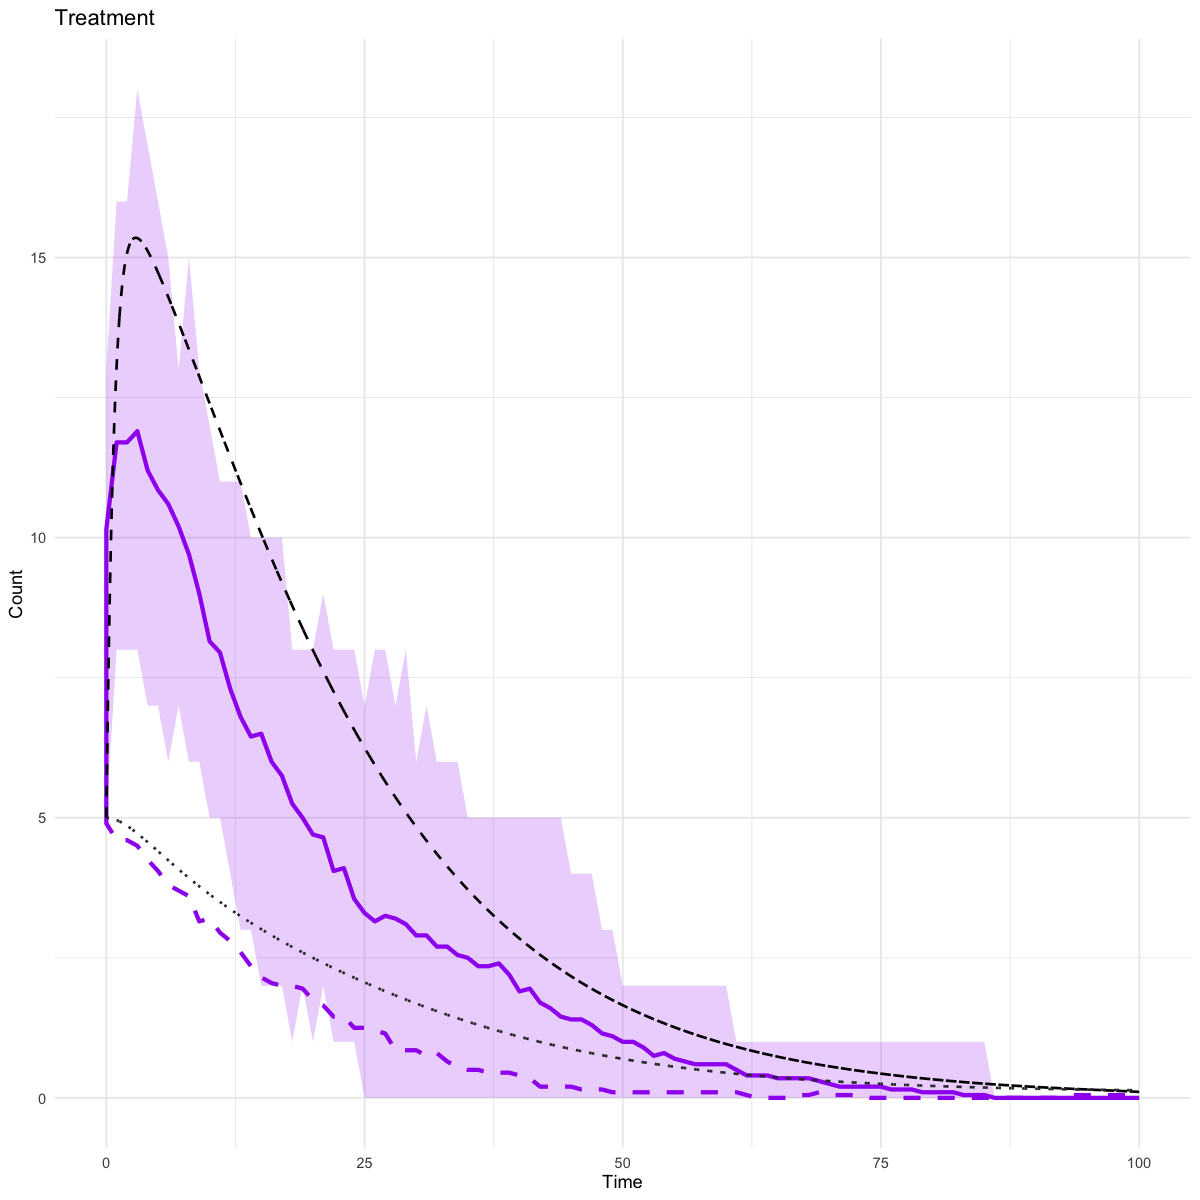

ODE total objective functional (Simpson's rule): 563.314 


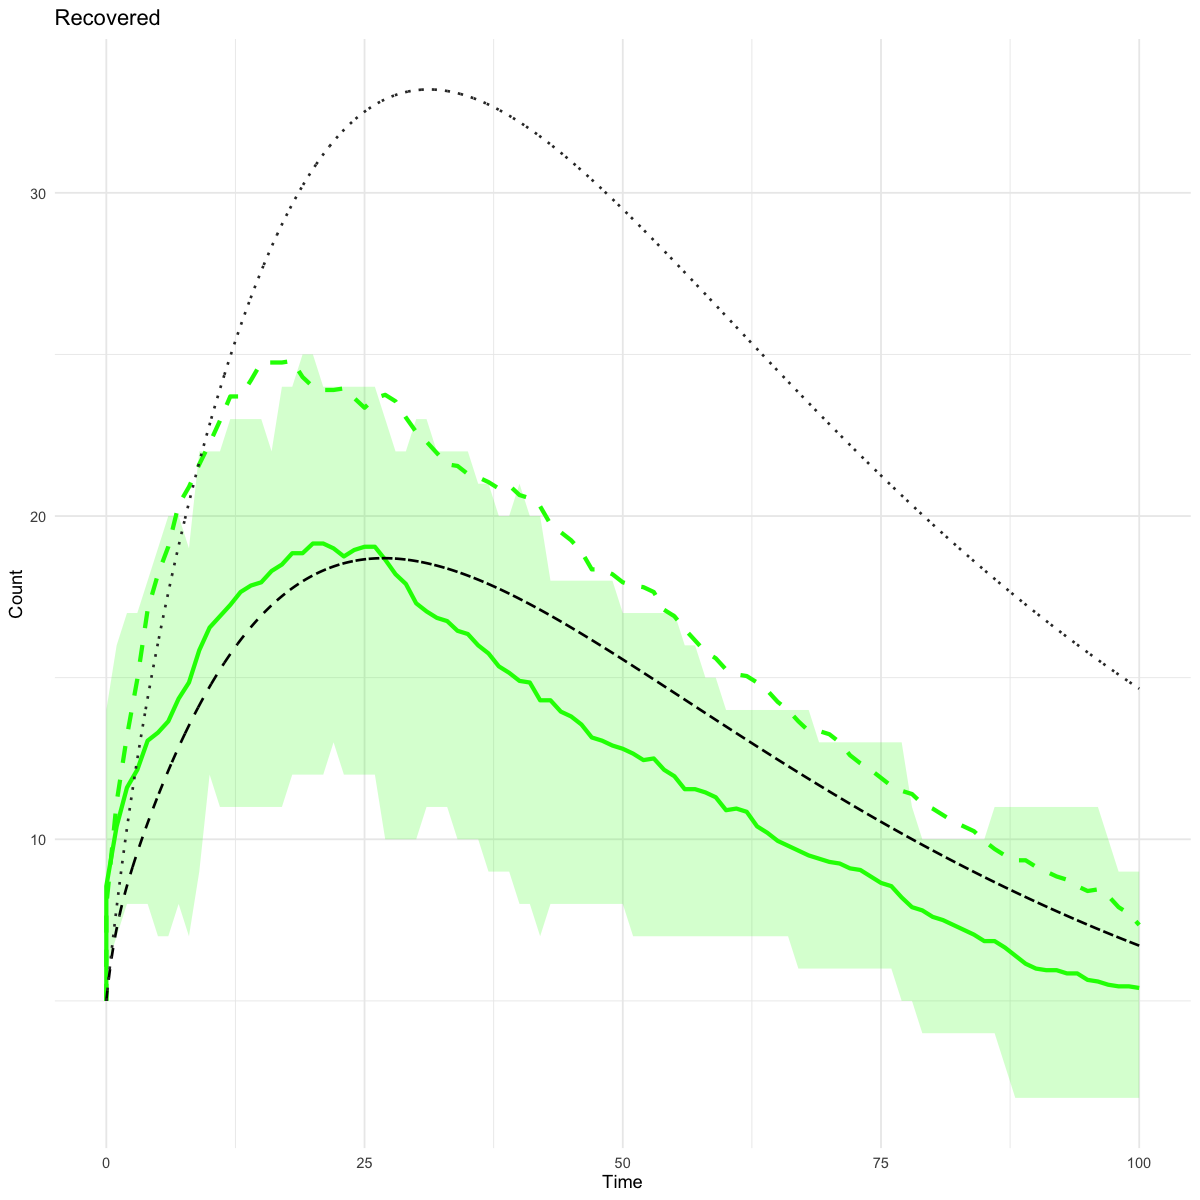

In [53]:
# Overlay ODE results on network simulation plots with min/max shading

# 1. Prepare ODE results as a data.frame for plotting
ode_results <- data.frame(
  time = t,
  S_before = S1,
  E_before = E1,
  I_before = I1,
  T_before = T1,
  R_before = R1,
  S_after = S,
  E_after = E,
  I_after = I,
  T_after = T,
  R_after = R,
  u1 = u1
)

# 2. Calculate ODE objective functional using Simpson's rule (total value)
n_ode <- length(t)
if (n_ode %% 2 == 0) n_ode <- n_ode - 1
ode_times <- t[1:n_ode]
E_ode <- E[1:n_ode]
I_ode <- I[1:n_ode]
u1_ode <- u1[1:n_ode]
w1 <- 0.2
control_cost_ode <- w1 * u1_ode^2
weights <- rep(2, n_ode); weights[1] <- weights[n_ode] <- 1; weights[seq(2, n_ode-1, by=2)] <- 4
h_ode <- mean(diff(ode_times))
J_ode_inst <- E_ode + I_ode + control_cost_ode
J_ode_total <- (h_ode/3) * sum(weights * J_ode_inst)

# 3. Interpolate ODE objective functional to network time grid
J_ode_interp <- approx(x = ode_times, y = J_ode_inst, xout = df_avg$time, rule = 2)$y

# 4. Prepare network objective functional with min/max bands
df_obj_minmax <- data.frame(
  time = df_avg$time,
  min = df_min$E + df_min$I + df_min$control_cost,
  max = df_max$E + df_max$I + df_max$control_cost,
  avg = df_avg$E + df_avg$I + df_avg$control_cost,
  ode_obj_inst = J_ode_interp
)

df_avg_no_control <- results_df_no_control$avg

p_obj <- ggplot(df_obj_minmax, aes(x = time)) +
  geom_ribbon(aes(ymin = min, ymax = max), fill = "gray70", alpha = 0.3) +
  geom_line(aes(y = avg), color = "black", size = 1) +
  geom_line(aes(y = ode_obj_inst), color = "blue", size = 0.7, linetype = "dashed", alpha = 0.8) +
  labs(title = "Obj Func: Net (black, band), ODE (blue)", x = "Time", y = "Objective Functional (Instantaneous)") +
  theme_minimal()

# 5. Optimal control profile
df_u1 <- data.frame(time = df_avg$time, u1 = u1_profile_opt)
df_u1_ode <- data.frame(time = t, u1 = u1)
p_u1 <- ggplot(df_u1, aes(x = time, y = u1)) +
  geom_line(color = "red", size = 1) +
  geom_line(data = df_u1_ode, aes(x = time, y = u1), color = "blue", size = 0.5, linetype = "dashed") +
  labs(title = "Opt Cont u1: Net (red) vs ODE (blue)", x = "Time", y = "u1") +
  theme_minimal()

gridExtra::grid.arrange(p_obj, p_u1, ncol = 2)

# 6. SEITR compartments: overlay ODE before/after optimization, add min/max bands
plot_compartment_band_overlay <- function(df_avg, df_min, df_max, df_avg_no_control, comp, color, title, ode_results, after, before) {
  df <- data.frame(
    time = df_avg$time,
    avg = df_avg[[comp]],
    min = df_min[[comp]],
    max = df_max[[comp]],
    avg_no_control = df_avg_no_control[[comp]]
  )
  ggplot(df, aes(x = time)) +
    geom_ribbon(aes(ymin = min, ymax = max), fill = color, alpha = 0.2) +
    geom_line(aes(y = avg), color = color, size = 1.2) +
    geom_line(aes(y = avg_no_control), color = color, linetype = "dashed", size = 1.2) +
    geom_line(data = ode_results, aes(x = time, y = !!as.name(after)), color = "black", size = 0.75, linetype = "dashed") +
    geom_line(data = ode_results, aes(x = time, y = !!as.name(before)), color = "gray20", size = 0.75, linetype = "dotted") +
    labs(title = title, x = "Time", y = "Count") +
    theme_minimal()
}

p_S <- plot_compartment_band_overlay(df_avg, df_min, df_max, df_avg_no_control, "S", "blue", "Susceptible", ode_results, "S_after", "S_before")
p_E <- plot_compartment_band_overlay(df_avg, df_min, df_max, df_avg_no_control, "E", "orange", "Exposed", ode_results, "E_after", "E_before")
p_I <- plot_compartment_band_overlay(df_avg, df_min, df_max, df_avg_no_control, "I", "red", "Infected", ode_results, "I_after", "I_before")
p_T <- plot_compartment_band_overlay(df_avg, df_min, df_max, df_avg_no_control, "T", "purple", "Treatment", ode_results, "T_after", "T_before")
p_R <- plot_compartment_band_overlay(df_avg, df_min, df_max, df_avg_no_control, "R", "green", "Recovered", ode_results, "R_after", "R_before")

gridExtra::grid.arrange(p_S, p_E, p_I, p_T, p_R, ncol = 2)

print(p_S)
print(p_E)
print(p_I)
print(p_T)
print(p_R)

# Print ODE total objective functional value
cat("ODE total objective functional (Simpson's rule):", J_ode_total, "\n")

In [54]:
compartments <- c("S", "E", "I", "T", "R")
msd_list <- numeric(length(compartments))
rmsd_list <- numeric(length(compartments))
norm_rmsd_list <- numeric(length(compartments))

for (i in seq_along(compartments)) {
  comp <- compartments[i]
  ode_interp <- approx(x = ode_results$time, y = ode_results[[paste0(comp, "_after")]], xout = df_avg$time, rule = 2)$y
  net_avg <- df_avg[[comp]]
  msd <- mean((net_avg - ode_interp)^2)
  rmsd <- sqrt(msd)
  #Added max
  norm_factor <- max(1, mean(net_avg)) # You can also use max(net_avg) or range(net_avg)
  norm_rmsd <- rmsd / norm_factor
  msd_list[i] <- msd
  rmsd_list[i] <- rmsd
  norm_rmsd_list[i] <- norm_rmsd
  cat(sprintf("Compartment: %s | MSD: %.4f | RMSD: %.4f | Normalized RMSD: %.4f\n", comp, msd, rmsd, norm_rmsd))
}

Compartment: S | MSD: 23.2331 | RMSD: 4.8201 | Normalized RMSD: 0.1531
Compartment: E | MSD: 4.5383 | RMSD: 2.1303 | Normalized RMSD: 0.5591
Compartment: I | MSD: 0.7443 | RMSD: 0.8627 | Normalized RMSD: 0.8627
Compartment: T | MSD: 3.8405 | RMSD: 1.9597 | Normalized RMSD: 0.7443
Compartment: R | MSD: 4.1743 | RMSD: 2.0431 | Normalized RMSD: 0.1678
